# Demo: How to Use pyGLMHMM

Here, we want to show the application of pyGLMHMM on some simulated data.

## Importing the required dependencies

We start importing the required dependencies for generating the simulated data and running the main program:

In [1]:
import numpy as np
import scipy.stats
import scipy.ndimage.filters
import matplotlib.pyplot as plt
from GLMHMM import GLMHMMEstimator

## Setting the initial parameters of GLMHMMEstimator for num_sample = 1

An instance of 'GLMHMMEstimator' class must be generated with its different parameters. The most important ones are:

- num_samples: the number of distinct samples in the input data
- num_states: the number of hidden internal states
- num_emissions: the number of emitted behaviors or actions (like song types)
- num_feedbacks: the number of sensory feedback cues
- num_filter_bins: the number of bins to discretize the filters of sensory feedback cues
- num_steps: the number of steps taken in the maximization step of the EM algorithm for calculating the emission matrix
- filter_offset: the number of bias terms added to the sensory feedback cues

In [2]:
num_samples = 1
num_states = 2
num_emissions = 2
num_feedbacks = 3
num_filter_bins = 30
num_steps = 1
filter_offset = 1

## Initializing the simulation variables

In [3]:
tau = 4
total_time = 10000
noiseSD = 0.1
stim_scale = 1
num_real_states = 2

In [4]:
stim = []
states = []
output_stim = []
output_symb = []

## Generating random stimuli (sensory feedback cues)

In [5]:
stim_temp = np.zeros((num_filter_bins, total_time + num_filter_bins - 1, num_feedbacks))
stim_temp[0, :, :] = scipy.ndimage.filters.gaussian_filter(np.random.randn(total_time + num_filter_bins - 1, num_feedbacks), stim_scale)
    
for i in range(1, num_filter_bins):
    stim_temp[i, 0:total_time, :] = stim_temp[0, i:(total_time + i), :]
    
stim.append(stim_temp[:, 0:total_time, :] + np.random.randn(num_filter_bins, total_time, num_feedbacks) * noiseSD)

We concatenate the stimuli of all sensory feedback cues and augment it with bias or offset terms (with value '1') and generate the final 'output_stim' (X) variable: 

In [6]:
final_stim = np.append(stim[0][:, :, 0], stim[0][:, :, 1], axis = 0)
final_stim = np.append(final_stim, stim[0][:, :, 2], axis = 0)
final_stim = np.append(final_stim, np.ones((filter_offset, total_time)), axis = 0)
output_stim.append(final_stim)

## Generating a random filter which acts on behavior emissions and state transitions

The GLM–HMM model allows each state to have an associated multinomial GLM or 'filter' to describe the mapping from feedback cues to the probability of emitting a particular type of behavior. Each state also has a multinomial GLM or 'filter' that produces a mapping from feedback cues to the transition probabilities from the current state to the next state. 

In [7]:
filt = scipy.stats.gamma.pdf(np.linspace(0, num_filter_bins), a = tau)[0:num_filter_bins]

The filter with positive (nagative) sign acts on the first (second) stimulus type or sensory feedback cue to determine the emission probability of the first type of behavior. Moreover, the filter with nagative (positive) sign acts on the first (second) stimulus type or sensory feedback cue to determine the emission probability of the second type of behavior. Also, the filter with positive sign acts on the third stimulus or sensory feedback cue to determine the transition probability from the first state to the second state.

In [8]:
output = np.zeros((num_real_states, total_time))

p1 = np.exp(np.matmul(stim[0][:, :, 0].T, filt.T) + np.matmul(stim[0][:, :, 1].T, -filt.T))
output[0, :] = p1 / (1 + p1) > 0.5
p2 = np.exp(np.matmul(stim[0][:, :, 0].T, -filt.T) + np.matmul(stim[0][:, :, 1].T, filt.T))
output[1, :] = p2 / (1 + p2) > 0.5

p3 = np.exp(np.matmul(stim[0][:, :, 2].T, filt.T))
states.append(p3 / (1 + p3) > 0.5)

We generate the final 'output_symb' (y) variable: 

In [9]:
output_symb.append(np.zeros(total_time))
for ss in range(0, num_real_states):
    output_symb[0][states[0] == ss] = output[ss][states[0] == ss]

Here are the plots for emission and transtion filters across sensory feedback cues:

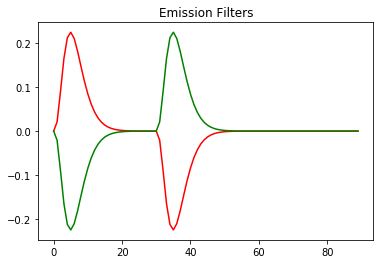

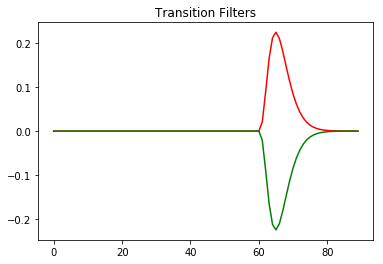

In [10]:
emission1 = np.expand_dims(np.concatenate((filt, -filt, np.zeros(num_filter_bins)), axis = 0), axis = 1)
emission2 = np.expand_dims(np.concatenate((-filt, filt, np.zeros(num_filter_bins)), axis = 0), axis = 1)
emission_filter = np.concatenate((emission1, emission2), axis = 1).T

plt.figure()
plt.title("Emission Filters")
plt.plot(range(0, 90), emission_filter[0, :], "-r")
plt.plot(range(0, 90), emission_filter[1, :], "-g")
plt.show()

transition1 = np.expand_dims(np.concatenate((np.zeros(num_filter_bins), np.zeros(num_filter_bins), filt), axis = 0), axis = 1)
transition2 = np.expand_dims(np.concatenate((np.zeros(num_filter_bins), np.zeros(num_filter_bins), -filt), axis = 0), axis = 1)
transition_filter = np.concatenate((transition1, transition2), axis = 1).T

plt.figure()
plt.title("Transition Filters")
plt.plot(range(0, 90), transition_filter[0, :], "-r")
plt.plot(range(0, 90), transition_filter[1, :], "-g")
plt.show()

## Running the GLM-HMM fitting

Now, we generate an instance of 'GLMHMMEstimator' class with the initial parameters and run the 'fit' method with the simulated variables, 'output_stim' and 'output_symb'. Be cautious that running of the 'fit' method may take few hours:

In [11]:
estimator = GLMHMMEstimator(num_samples = num_samples, num_states = num_states, num_emissions = num_emissions, num_feedbacks = num_feedbacks, num_filter_bins = num_filter_bins, num_steps = num_steps, filter_offset = filter_offset)
output = estimator.fit(output_stim, output_symb, [])

Fitting iteration:   1
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  3.179e-01  |  3.751e-02  |  5.076e-01  |  2.000e+00  |  1.000e+01  
  2.000e+00  |  3.049e-01  |  2.680e-02  |  1.294e-01  |  1.000e+00  |  1.000e+00  
  3.000e+00  |  2.912e-01  |  1.193e-02  |  2.795e-01  |  1.000e+00  |  1.000e+00  
  4.000e+00  |  2.892e-01  |  1.030e-02  |  1.411e-01  |  1.000e+00  |  1.000e+00  
  5.000e+00  |  2.883e-01  |  6.407e-03  |  7.818e-02  |  1.000e+00  |  1.000e+00  
  6.000e+00  |  2.879e-01  |  5.401e-03  |  4.371e-02  |  1.000e+00  |  1.000e+00  
  7.000e+00  |  2.870e-01  |  5.233e-03  |  1.253e-01  |  1.000e+00  |  1.000e+00  
  8.000e+00  |  2.857e-01  |  6.049e-03  |  2.848e-01  |  1.000e+00  |  1.000e+00  
  9.000e+00  |  2.852e-01  |  6.619e-03  |  1.364e-01  |  2.000e+00

  1.000e+01  |  3.356e-01  |  4.578e-03  |  6.117e-02  |  2.000e+00  |  2.566e-01  
  1.100e+01  |  3.355e-01  |  1.638e-03  |  8.044e-02  |  1.000e+00  |  1.000e+00  
  1.200e+01  |  3.354e-01  |  1.007e-03  |  2.045e-02  |  1.000e+00  |  1.000e+00  
  1.300e+01  |  3.354e-01  |  1.154e-03  |  2.082e-02  |  1.000e+00  |  1.000e+00  
  1.400e+01  |  3.354e-01  |  1.234e-03  |  2.665e-02  |  1.000e+00  |  1.000e+00  
  1.500e+01  |  3.353e-01  |  1.220e-03  |  3.433e-02  |  1.000e+00  |  1.000e+00  
  1.600e+01  |  3.353e-01  |  5.304e-04  |  6.720e-03  |  1.000e+00  |  1.000e+00  
  1.700e+01  |  3.353e-01  |  5.567e-04  |  8.416e-03  |  1.000e+00  |  1.000e+00  
  1.800e+01  |  3.353e-01  |  6.130e-04  |  1.417e-02  |  1.000e+00  |  1.000e+00  
  1.900e+01  |  3.353e-01  |  9.446e-04  |  3.053e-02  |  1.000e+00  |  1.000e+00  
  2.000e+01  |  3.353e-01  |  4.802e-04  |  2.679e-02  |  1.000e+00  |  1.000e+00  
  2.100e+01  |  3.353e-01  |  2.249e-04  |  5.675e-03  |  1.000e+00  |  1.00

  2.500e+01  |  2.777e-01  |  3.420e-05  |  1.838e-03  |  1.000e+00  |  1.000e+00  
  2.600e+01  |  2.777e-01  |  3.468e-05  |  5.885e-04  |  1.000e+00  |  1.000e+00  
  2.700e+01  |  2.777e-01  |  1.383e-05  |  2.080e-04  |  1.000e+00  |  1.000e+00  
==================================== Summary ======================================
Iterations: 27
Function Evaluations: 29
F: 0.27770692110061646
||g||: 1.3826757822243962e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.555e-01  |  1.477e-02  |  6.349e-02  |  2.000e+00  |  1.000e+01  
  2.000e+00  |  1.505e-01  |  5.963e-03  |  1.961e-01  |  1.000e+00  |  1.000e+00  
  3.000e+00  |  1.498e-01  |  4.335e-03  |  7.158e-02  |  1.000e+00  |  1.000e+00  
  4.000e+00  |  1.494e-01  |  2.512e-03  |  5.633e-02  |  1.000e+00  |  1.000e+00  
  5.000e+00  |  1.492e-01  |  2.46

  1.400e+01  |  1.895e-01  |  1.527e-04  |  2.427e-03  |  1.000e+00  |  1.000e+00  
  1.500e+01  |  1.895e-01  |  1.703e-04  |  3.361e-03  |  1.000e+00  |  1.000e+00  
  1.600e+01  |  1.895e-01  |  2.273e-04  |  6.565e-03  |  1.000e+00  |  1.000e+00  
  1.700e+01  |  1.895e-01  |  3.375e-04  |  9.837e-03  |  1.000e+00  |  1.000e+00  
  1.800e+01  |  1.895e-01  |  9.749e-05  |  2.090e-03  |  1.000e+00  |  1.000e+00  
  1.900e+01  |  1.895e-01  |  7.821e-05  |  1.094e-03  |  1.000e+00  |  1.000e+00  
  2.000e+01  |  1.895e-01  |  9.093e-05  |  1.994e-03  |  1.000e+00  |  1.000e+00  
  2.100e+01  |  1.895e-01  |  1.867e-04  |  3.905e-03  |  1.000e+00  |  1.000e+00  
  2.200e+01  |  1.895e-01  |  6.038e-05  |  1.019e-03  |  1.000e+00  |  1.000e+00  
  2.300e+01  |  1.895e-01  |  4.233e-05  |  8.840e-04  |  1.000e+00  |  1.000e+00  
  2.400e+01  |  1.895e-01  |  3.976e-05  |  1.074e-03  |  1.000e+00  |  1.000e+00  
  2.500e+01  |  1.895e-01  |  2.055e-05  |  1.242e-03  |  1.000e+00  |  1.00

-----------------------------------------------------------------------------------
  1.000e+00  |  3.209e-01  |  1.828e-02  |  6.333e-03  |  1.000e+00  |  1.000e+00  
  2.000e+00  |  3.192e-01  |  2.535e-03  |  5.544e-02  |  1.000e+00  |  1.000e+00  
  3.000e+00  |  3.191e-01  |  1.843e-03  |  9.910e-03  |  1.000e+00  |  1.000e+00  
  4.000e+00  |  3.191e-01  |  1.559e-03  |  1.952e-02  |  1.000e+00  |  1.000e+00  
  5.000e+00  |  3.190e-01  |  1.697e-03  |  2.492e-02  |  1.000e+00  |  1.000e+00  
  6.000e+00  |  3.189e-01  |  2.524e-03  |  6.587e-02  |  1.000e+00  |  1.000e+00  
  7.000e+00  |  3.188e-01  |  1.991e-03  |  4.732e-02  |  1.000e+00  |  1.000e+00  
  8.000e+00  |  3.187e-01  |  1.168e-03  |  1.796e-02  |  1.000e+00  |  1.000e+00  
  9.000e+00  |  3.187e-01  |  1.011e-03  |  2.137e-02  |  1.000e+00  |  1.000e+00  
  1.000e+01  |  3.187e-01  |  7.665e-04  |  1.159e-02  |  1.000e+00  |  1.000e+00  
  1.100e+01  |  3.187e-01  |  5.377e-04  |  7.076e-03  |  1.000e+00  |  1.00

  2.800e+01  |  2.367e-01  |  1.067e-05  |  2.408e-04  |  1.000e+00  |  1.000e+00  
==================================== Summary ======================================
Iterations: 28
Function Evaluations: 33
F: 0.23672820627689362
||g||: 1.067160064849304e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.275e-01  |  7.181e-03  |  1.718e-02  |  2.000e+00  |  1.000e+01  
  2.000e+00  |  1.266e-01  |  2.487e-03  |  3.419e-02  |  1.000e+00  |  1.000e+00  
  3.000e+00  |  1.264e-01  |  2.283e-03  |  1.202e-02  |  1.000e+00  |  1.000e+00  
  4.000e+00  |  1.260e-01  |  2.434e-03  |  5.698e-02  |  1.000e+00  |  1.000e+00  
  5.000e+00  |  1.256e-01  |  3.698e-03  |  7.425e-02  |  1.000e+00  |  1.000e+00  
  6.000e+00  |  1.251e-01  |  2.016e-03  |  6.648e-02  |  1.000e+00  |  1.000e+00  
  7.000e+00  |  1.248e-01  |  1.843

  1.900e+01  |  1.739e-01  |  8.803e-05  |  3.883e-03  |  1.000e+00  |  1.000e+00  
  2.000e+01  |  1.739e-01  |  1.172e-04  |  2.537e-03  |  1.000e+00  |  1.000e+00  
  2.100e+01  |  1.739e-01  |  6.200e-05  |  1.416e-03  |  1.000e+00  |  1.000e+00  
  2.200e+01  |  1.739e-01  |  4.487e-05  |  8.831e-04  |  1.000e+00  |  1.000e+00  
  2.300e+01  |  1.739e-01  |  3.437e-05  |  1.210e-03  |  1.000e+00  |  1.000e+00  
  2.400e+01  |  1.739e-01  |  2.158e-05  |  1.278e-03  |  1.000e+00  |  1.000e+00  
  2.500e+01  |  1.739e-01  |  2.797e-05  |  4.803e-04  |  2.000e+00  |  4.493e-01  
  2.600e+01  |  1.739e-01  |  1.200e-05  |  3.784e-04  |  1.000e+00  |  1.000e+00  
  2.700e+01  |  1.739e-01  |  1.006e-05  |  2.166e-04  |  1.000e+00  |  1.000e+00  
  2.800e+01  |  1.739e-01  |  1.098e-05  |  4.478e-04  |  1.000e+00  |  1.000e+00  
==================================== Summary ======================================
Iterations: 28
Function Evaluations: 32
F: 0.17386651039123535
||g||: 1.0981

  2.000e+00  |  2.892e-01  |  2.667e-03  |  1.389e-02  |  1.000e+00  |  1.000e+00  
  3.000e+00  |  2.891e-01  |  1.326e-03  |  2.129e-02  |  1.000e+00  |  1.000e+00  
  4.000e+00  |  2.891e-01  |  1.595e-03  |  1.024e-02  |  1.000e+00  |  1.000e+00  
  5.000e+00  |  2.891e-01  |  1.095e-03  |  4.345e-03  |  1.000e+00  |  1.000e+00  
  6.000e+00  |  2.890e-01  |  1.042e-03  |  2.219e-02  |  1.000e+00  |  1.000e+00  
  7.000e+00  |  2.890e-01  |  1.082e-03  |  1.836e-02  |  1.000e+00  |  1.000e+00  
  8.000e+00  |  2.890e-01  |  1.272e-03  |  4.583e-02  |  1.000e+00  |  1.000e+00  
  9.000e+00  |  2.889e-01  |  1.010e-03  |  1.544e-02  |  2.000e+00  |  3.087e-01  
  1.000e+01  |  2.889e-01  |  4.291e-04  |  9.448e-03  |  1.000e+00  |  1.000e+00  
  1.100e+01  |  2.889e-01  |  3.830e-04  |  5.671e-03  |  1.000e+00  |  1.000e+00  
  1.200e+01  |  2.889e-01  |  4.034e-04  |  6.133e-03  |  1.000e+00  |  1.000e+00  
  1.300e+01  |  2.889e-01  |  7.007e-04  |  1.160e-02  |  1.000e+00  |  1.00

    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.007e-01  |  6.573e-03  |  7.114e-03  |  2.000e+00  |  1.000e+01  
  2.000e+00  |  9.924e-02  |  3.013e-03  |  3.580e-02  |  1.000e+00  |  1.000e+00  
  3.000e+00  |  9.897e-02  |  2.693e-03  |  1.439e-02  |  1.000e+00  |  1.000e+00  
  4.000e+00  |  9.873e-02  |  1.812e-03  |  1.589e-02  |  1.000e+00  |  1.000e+00  
  5.000e+00  |  9.850e-02  |  1.404e-03  |  2.280e-02  |  1.000e+00  |  1.000e+00  
  6.000e+00  |  9.827e-02  |  1.580e-03  |  2.934e-02  |  1.000e+00  |  1.000e+00  
  7.000e+00  |  9.800e-02  |  2.176e-03  |  5.635e-02  |  1.000e+00  |  1.000e+00  
  8.000e+00  |  9.773e-02  |  1.677e-03  |  3.852e-02  |  1.000e+00  |  1.000e+00  
  9.000e+00  |  9.741e-02  |  1.392e-03  |  5.704e-02  |  1.000e+00  |  1.000e+00  
  1.000e+01  |  9.732e-02  |  1.999e-03  |  4.661e-02  |  1.000e+00  |  1.00

  2.700e+01  |  1.646e-01  |  1.097e-05  |  1.853e-04  |  1.000e+00  |  1.000e+00  
  2.800e+01  |  1.646e-01  |  6.235e-06  |  1.124e-04  |  1.000e+00  |  1.000e+00  
==================================== Summary ======================================
Iterations: 28
Function Evaluations: 30
F: 0.1646258383989334
||g||: 6.234665761439828e-06
Log likelihood: 7615.5327935165005
Fitting iteration:   7
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.288e-01  |  2.881e-03  |  2.037e-03  |  2.000e+00  |  5.505e+00  
  2.000e+00  |  2.286e-01  |  1.123e-03  |  9.390e-03  |  1.000e+00  |  1.000e+00  
  3.000e+00  |  2.286e-01  |  1.533e-03  |  3.151e-03  |  1.000e+00  |  1.000e+00  
  4.000e+00  |  2.286e-01  |  4.388e-04  |  1.283e-03  |  1.000e+00  |  1.000e+00  
  5.000e+00  |  2.286e-01

  1.700e+01  |  2.473e-01  |  1.920e-04  |  4.444e-03  |  1.000e+00  |  1.000e+00  
  1.800e+01  |  2.473e-01  |  2.442e-04  |  6.669e-03  |  1.000e+00  |  1.000e+00  
  1.900e+01  |  2.473e-01  |  7.553e-05  |  1.629e-03  |  1.000e+00  |  1.000e+00  
  2.000e+01  |  2.473e-01  |  6.524e-05  |  9.169e-04  |  1.000e+00  |  1.000e+00  
  2.100e+01  |  2.473e-01  |  6.233e-05  |  1.474e-03  |  1.000e+00  |  1.000e+00  
  2.200e+01  |  2.473e-01  |  9.529e-05  |  1.453e-03  |  2.000e+00  |  4.582e-01  
  2.300e+01  |  2.473e-01  |  4.079e-05  |  1.871e-03  |  1.000e+00  |  1.000e+00  
  2.400e+01  |  2.473e-01  |  2.649e-05  |  8.034e-04  |  1.000e+00  |  1.000e+00  
  2.500e+01  |  2.473e-01  |  2.671e-05  |  7.883e-04  |  1.000e+00  |  1.000e+00  
  2.600e+01  |  2.473e-01  |  2.062e-05  |  3.461e-04  |  2.000e+00  |  5.067e-01  
  2.700e+01  |  2.473e-01  |  1.354e-05  |  1.872e-04  |  1.000e+00  |  1.000e+00  
==================================== Summary ===============================

  1.200e+01  |  6.493e-02  |  2.900e-03  |  2.271e-02  |  2.000e+00  |  1.690e-01  
  1.300e+01  |  6.452e-02  |  1.571e-03  |  6.596e-02  |  1.000e+00  |  1.000e+00  
  1.400e+01  |  6.436e-02  |  6.459e-04  |  2.939e-02  |  1.000e+00  |  1.000e+00  
  1.500e+01  |  6.431e-02  |  6.003e-04  |  1.211e-02  |  1.000e+00  |  1.000e+00  
  1.600e+01  |  6.428e-02  |  6.439e-04  |  5.029e-03  |  1.000e+00  |  1.000e+00  
  1.700e+01  |  6.423e-02  |  7.265e-04  |  8.773e-03  |  1.000e+00  |  1.000e+00  
  1.800e+01  |  6.416e-02  |  1.099e-03  |  2.110e-02  |  1.000e+00  |  1.000e+00  
  1.900e+01  |  6.411e-02  |  5.023e-04  |  1.840e-02  |  1.000e+00  |  1.000e+00  
  2.000e+01  |  6.409e-02  |  2.388e-04  |  7.028e-03  |  1.000e+00  |  1.000e+00  
  2.100e+01  |  6.408e-02  |  2.455e-04  |  7.831e-03  |  1.000e+00  |  1.000e+00  
  2.200e+01  |  6.407e-02  |  3.142e-04  |  6.691e-03  |  1.000e+00  |  1.000e+00  
  2.300e+01  |  6.407e-02  |  2.298e-04  |  3.381e-03  |  1.000e+00  |  1.00

==================================== Summary ======================================
Iterations: 28
Function Evaluations: 33
F: 0.16325712203979492
||g||: 9.454737664782442e-06
Log likelihood: 6692.399206009672
Fitting iteration:   9
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.287e-01  |  5.128e-03  |  7.059e-03  |  2.000e+00  |  1.000e+01  
  2.000e+00  |  2.282e-01  |  4.110e-03  |  2.277e-02  |  1.000e+00  |  1.000e+00  
  3.000e+00  |  2.281e-01  |  1.114e-03  |  3.817e-03  |  2.000e+00  |  5.091e-01  
  4.000e+00  |  2.281e-01  |  5.847e-04  |  2.701e-03  |  1.000e+00  |  1.000e+00  
  5.000e+00  |  2.281e-01  |  3.833e-04  |  2.034e-03  |  1.000e+00  |  1.000e+00  
  6.000e+00  |  2.281e-01  |  2.861e-04  |  2.960e-03  |  1.000e+00  |  1.000e+00  
  7.000e+00  |  2.281e-01

  1.200e+01  |  1.685e-01  |  4.893e-04  |  1.119e-02  |  1.000e+00  |  1.000e+00  
  1.300e+01  |  1.685e-01  |  4.307e-04  |  1.370e-02  |  1.000e+00  |  1.000e+00  
  1.400e+01  |  1.685e-01  |  2.506e-04  |  3.776e-03  |  1.000e+00  |  1.000e+00  
  1.500e+01  |  1.685e-01  |  2.683e-04  |  5.964e-03  |  1.000e+00  |  1.000e+00  
  1.600e+01  |  1.685e-01  |  2.668e-04  |  6.726e-03  |  1.000e+00  |  1.000e+00  
  1.700e+01  |  1.685e-01  |  4.410e-04  |  1.301e-02  |  1.000e+00  |  1.000e+00  
  1.800e+01  |  1.685e-01  |  1.554e-04  |  2.107e-03  |  1.000e+00  |  1.000e+00  
  1.900e+01  |  1.685e-01  |  1.430e-04  |  1.766e-03  |  1.000e+00  |  1.000e+00  
  2.000e+01  |  1.685e-01  |  1.361e-04  |  4.158e-03  |  1.000e+00  |  1.000e+00  
  2.100e+01  |  1.685e-01  |  1.543e-04  |  2.054e-03  |  2.000e+00  |  3.348e-01  
  2.200e+01  |  1.685e-01  |  7.694e-05  |  2.571e-03  |  1.000e+00  |  1.000e+00  
  2.300e+01  |  1.685e-01  |  5.969e-05  |  1.673e-03  |  1.000e+00  |  1.00

  3.000e+00  |  2.830e-02  |  2.049e-03  |  6.794e-03  |  3.000e+00  |  1.000e+02  
  4.000e+00  |  2.809e-02  |  1.805e-03  |  2.775e-03  |  3.000e+00  |  5.505e+01  
  5.000e+00  |  2.779e-02  |  1.478e-03  |  4.438e-03  |  3.000e+00  |  1.000e+02  
  6.000e+00  |  2.759e-02  |  1.277e-03  |  3.633e-03  |  3.000e+00  |  1.000e+02  
  7.000e+00  |  2.719e-02  |  1.071e-03  |  9.495e-03  |  4.000e+00  |  3.030e+02  
  8.000e+00  |  2.714e-02  |  9.092e-04  |  1.443e-03  |  3.000e+00  |  5.505e+01  
  9.000e+00  |  2.683e-02  |  1.780e-03  |  1.225e-02  |  4.000e+00  |  5.505e+02  
  1.000e+01  |  2.680e-02  |  1.431e-03  |  4.335e-04  |  2.000e+00  |  1.000e+01  
  1.100e+01  |  2.673e-02  |  6.325e-04  |  2.111e-03  |  1.000e+00  |  1.000e+00  
  1.200e+01  |  2.671e-02  |  7.479e-04  |  1.150e-03  |  1.000e+00  |  1.000e+00  
  1.300e+01  |  2.655e-02  |  1.592e-03  |  1.037e-02  |  1.000e+00  |  1.000e+00  
  1.400e+01  |  2.639e-02  |  1.730e-03  |  1.314e-02  |  1.000e+00  |  1.00

  3.000e+00  |  1.559e-01  |  3.167e-03  |  2.325e-02  |  1.000e+00  |  1.000e+00  
  4.000e+00  |  1.556e-01  |  1.999e-03  |  2.567e-02  |  1.000e+00  |  1.000e+00  
  5.000e+00  |  1.555e-01  |  2.082e-03  |  2.169e-02  |  1.000e+00  |  1.000e+00  
  6.000e+00  |  1.555e-01  |  5.801e-04  |  5.141e-03  |  1.000e+00  |  1.000e+00  
  7.000e+00  |  1.555e-01  |  4.815e-04  |  2.492e-03  |  1.000e+00  |  1.000e+00  
  8.000e+00  |  1.554e-01  |  5.884e-04  |  7.379e-03  |  1.000e+00  |  1.000e+00  
  9.000e+00  |  1.554e-01  |  7.392e-04  |  1.180e-02  |  1.000e+00  |  1.000e+00  
  1.000e+01  |  1.554e-01  |  1.161e-03  |  2.771e-02  |  1.000e+00  |  1.000e+00  
  1.100e+01  |  1.554e-01  |  4.401e-04  |  7.107e-03  |  1.000e+00  |  1.000e+00  
  1.200e+01  |  1.554e-01  |  3.377e-04  |  3.746e-03  |  1.000e+00  |  1.000e+00  
  1.300e+01  |  1.554e-01  |  2.802e-04  |  6.171e-03  |  1.000e+00  |  1.000e+00  
  1.400e+01  |  1.554e-01  |  3.962e-04  |  9.492e-03  |  1.000e+00  |  1.00

  2.400e+01  |  1.375e-02  |  3.276e-04  |  3.330e-04  |  3.000e+00  |  5.045e+01  
  2.500e+01  |  1.375e-02  |  2.347e-04  |  2.484e-04  |  3.000e+00  |  5.505e+01  
  2.600e+01  |  1.374e-02  |  1.861e-04  |  1.780e-04  |  3.000e+00  |  5.505e+01  
  2.700e+01  |  1.374e-02  |  1.829e-04  |  7.767e-04  |  4.000e+00  |  3.030e+02  
  2.800e+01  |  1.374e-02  |  1.636e-04  |  1.068e-04  |  3.000e+00  |  4.241e+01  
  2.900e+01  |  1.373e-02  |  1.411e-04  |  3.190e-04  |  4.000e+00  |  1.416e+02  
  3.000e+01  |  1.371e-02  |  1.776e-04  |  2.752e-03  |  5.000e+00  |  1.416e+03  
  3.100e+01  |  1.370e-02  |  1.507e-04  |  1.123e-04  |  3.000e+00  |  4.605e+01  
  3.200e+01  |  1.370e-02  |  1.616e-04  |  5.385e-04  |  4.000e+00  |  2.603e+02  
  3.300e+01  |  1.370e-02  |  1.390e-04  |  1.221e-04  |  3.000e+00  |  5.505e+01  
  3.400e+01  |  1.369e-02  |  1.432e-04  |  4.385e-04  |  4.000e+00  |  2.299e+02  
  3.500e+01  |  1.369e-02  |  1.550e-04  |  4.186e-04  |  4.000e+00  |  2.13

  3.000e+01  |  8.841e-02  |  8.539e-06  |  2.773e-04  |  1.000e+00  |  1.000e+00  
==================================== Summary ======================================
Iterations: 30
Function Evaluations: 34
F: 0.08840875327587128
||g||: 8.538819201930892e-06
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.469e-01  |  1.040e-02  |  2.965e-02  |  2.000e+00  |  1.000e+01  
  2.000e+00  |  1.453e-01  |  5.698e-03  |  2.755e-02  |  1.000e+00  |  1.000e+00  
  3.000e+00  |  1.445e-01  |  3.649e-03  |  2.770e-02  |  1.000e+00  |  1.000e+00  
  4.000e+00  |  1.440e-01  |  2.401e-03  |  3.291e-02  |  1.000e+00  |  1.000e+00  
  5.000e+00  |  1.438e-01  |  2.283e-03  |  3.294e-02  |  1.000e+00  |  1.000e+00  
  6.000e+00  |  1.437e-01  |  7.692e-04  |  9.410e-03  |  1.000e+00  |  1.000e+00  
  7.000e+00  |  1.437e-01  |  4.262

  1.400e+01  |  7.085e-03  |  1.249e-04  |  1.167e-04  |  4.000e+00  |  1.109e+02  
  1.500e+01  |  7.080e-03  |  1.209e-04  |  2.715e-04  |  4.000e+00  |  3.030e+02  
  1.600e+01  |  7.055e-03  |  3.899e-04  |  2.625e-03  |  5.000e+00  |  3.030e+03  
  1.700e+01  |  7.048e-03  |  2.679e-04  |  1.538e-04  |  3.000e+00  |  5.505e+01  
  1.800e+01  |  7.044e-03  |  1.910e-04  |  1.056e-04  |  3.000e+00  |  5.505e+01  
  1.900e+01  |  7.043e-03  |  1.648e-04  |  4.147e-05  |  3.000e+00  |  3.030e+01  
  2.000e+01  |  7.043e-03  |  1.438e-04  |  3.730e-05  |  3.000e+00  |  3.160e+01  
  2.100e+01  |  7.042e-03  |  1.180e-04  |  5.672e-05  |  3.000e+00  |  5.505e+01  
  2.200e+01  |  7.039e-03  |  1.184e-04  |  2.835e-04  |  4.000e+00  |  3.356e+02  
  2.300e+01  |  7.037e-03  |  9.066e-05  |  1.540e-04  |  4.000e+00  |  1.815e+02  
  2.400e+01  |  7.022e-03  |  1.146e-04  |  1.228e-03  |  5.000e+00  |  1.892e+03  
  2.500e+01  |  7.022e-03  |  9.820e-05  |  4.517e-05  |  3.000e+00  |  5.50

  6.000e+00  |  6.050e-02  |  1.887e-03  |  2.483e-02  |  1.000e+00  |  1.000e+00  
  7.000e+00  |  6.035e-02  |  8.742e-04  |  1.483e-02  |  1.000e+00  |  1.000e+00  
  8.000e+00  |  6.025e-02  |  7.745e-04  |  1.787e-02  |  1.000e+00  |  1.000e+00  
  9.000e+00  |  6.013e-02  |  9.492e-04  |  2.406e-02  |  1.000e+00  |  1.000e+00  
  1.000e+01  |  5.991e-02  |  1.261e-03  |  4.804e-02  |  1.000e+00  |  1.000e+00  
  1.100e+01  |  5.978e-02  |  1.590e-03  |  4.326e-02  |  2.000e+00  |  4.777e-01  
  1.200e+01  |  5.962e-02  |  8.526e-04  |  3.291e-02  |  1.000e+00  |  1.000e+00  
  1.300e+01  |  5.953e-02  |  4.899e-04  |  2.538e-02  |  1.000e+00  |  1.000e+00  
  1.400e+01  |  5.950e-02  |  5.799e-04  |  1.247e-02  |  1.000e+00  |  1.000e+00  
  1.500e+01  |  5.948e-02  |  3.236e-04  |  5.749e-03  |  1.000e+00  |  1.000e+00  
  1.600e+01  |  5.947e-02  |  2.219e-04  |  4.643e-03  |  1.000e+00  |  1.000e+00  
  1.700e+01  |  5.946e-02  |  2.352e-04  |  7.293e-03  |  1.000e+00  |  1.00

  2.100e+01  |  1.281e-01  |  1.268e-04  |  1.663e-03  |  1.000e+00  |  1.000e+00  
  2.200e+01  |  1.281e-01  |  1.494e-04  |  7.628e-04  |  1.000e+00  |  1.000e+00  
  2.300e+01  |  1.281e-01  |  1.793e-04  |  2.547e-03  |  1.000e+00  |  1.000e+00  
  2.400e+01  |  1.281e-01  |  3.825e-04  |  3.606e-03  |  1.000e+00  |  1.000e+00  
  2.500e+01  |  1.281e-01  |  1.028e-04  |  1.246e-03  |  1.000e+00  |  1.000e+00  
  2.600e+01  |  1.281e-01  |  5.571e-05  |  8.030e-04  |  1.000e+00  |  1.000e+00  
  2.700e+01  |  1.281e-01  |  6.659e-05  |  9.305e-04  |  1.000e+00  |  1.000e+00  
  2.800e+01  |  1.281e-01  |  7.025e-05  |  1.025e-03  |  1.000e+00  |  1.000e+00  
  2.900e+01  |  1.281e-01  |  9.710e-05  |  1.824e-03  |  1.000e+00  |  1.000e+00  
  3.000e+01  |  1.281e-01  |  3.059e-05  |  6.220e-04  |  2.000e+00  |  4.580e-01  
  3.100e+01  |  1.281e-01  |  1.550e-05  |  2.964e-04  |  1.000e+00  |  1.000e+00  
  3.200e+01  |  1.281e-01  |  1.209e-05  |  1.981e-04  |  1.000e+00  |  1.00

  7.600e+01  |  5.964e-03  |  1.610e-04  |  2.371e-04  |  3.000e+00  |  1.000e+02  
  7.700e+01  |  5.963e-03  |  1.249e-04  |  4.523e-05  |  3.000e+00  |  4.265e+01  
  7.800e+01  |  5.962e-03  |  1.058e-04  |  2.493e-05  |  3.000e+00  |  3.030e+01  
  7.900e+01  |  5.962e-03  |  7.811e-05  |  3.836e-05  |  3.000e+00  |  5.505e+01  
  8.000e+01  |  5.962e-03  |  6.818e-05  |  1.558e-05  |  3.000e+00  |  3.030e+01  
  8.100e+01  |  5.961e-03  |  3.773e-05  |  8.418e-05  |  4.000e+00  |  1.875e+02  
  8.200e+01  |  5.950e-03  |  1.683e-04  |  2.587e-03  |  6.000e+00  |  1.041e+04  
  8.300e+01  |  5.949e-03  |  1.391e-04  |  3.719e-05  |  3.000e+00  |  3.363e+01  
  8.400e+01  |  5.949e-03  |  1.180e-04  |  2.770e-05  |  3.000e+00  |  3.030e+01  
  8.500e+01  |  5.948e-03  |  9.937e-05  |  2.542e-05  |  3.000e+00  |  3.278e+01  
  8.600e+01  |  5.948e-03  |  8.562e-05  |  1.978e-05  |  3.000e+00  |  3.030e+01  
  8.700e+01  |  5.947e-03  |  3.899e-05  |  9.048e-05  |  4.000e+00  |  1.60

  2.700e+01  |  9.037e-02  |  1.670e-05  |  7.696e-04  |  1.000e+00  |  1.000e+00  
  2.800e+01  |  9.037e-02  |  1.083e-05  |  2.163e-04  |  1.000e+00  |  1.000e+00  
  2.900e+01  |  9.037e-02  |  8.079e-06  |  5.040e-04  |  1.000e+00  |  1.000e+00  
==================================== Summary ======================================
Iterations: 29
Function Evaluations: 33
F: 0.09036610275506973
||g||: 8.079329745669384e-06
Log likelihood: 2619.626769295848
Fitting iteration:   14
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  9.519e-02  |  9.680e-03  |  7.692e-03  |  2.000e+00  |  1.000e+01  
  2.000e+00  |  9.216e-02  |  8.380e-03  |  2.637e-02  |  1.000e+00  |  1.000e+00  
  3.000e+00  |  8.990e-02  |  7.849e-03  |  2.946e-02  |  1.000e+00  |  1.000e+00  
  4.000e+00  |  8.722e-0

  4.100e+01  |  5.322e-03  |  9.216e-05  |  2.397e-05  |  3.000e+00  |  3.390e+01  
  4.200e+01  |  5.321e-03  |  8.065e-05  |  1.817e-05  |  3.000e+00  |  3.030e+01  
  4.300e+01  |  5.321e-03  |  7.071e-05  |  1.747e-05  |  3.000e+00  |  3.329e+01  
  4.400e+01  |  5.321e-03  |  5.305e-05  |  3.971e-05  |  4.000e+00  |  8.632e+01  
  4.500e+01  |  5.320e-03  |  4.450e-05  |  5.755e-05  |  4.000e+00  |  1.668e+02  
  4.600e+01  |  5.306e-03  |  1.142e-04  |  2.373e-03  |  6.000e+00  |  8.200e+03  
  4.700e+01  |  5.305e-03  |  8.568e-05  |  4.017e-05  |  3.000e+00  |  5.418e+01  
  4.800e+01  |  5.305e-03  |  5.094e-05  |  6.151e-05  |  4.000e+00  |  1.106e+02  
  4.900e+01  |  5.304e-03  |  4.255e-05  |  3.902e-05  |  5.000e+00  |  1.180e+02  
  5.000e+01  |  5.304e-03  |  4.158e-05  |  8.466e-05  |  5.000e+00  |  3.066e+02  
  5.100e+01  |  5.299e-03  |  1.584e-04  |  1.117e-03  |  6.000e+00  |  4.139e+03  
  5.200e+01  |  5.298e-03  |  1.146e-04  |  5.656e-05  |  3.000e+00  |  5.50

  4.000e+01  |  2.055e-02  |  1.209e-05  |  8.374e-04  |  1.000e+00  |  1.000e+00  
  4.100e+01  |  2.055e-02  |  1.290e-05  |  8.956e-04  |  1.000e+00  |  1.000e+00  
  4.200e+01  |  2.055e-02  |  1.029e-05  |  8.474e-04  |  1.000e+00  |  1.000e+00  
  4.300e+01  |  2.055e-02  |  9.906e-06  |  3.789e-04  |  2.000e+00  |  3.705e-01  
==================================== Summary ======================================
Iterations: 43
Function Evaluations: 48
F: 0.02054906077682972
||g||: 9.905872502713464e-06
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  6.570e-02  |  1.067e-02  |  1.582e-02  |  2.000e+00  |  1.000e+01  
  2.000e+00  |  6.353e-02  |  4.595e-03  |  3.163e-02  |  1.000e+00  |  1.000e+00  
  3.000e+00  |  6.272e-02  |  4.712e-03  |  2.142e-02  |  1.000e+00  |  1.000e+00  
  4.000e+00  |  6.072e-02  |  5.026

==================================== Summary ======================================
Iterations: 43
Function Evaluations: 46
F: 0.03642492741346359
||g||: 5.122174570715288e-06
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  4.755e-03  |  5.053e-04  |  2.129e-04  |  3.000e+00  |  5.505e+01  
  2.000e+00  |  4.742e-03  |  4.355e-04  |  1.766e-04  |  3.000e+00  |  5.505e+01  
  3.000e+00  |  4.725e-03  |  3.534e-04  |  2.765e-04  |  3.000e+00  |  1.000e+02  
  4.000e+00  |  4.681e-03  |  2.783e-04  |  1.235e-03  |  4.000e+00  |  5.505e+02  
  5.000e+00  |  4.667e-03  |  2.021e-04  |  5.352e-04  |  4.000e+00  |  3.030e+02  
  6.000e+00  |  4.660e-03  |  1.580e-04  |  2.615e-04  |  4.000e+00  |  2.039e+02  
  7.000e+00  |  4.653e-03  |  1.416e-04  |  3.038e-04  |  4.000e+00  |  3.030e+02  
  8.000e+00  |  4.620e-03  |  1.512

  9.100e+01  |  4.406e-03  |  6.371e-05  |  4.954e-04  |  7.000e+00  |  2.227e+03  
  9.200e+01  |  4.405e-03  |  4.738e-05  |  3.139e-05  |  4.000e+00  |  7.933e+01  
  9.300e+01  |  4.405e-03  |  4.003e-05  |  2.343e-05  |  4.000e+00  |  7.963e+01  
  9.400e+01  |  4.405e-03  |  3.607e-05  |  6.738e-05  |  5.000e+00  |  2.711e+02  
  9.500e+01  |  4.404e-03  |  3.885e-05  |  1.412e-04  |  5.000e+00  |  6.304e+02  
  9.600e+01  |  4.404e-03  |  3.536e-05  |  4.022e-05  |  4.000e+00  |  1.668e+02  
  9.700e+01  |  4.395e-03  |  9.744e-05  |  1.712e-03  |  6.000e+00  |  7.799e+03  
  9.800e+01  |  4.395e-03  |  8.580e-05  |  1.634e-05  |  3.000e+00  |  2.704e+01  
  9.900e+01  |  4.395e-03  |  7.377e-05  |  1.778e-05  |  3.000e+00  |  3.345e+01  
  1.000e+02  |  4.394e-03  |  3.682e-05  |  7.401e-05  |  4.000e+00  |  1.619e+02  
  1.010e+02  |  4.393e-03  |  3.852e-05  |  1.100e-04  |  6.000e+00  |  4.822e+02  
  1.020e+02  |  4.393e-03  |  3.520e-05  |  3.493e-05  |  5.000e+00  |  1.46

  5.900e+01  |  1.114e-02  |  1.275e-04  |  6.762e-04  |  4.000e+00  |  2.452e+02  
  6.000e+01  |  1.113e-02  |  2.230e-04  |  1.541e-03  |  5.000e+00  |  6.796e+02  
  6.100e+01  |  1.113e-02  |  1.875e-04  |  1.200e-04  |  3.000e+00  |  3.030e+01  
  6.200e+01  |  1.113e-02  |  1.602e-04  |  1.123e-04  |  3.000e+00  |  3.371e+01  
  6.300e+01  |  1.113e-02  |  1.382e-04  |  1.250e-04  |  3.000e+00  |  4.394e+01  
  6.400e+01  |  1.112e-02  |  1.189e-04  |  2.347e-04  |  4.000e+00  |  9.558e+01  
  6.500e+01  |  1.111e-02  |  1.981e-04  |  2.456e-03  |  5.000e+00  |  1.164e+03  
  6.600e+01  |  1.111e-02  |  1.718e-04  |  1.063e-04  |  3.000e+00  |  3.030e+01  
  6.700e+01  |  1.110e-02  |  1.443e-04  |  7.181e-04  |  4.000e+00  |  2.360e+02  
  6.800e+01  |  1.110e-02  |  1.265e-04  |  1.335e-04  |  3.000e+00  |  5.225e+01  
  6.900e+01  |  1.110e-02  |  1.341e-04  |  6.784e-04  |  4.000e+00  |  3.030e+02  
  7.000e+01  |  1.110e-02  |  1.153e-04  |  3.365e-04  |  4.000e+00  |  1.41

  1.560e+02  |  1.008e-02  |  9.271e-05  |  8.959e-05  |  4.000e+00  |  5.238e+01  
  1.570e+02  |  1.008e-02  |  7.339e-05  |  1.496e-04  |  4.000e+00  |  1.091e+02  
  1.580e+02  |  1.008e-02  |  1.710e-04  |  1.799e-03  |  6.000e+00  |  1.659e+03  
  1.590e+02  |  1.008e-02  |  8.766e-05  |  2.554e-04  |  4.000e+00  |  1.012e+02  
  1.600e+02  |  1.007e-02  |  7.629e-05  |  9.469e-05  |  4.000e+00  |  7.321e+01  
  1.610e+02  |  1.007e-02  |  9.619e-05  |  6.051e-04  |  5.000e+00  |  5.375e+02  
  1.620e+02  |  1.007e-02  |  7.274e-05  |  1.558e-04  |  4.000e+00  |  1.098e+02  
  1.630e+02  |  1.007e-02  |  7.537e-05  |  4.100e-04  |  5.000e+00  |  3.823e+02  
  1.640e+02  |  1.007e-02  |  9.457e-05  |  5.572e-04  |  5.000e+00  |  5.016e+02  
  1.650e+02  |  1.007e-02  |  7.777e-05  |  9.853e-05  |  4.000e+00  |  7.072e+01  
  1.660e+02  |  1.006e-02  |  1.123e-04  |  6.211e-04  |  5.000e+00  |  5.422e+02  
  1.670e+02  |  1.006e-02  |  7.417e-05  |  1.791e-04  |  4.000e+00  |  1.08

  3.000e+00  |  3.369e-02  |  2.464e-03  |  9.259e-03  |  1.000e+00  |  1.000e+00  
  4.000e+00  |  3.262e-02  |  2.866e-03  |  4.463e-02  |  1.000e+00  |  1.000e+00  
  5.000e+00  |  3.142e-02  |  2.997e-03  |  6.226e-02  |  1.000e+00  |  1.000e+00  
  6.000e+00  |  2.975e-02  |  3.974e-03  |  1.805e-01  |  1.000e+00  |  1.000e+00  
  7.000e+00  |  2.831e-02  |  2.654e-03  |  1.127e-01  |  1.000e+00  |  1.000e+00  
  8.000e+00  |  2.775e-02  |  1.346e-03  |  3.885e-02  |  1.000e+00  |  1.000e+00  
  9.000e+00  |  2.745e-02  |  1.016e-03  |  2.841e-02  |  1.000e+00  |  1.000e+00  
  1.000e+01  |  2.709e-02  |  1.358e-03  |  4.684e-02  |  1.000e+00  |  1.000e+00  
  1.100e+01  |  2.677e-02  |  1.690e-03  |  4.725e-02  |  1.000e+00  |  1.000e+00  
  1.200e+01  |  2.639e-02  |  1.381e-03  |  4.684e-02  |  1.000e+00  |  1.000e+00  
  1.300e+01  |  2.569e-02  |  9.030e-04  |  1.026e-01  |  1.000e+00  |  1.000e+00  
  1.400e+01  |  2.542e-02  |  1.629e-03  |  9.198e-02  |  1.000e+00  |  1.00

  5.300e+01  |  1.163e-02  |  1.155e-04  |  9.276e-03  |  1.000e+00  |  1.000e+00  
  5.400e+01  |  1.162e-02  |  1.498e-04  |  9.764e-03  |  1.000e+00  |  1.000e+00  
  5.500e+01  |  1.162e-02  |  7.309e-05  |  1.705e-03  |  1.000e+00  |  1.000e+00  
  5.600e+01  |  1.161e-02  |  4.843e-05  |  3.251e-03  |  1.000e+00  |  1.000e+00  
  5.700e+01  |  1.161e-02  |  4.242e-05  |  3.322e-03  |  1.000e+00  |  1.000e+00  
  5.800e+01  |  1.161e-02  |  4.812e-05  |  2.770e-03  |  1.000e+00  |  1.000e+00  
  5.900e+01  |  1.161e-02  |  4.337e-05  |  1.204e-03  |  1.000e+00  |  1.000e+00  
  6.000e+01  |  1.160e-02  |  3.400e-05  |  2.305e-03  |  1.000e+00  |  1.000e+00  
  6.100e+01  |  1.160e-02  |  4.113e-05  |  3.868e-03  |  1.000e+00  |  1.000e+00  
  6.200e+01  |  1.160e-02  |  1.559e-05  |  3.860e-04  |  1.000e+00  |  1.000e+00  
  6.300e+01  |  1.160e-02  |  1.332e-05  |  4.747e-04  |  1.000e+00  |  1.000e+00  
  6.400e+01  |  1.160e-02  |  1.287e-05  |  6.984e-04  |  1.000e+00  |  1.00

  7.800e+01  |  4.049e-03  |  1.079e-04  |  5.944e-04  |  6.000e+00  |  2.799e+03  
  7.900e+01  |  4.048e-03  |  8.341e-05  |  3.342e-05  |  3.000e+00  |  5.155e+01  
  8.000e+01  |  4.048e-03  |  6.619e-05  |  2.575e-05  |  3.000e+00  |  5.136e+01  
  8.100e+01  |  4.048e-03  |  5.792e-05  |  1.406e-05  |  3.000e+00  |  3.534e+01  
  8.200e+01  |  4.048e-03  |  4.454e-05  |  2.747e-05  |  4.000e+00  |  7.895e+01  
  8.300e+01  |  4.047e-03  |  3.439e-05  |  5.585e-05  |  4.000e+00  |  2.087e+02  
  8.400e+01  |  4.007e-03  |  4.230e-04  |  1.166e-02  |  8.000e+00  |  5.641e+04  
  8.500e+01  |  3.998e-03  |  3.308e-04  |  1.383e-04  |  3.000e+00  |  5.505e+01  
  8.600e+01  |  3.993e-03  |  2.631e-04  |  1.082e-04  |  3.000e+00  |  5.505e+01  
  8.700e+01  |  3.990e-03  |  2.128e-04  |  8.603e-05  |  3.000e+00  |  5.505e+01  
  8.800e+01  |  3.983e-03  |  7.843e-05  |  3.532e-04  |  4.000e+00  |  2.795e+02  
  8.900e+01  |  3.982e-03  |  6.362e-05  |  3.128e-05  |  4.000e+00  |  6.71

  4.200e+01  |  6.130e-03  |  1.736e-04  |  1.448e-04  |  3.000e+00  |  5.505e+01  
  4.300e+01  |  6.129e-03  |  1.542e-04  |  6.322e-05  |  3.000e+00  |  3.121e+01  
  4.400e+01  |  6.128e-03  |  1.284e-04  |  9.904e-05  |  3.000e+00  |  5.505e+01  
  4.500e+01  |  6.125e-03  |  1.072e-04  |  4.537e-04  |  4.000e+00  |  3.030e+02  
  4.600e+01  |  6.123e-03  |  9.362e-05  |  2.704e-04  |  4.000e+00  |  2.163e+02  
  4.700e+01  |  6.105e-03  |  1.227e-04  |  2.392e-03  |  5.000e+00  |  2.190e+03  
  4.800e+01  |  6.102e-03  |  9.064e-05  |  2.522e-04  |  4.000e+00  |  1.766e+02  
  4.900e+01  |  6.073e-03  |  1.466e-04  |  4.265e-03  |  6.000e+00  |  4.042e+03  
  5.000e+01  |  6.070e-03  |  9.336e-05  |  3.042e-04  |  4.000e+00  |  1.787e+02  
  5.100e+01  |  6.064e-03  |  8.719e-05  |  7.411e-04  |  5.000e+00  |  6.840e+02  
  5.200e+01  |  6.058e-03  |  1.061e-04  |  9.469e-04  |  5.000e+00  |  9.361e+02  
  5.300e+01  |  6.056e-03  |  9.168e-05  |  3.727e-04  |  4.000e+00  |  3.03

  1.390e+02  |  5.561e-03  |  1.204e-04  |  8.280e-05  |  3.000e+00  |  5.069e+01  
  1.400e+02  |  5.561e-03  |  1.069e-04  |  3.739e-05  |  3.000e+00  |  2.906e+01  
  1.410e+02  |  5.560e-03  |  6.427e-05  |  1.424e-04  |  4.000e+00  |  1.247e+02  
  1.420e+02  |  5.559e-03  |  5.381e-05  |  9.980e-05  |  4.000e+00  |  1.452e+02  
  1.430e+02  |  5.553e-03  |  1.577e-04  |  1.743e-03  |  5.000e+00  |  3.030e+03  
  1.440e+02  |  5.553e-03  |  1.373e-04  |  5.101e-05  |  3.000e+00  |  3.030e+01  
  1.450e+02  |  5.550e-03  |  5.695e-05  |  2.505e-04  |  4.000e+00  |  1.709e+02  
  1.460e+02  |  5.550e-03  |  5.293e-05  |  1.648e-04  |  4.000e+00  |  2.711e+02  
  1.470e+02  |  5.545e-03  |  7.121e-05  |  9.419e-04  |  5.000e+00  |  1.668e+03  
  1.480e+02  |  5.545e-03  |  5.521e-05  |  1.007e-04  |  4.000e+00  |  1.327e+02  
  1.490e+02  |  5.543e-03  |  6.127e-05  |  3.481e-04  |  5.000e+00  |  5.916e+02  
  1.500e+02  |  5.543e-03  |  5.556e-05  |  5.563e-05  |  4.000e+00  |  8.52

  2.360e+02  |  5.256e-03  |  6.523e-05  |  8.175e-04  |  6.000e+00  |  1.754e+03  
  2.370e+02  |  5.256e-03  |  4.655e-05  |  1.181e-04  |  4.000e+00  |  1.805e+02  
  2.380e+02  |  5.251e-03  |  9.086e-05  |  1.100e-03  |  6.000e+00  |  2.355e+03  
  2.390e+02  |  5.251e-03  |  6.114e-05  |  9.596e-05  |  4.000e+00  |  1.054e+02  
  2.400e+02  |  5.250e-03  |  4.581e-05  |  1.419e-04  |  4.000e+00  |  2.318e+02  
  2.410e+02  |  5.206e-03  |  2.899e-04  |  1.166e-02  |  8.000e+00  |  2.542e+04  
  2.420e+02  |  5.204e-03  |  2.509e-04  |  8.697e-05  |  3.000e+00  |  3.030e+01  
  2.430e+02  |  5.201e-03  |  1.903e-04  |  1.367e-04  |  3.000e+00  |  5.505e+01  
  2.440e+02  |  5.199e-03  |  1.397e-04  |  1.180e-04  |  3.000e+00  |  6.260e+01  
  2.450e+02  |  5.198e-03  |  1.193e-04  |  4.989e-05  |  3.000e+00  |  3.608e+01  
  2.460e+02  |  5.198e-03  |  1.054e-04  |  3.580e-05  |  3.000e+00  |  3.030e+01  
  2.470e+02  |  5.197e-03  |  6.463e-05  |  1.173e-04  |  4.000e+00  |  1.12

  4.000e+00  |  1.362e-02  |  9.605e-04  |  1.746e-02  |  1.000e+00  |  1.000e+00  
  5.000e+00  |  1.332e-02  |  9.899e-04  |  2.091e-02  |  1.000e+00  |  1.000e+00  
  6.000e+00  |  1.314e-02  |  2.419e-03  |  6.002e-02  |  1.000e+00  |  1.000e+00  
  7.000e+00  |  1.264e-02  |  8.790e-04  |  1.536e-02  |  1.000e+00  |  1.000e+00  
  8.000e+00  |  1.242e-02  |  7.250e-04  |  1.530e-02  |  1.000e+00  |  1.000e+00  
  9.000e+00  |  1.213e-02  |  7.452e-04  |  3.500e-02  |  1.000e+00  |  1.000e+00  
  1.000e+01  |  1.180e-02  |  7.326e-04  |  4.665e-02  |  1.000e+00  |  1.000e+00  
  1.100e+01  |  1.162e-02  |  9.666e-04  |  4.161e-02  |  2.000e+00  |  4.416e-01  
  1.200e+01  |  1.141e-02  |  5.572e-04  |  3.372e-02  |  1.000e+00  |  1.000e+00  
  1.300e+01  |  1.120e-02  |  5.970e-04  |  3.514e-02  |  1.000e+00  |  1.000e+00  
  1.400e+01  |  1.089e-02  |  7.522e-04  |  5.488e-02  |  1.000e+00  |  1.000e+00  
  1.500e+01  |  1.053e-02  |  1.225e-03  |  9.198e-02  |  1.000e+00  |  1.00

  3.100e+01  |  4.987e-03  |  1.294e-04  |  2.877e-04  |  4.000e+00  |  2.695e+02  
  3.200e+01  |  4.985e-03  |  1.185e-04  |  6.688e-05  |  3.000e+00  |  8.774e+01  
  3.300e+01  |  4.969e-03  |  3.782e-04  |  1.621e-03  |  5.000e+00  |  2.321e+03  
  3.400e+01  |  4.962e-03  |  2.782e-04  |  1.226e-04  |  3.000e+00  |  5.505e+01  
  3.500e+01  |  4.958e-03  |  2.106e-04  |  9.019e-05  |  3.000e+00  |  5.505e+01  
  3.600e+01  |  4.956e-03  |  1.710e-04  |  6.085e-05  |  3.000e+00  |  4.906e+01  
  3.700e+01  |  4.955e-03  |  1.449e-04  |  4.914e-05  |  3.000e+00  |  4.878e+01  
  3.800e+01  |  4.951e-03  |  1.170e-04  |  2.479e-04  |  4.000e+00  |  2.903e+02  
  3.900e+01  |  4.949e-03  |  1.048e-04  |  8.889e-05  |  4.000e+00  |  1.290e+02  
  4.000e+01  |  4.932e-03  |  1.789e-04  |  1.141e-03  |  5.000e+00  |  1.849e+03  
  4.100e+01  |  4.931e-03  |  1.587e-04  |  3.288e-05  |  3.000e+00  |  3.122e+01  
  4.200e+01  |  4.928e-03  |  9.723e-05  |  1.746e-04  |  4.000e+00  |  1.86

  1.280e+02  |  4.537e-03  |  3.269e-05  |  5.256e-05  |  5.000e+00  |  1.716e+02  
  1.290e+02  |  4.536e-03  |  5.783e-05  |  3.346e-04  |  6.000e+00  |  1.804e+03  
  1.300e+02  |  4.536e-03  |  4.156e-05  |  2.942e-05  |  4.000e+00  |  8.966e+01  
  1.310e+02  |  4.535e-03  |  3.435e-05  |  2.508e-05  |  5.000e+00  |  1.063e+02  
  1.320e+02  |  4.535e-03  |  3.336e-05  |  6.790e-05  |  5.000e+00  |  3.485e+02  
  1.330e+02  |  4.534e-03  |  4.513e-05  |  1.672e-04  |  6.000e+00  |  8.837e+02  
  1.340e+02  |  4.534e-03  |  3.439e-05  |  3.087e-05  |  5.000e+00  |  1.206e+02  
  1.350e+02  |  4.534e-03  |  3.233e-05  |  5.258e-05  |  5.000e+00  |  2.695e+02  
  1.360e+02  |  4.530e-03  |  9.105e-05  |  7.387e-04  |  6.000e+00  |  4.028e+03  
  1.370e+02  |  4.529e-03  |  4.070e-05  |  7.235e-05  |  4.000e+00  |  1.402e+02  
  1.380e+02  |  4.529e-03  |  3.583e-05  |  1.639e-05  |  5.000e+00  |  7.106e+01  
  1.390e+02  |  4.529e-03  |  4.525e-05  |  1.204e-04  |  5.000e+00  |  5.93

  2.500e+01  |  3.827e-03  |  4.884e-05  |  3.258e-05  |  4.000e+00  |  9.242e+01  
  2.600e+01  |  3.826e-03  |  5.576e-05  |  1.540e-04  |  4.000e+00  |  5.354e+02  
  2.700e+01  |  3.826e-03  |  4.853e-05  |  2.386e-05  |  4.000e+00  |  7.267e+01  
  2.800e+01  |  3.825e-03  |  7.575e-05  |  2.190e-04  |  5.000e+00  |  7.665e+02  
  2.900e+01  |  3.825e-03  |  5.087e-05  |  5.035e-05  |  4.000e+00  |  1.129e+02  
  3.000e+01  |  3.824e-03  |  4.202e-05  |  5.542e-05  |  4.000e+00  |  1.850e+02  
  3.100e+01  |  3.803e-03  |  3.179e-04  |  5.231e-03  |  7.000e+00  |  2.115e+04  
  3.200e+01  |  3.800e-03  |  2.737e-04  |  5.647e-05  |  3.000e+00  |  3.030e+01  
  3.300e+01  |  3.797e-03  |  2.198e-04  |  6.946e-05  |  3.000e+00  |  4.329e+01  
  3.400e+01  |  3.796e-03  |  1.900e-04  |  3.905e-05  |  3.000e+00  |  3.030e+01  
  3.500e+01  |  3.794e-03  |  1.470e-04  |  5.718e-05  |  3.000e+00  |  5.133e+01  
  3.600e+01  |  3.793e-03  |  1.244e-04  |  3.100e-05  |  3.000e+00  |  3.59

  1.220e+02  |  3.638e-03  |  3.515e-05  |  3.836e-05  |  4.000e+00  |  1.295e+02  
  1.230e+02  |  3.638e-03  |  3.147e-05  |  2.724e-05  |  4.000e+00  |  1.358e+02  
  1.240e+02  |  3.637e-03  |  5.232e-05  |  2.996e-04  |  5.000e+00  |  1.668e+03  
  1.250e+02  |  3.637e-03  |  3.396e-05  |  4.296e-05  |  4.000e+00  |  1.439e+02  
  1.260e+02  |  3.636e-03  |  3.126e-05  |  2.645e-05  |  4.000e+00  |  1.365e+02  
  1.270e+02  |  3.636e-03  |  3.461e-05  |  1.540e-04  |  5.000e+00  |  8.637e+02  
  1.280e+02  |  3.635e-03  |  3.113e-05  |  3.044e-05  |  4.000e+00  |  1.542e+02  
  1.290e+02  |  3.631e-03  |  1.230e-04  |  1.038e-03  |  6.000e+00  |  5.844e+03  
  1.300e+02  |  3.631e-03  |  9.881e-05  |  3.223e-05  |  3.000e+00  |  4.599e+01  
  1.310e+02  |  3.631e-03  |  8.268e-05  |  2.239e-05  |  3.000e+00  |  3.977e+01  
  1.320e+02  |  3.630e-03  |  7.205e-05  |  1.548e-05  |  3.000e+00  |  3.286e+01  
  1.330e+02  |  3.630e-03  |  6.396e-05  |  1.243e-05  |  3.000e+00  |  3.03

  2.190e+02  |  3.218e-03  |  2.604e-05  |  5.326e-05  |  5.000e+00  |  3.800e+02  
  2.200e+02  |  3.214e-03  |  1.376e-04  |  1.206e-03  |  6.000e+00  |  8.805e+03  
  2.210e+02  |  3.214e-03  |  1.196e-04  |  2.386e-05  |  3.000e+00  |  3.300e+01  
  2.220e+02  |  3.213e-03  |  1.012e-04  |  2.481e-05  |  3.000e+00  |  3.947e+01  
  2.230e+02  |  3.213e-03  |  8.326e-05  |  2.465e-05  |  3.000e+00  |  4.638e+01  
  2.240e+02  |  3.213e-03  |  7.332e-05  |  1.415e-05  |  3.000e+00  |  3.234e+01  
  2.250e+02  |  3.213e-03  |  6.272e-05  |  1.562e-05  |  3.000e+00  |  4.056e+01  
  2.260e+02  |  3.212e-03  |  3.031e-05  |  5.766e-05  |  4.000e+00  |  1.750e+02  
  2.270e+02  |  3.212e-03  |  2.569e-05  |  3.875e-05  |  5.000e+00  |  2.434e+02  
  2.280e+02  |  3.084e-03  |  1.170e-04  |  2.787e-02  |  1.000e+01  |  2.065e+05  
  2.290e+02  |  3.080e-03  |  5.301e-05  |  2.155e-04  |  4.000e+00  |  3.604e+02  
  2.300e+02  |  3.080e-03  |  4.230e-05  |  4.518e-05  |  4.000e+00  |  1.66

  5.500e+01  |  3.480e-03  |  4.128e-05  |  4.765e-04  |  5.000e+00  |  1.639e+03  
  5.600e+01  |  3.480e-03  |  3.749e-05  |  7.040e-05  |  5.000e+00  |  2.202e+02  
  5.700e+01  |  3.477e-03  |  6.551e-05  |  8.796e-04  |  5.000e+00  |  3.030e+03  
  5.800e+01  |  3.476e-03  |  4.282e-05  |  1.741e-04  |  4.000e+00  |  3.435e+02  
  5.900e+01  |  3.475e-03  |  3.506e-05  |  1.453e-04  |  5.000e+00  |  4.385e+02  
  6.000e+01  |  3.470e-03  |  6.393e-05  |  1.334e-03  |  7.000e+00  |  4.919e+03  
  6.100e+01  |  3.470e-03  |  5.739e-05  |  4.596e-05  |  4.000e+00  |  9.305e+01  
  6.200e+01  |  3.469e-03  |  4.546e-05  |  9.787e-05  |  4.000e+00  |  2.207e+02  
  6.300e+01  |  3.468e-03  |  3.995e-05  |  3.849e-04  |  5.000e+00  |  1.096e+03  
  6.400e+01  |  3.466e-03  |  5.231e-05  |  5.665e-04  |  5.000e+00  |  1.836e+03  
  6.500e+01  |  3.466e-03  |  4.631e-05  |  5.288e-05  |  4.000e+00  |  1.309e+02  
  6.600e+01  |  3.464e-03  |  3.548e-05  |  3.125e-04  |  5.000e+00  |  8.73

  1.520e+02  |  3.270e-03  |  3.421e-05  |  1.650e-04  |  5.000e+00  |  7.090e+02  
  1.530e+02  |  3.270e-03  |  3.080e-05  |  2.806e-05  |  4.000e+00  |  1.113e+02  
  1.540e+02  |  3.270e-03  |  2.865e-05  |  8.971e-05  |  5.000e+00  |  3.955e+02  
  1.550e+02  |  3.265e-03  |  1.003e-04  |  1.609e-03  |  7.000e+00  |  7.628e+03  
  1.560e+02  |  3.264e-03  |  3.506e-05  |  1.725e-04  |  4.000e+00  |  2.340e+02  
  1.570e+02  |  3.264e-03  |  3.144e-05  |  2.586e-05  |  4.000e+00  |  1.004e+02  
  1.580e+02  |  3.263e-03  |  2.892e-05  |  3.856e-05  |  4.000e+00  |  1.668e+02  
  1.590e+02  |  3.263e-03  |  3.118e-05  |  2.012e-04  |  6.000e+00  |  9.462e+02  
  1.600e+02  |  3.262e-03  |  2.829e-05  |  7.479e-05  |  5.000e+00  |  3.263e+02  
  1.610e+02  |  3.201e-03  |  5.905e-04  |  3.101e-02  |  8.000e+00  |  1.491e+05  
  1.620e+02  |  3.183e-03  |  4.857e-04  |  2.318e-04  |  3.000e+00  |  5.505e+01  
  1.630e+02  |  3.171e-03  |  3.995e-04  |  1.906e-04  |  3.000e+00  |  5.50

  2.300e+01  |  3.124e-03  |  8.263e-05  |  3.922e-04  |  4.000e+00  |  3.030e+02  
  2.400e+01  |  3.116e-03  |  9.660e-05  |  9.158e-04  |  5.000e+00  |  1.366e+03  
  2.500e+01  |  3.113e-03  |  8.302e-05  |  4.313e-04  |  4.000e+00  |  5.505e+02  
  2.600e+01  |  3.107e-03  |  1.027e-04  |  7.829e-04  |  5.000e+00  |  1.163e+03  
  2.700e+01  |  3.105e-03  |  8.129e-05  |  1.713e-04  |  4.000e+00  |  2.058e+02  
  2.800e+01  |  3.096e-03  |  1.701e-04  |  1.471e-03  |  5.000e+00  |  2.233e+03  
  2.900e+01  |  3.095e-03  |  1.493e-04  |  7.588e-05  |  3.000e+00  |  5.505e+01  
  3.000e+01  |  3.089e-03  |  7.451e-05  |  4.815e-04  |  4.000e+00  |  3.980e+02  
  3.100e+01  |  3.075e-03  |  1.223e-04  |  1.851e-03  |  5.000e+00  |  3.065e+03  
  3.200e+01  |  3.074e-03  |  1.103e-04  |  5.451e-05  |  3.000e+00  |  5.505e+01  
  3.300e+01  |  3.072e-03  |  7.182e-05  |  2.705e-04  |  4.000e+00  |  3.030e+02  
  3.400e+01  |  3.049e-03  |  2.982e-04  |  4.663e-03  |  6.000e+00  |  8.01

  1.200e+02  |  2.706e-03  |  4.568e-05  |  1.018e-03  |  5.000e+00  |  4.701e+03  
  1.210e+02  |  2.706e-03  |  4.118e-05  |  2.413e-05  |  4.000e+00  |  6.795e+01  
  1.220e+02  |  2.705e-03  |  3.070e-05  |  7.506e-05  |  5.000e+00  |  2.344e+02  
  1.230e+02  |  2.705e-03  |  3.062e-05  |  2.040e-04  |  5.000e+00  |  8.549e+02  
  1.240e+02  |  2.704e-03  |  3.151e-05  |  2.185e-04  |  5.000e+00  |  9.179e+02  
  1.250e+02  |  2.704e-03  |  2.872e-05  |  4.497e-05  |  4.000e+00  |  1.836e+02  
  1.260e+02  |  2.702e-03  |  6.666e-05  |  7.422e-04  |  5.000e+00  |  3.325e+03  
  1.270e+02  |  2.701e-03  |  3.308e-05  |  1.532e-04  |  4.000e+00  |  2.958e+02  
  1.280e+02  |  2.701e-03  |  2.895e-05  |  1.701e-04  |  5.000e+00  |  6.621e+02  
  1.290e+02  |  2.700e-03  |  3.612e-05  |  3.223e-04  |  7.000e+00  |  1.434e+03  
  1.300e+02  |  2.699e-03  |  2.756e-05  |  1.490e-04  |  5.000e+00  |  5.315e+02  
  1.310e+02  |  2.696e-03  |  8.242e-05  |  1.361e-03  |  6.000e+00  |  6.36

C:\Users\Aslan\Desktop\Jan\pyGLMHMM_v4\src\pyGLMHMM\transLearningStats.py:43: RuntimeWarning: overflow encountered in multiply
  hess[i, i, :] = np.sum(np.tile(np.reshape(stim[trial]['gamma'][state_num, 0:-1] * (norm * np.exp(filtpower[set_order[i], :]) - np.exp(2 * filtpower[set_order[i], :])) / np.power(norm, 2), (1, 1, T), order = 'F'), (1, num_bins, 1)) * data_vec, axis = 2)
C:\Users\Aslan\Desktop\Jan\pyGLMHMM_v4\src\pyGLMHMM\transLearningStats.py:43: RuntimeWarning: invalid value encountered in subtract
  hess[i, i, :] = np.sum(np.tile(np.reshape(stim[trial]['gamma'][state_num, 0:-1] * (norm * np.exp(filtpower[set_order[i], :]) - np.exp(2 * filtpower[set_order[i], :])) / np.power(norm, 2), (1, 1, T), order = 'F'), (1, num_bins, 1)) * data_vec, axis = 2)
C:\Users\Aslan\Desktop\Jan\pyGLMHMM_v4\src\pyGLMHMM\transLearningStats.py:43: RuntimeWarning: overflow encountered in power
  hess[i, i, :] = np.sum(np.tile(np.reshape(stim[trial]['gamma'][state_num, 0:-1] * (norm * np.exp(filtpowe

Log likelihood: 126.5751714987818
Fitting iteration:   18
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  3.854e-03  |  2.252e-04  |  7.673e-05  |  3.000e+00  |  5.505e+01  
  2.000e+00  |  3.852e-03  |  2.020e-04  |  6.721e-05  |  3.000e+00  |  5.505e+01  
  3.000e+00  |  3.842e-03  |  1.373e-04  |  3.318e-04  |  4.000e+00  |  3.030e+02  
  4.000e+00  |  3.832e-03  |  1.571e-04  |  7.444e-04  |  4.000e+00  |  1.000e+03  
  5.000e+00  |  3.830e-03  |  1.118e-04  |  7.861e-05  |  3.000e+00  |  9.233e+01  
  6.000e+00  |  3.828e-03  |  8.152e-05  |  1.819e-04  |  4.000e+00  |  3.001e+02  
  7.000e+00  |  3.827e-03  |  7.369e-05  |  7.142e-05  |  4.000e+00  |  1.616e+02  
  8.000e+00  |  3.822e-03  |  6.926e-05  |  3.666e-04  |  5.000e+00  |  9.179e+02  
  9.000e+00  |  3.820e-03  |  8.

  9.300e+01  |  3.612e-03  |  4.182e-05  |  4.837e-05  |  4.000e+00  |  1.264e+02  
  9.400e+01  |  3.612e-03  |  3.369e-05  |  2.413e-05  |  4.000e+00  |  1.098e+02  
  9.500e+01  |  3.611e-03  |  3.527e-05  |  9.094e-05  |  5.000e+00  |  5.136e+02  
  9.600e+01  |  3.611e-03  |  3.816e-05  |  9.429e-05  |  4.000e+00  |  5.087e+02  
  9.700e+01  |  3.611e-03  |  3.006e-05  |  3.344e-05  |  4.000e+00  |  1.668e+02  
  9.800e+01  |  3.610e-03  |  4.987e-05  |  2.698e-04  |  6.000e+00  |  1.708e+03  
  9.900e+01  |  3.609e-03  |  4.389e-05  |  1.099e-05  |  4.000e+00  |  4.198e+01  
  1.000e+02  |  3.609e-03  |  3.818e-05  |  1.270e-05  |  3.000e+00  |  5.505e+01  
  1.010e+02  |  3.609e-03  |  3.035e-05  |  6.076e-05  |  4.000e+00  |  3.030e+02  
  1.020e+02  |  3.608e-03  |  9.108e-05  |  3.809e-04  |  5.000e+00  |  2.389e+03  
  1.030e+02  |  3.608e-03  |  7.592e-05  |  1.996e-05  |  3.000e+00  |  4.174e+01  
  1.040e+02  |  3.607e-03  |  5.002e-05  |  3.716e-05  |  4.000e+00  |  9.32

  1.900e+02  |  3.471e-03  |  3.243e-05  |  1.374e-05  |  4.000e+00  |  7.160e+01  
  1.910e+02  |  3.471e-03  |  2.749e-05  |  2.769e-05  |  4.000e+00  |  1.668e+02  
  1.920e+02  |  3.469e-03  |  5.772e-05  |  3.670e-04  |  6.000e+00  |  2.608e+03  
  1.930e+02  |  3.469e-03  |  5.177e-05  |  9.131e-06  |  3.000e+00  |  3.092e+01  
==================================== Summary ======================================
Iterations: 193
Function Evaluations: 840
F: 0.0034693186171352863
||g||: 5.1766914111794904e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.969e-03  |  1.765e-04  |  5.619e-05  |  3.000e+00  |  5.505e+01  
  2.000e+00  |  2.966e-03  |  1.442e-04  |  8.474e-05  |  3.000e+00  |  9.478e+01  
  3.000e+00  |  2.962e-03  |  9.754e-05  |  1.981e-04  |  4.000e+00  |  2.713e+02  
  4.000e+00  |  2.957e-03  |  

  4.500e+01  |  2.628e-03  |  3.742e-05  |  1.941e-04  |  4.000e+00  |  3.152e+02  
  4.600e+01  |  2.628e-03  |  2.455e-05  |  8.606e-05  |  4.000e+00  |  3.551e+02  
  4.700e+01  |  2.627e-03  |  3.817e-05  |  3.927e-04  |  6.000e+00  |  2.470e+03  
  4.800e+01  |  2.626e-03  |  2.930e-05  |  1.835e-04  |  5.000e+00  |  7.428e+02  
  4.900e+01  |  2.626e-03  |  2.352e-05  |  7.784e-05  |  5.000e+00  |  4.105e+02  
  5.000e+01  |  2.622e-03  |  4.349e-05  |  1.260e-03  |  7.000e+00  |  8.280e+03  
  5.100e+01  |  2.621e-03  |  3.722e-05  |  2.754e-05  |  4.000e+00  |  9.793e+01  
  5.200e+01  |  2.621e-03  |  2.643e-05  |  6.374e-05  |  5.000e+00  |  2.650e+02  
  5.300e+01  |  2.621e-03  |  2.358e-05  |  1.074e-04  |  4.000e+00  |  6.286e+02  
  5.400e+01  |  2.619e-03  |  4.138e-05  |  6.450e-04  |  6.000e+00  |  4.233e+03  
  5.500e+01  |  2.618e-03  |  2.408e-05  |  1.005e-04  |  5.000e+00  |  3.760e+02  
  5.600e+01  |  2.617e-03  |  4.457e-05  |  4.823e-04  |  6.000e+00  |  3.10

  1.300e+01  |  1.940e-03  |  4.266e-05  |  5.070e-04  |  4.000e+00  |  5.505e+02  
  1.400e+01  |  1.938e-03  |  3.783e-05  |  3.735e-04  |  5.000e+00  |  1.213e+03  
  1.500e+01  |  1.938e-03  |  3.432e-05  |  8.272e-05  |  4.000e+00  |  3.030e+02  
  1.600e+01  |  1.937e-03  |  3.364e-05  |  2.992e-04  |  5.000e+00  |  1.208e+03  
  1.700e+01  |  1.933e-03  |  6.694e-05  |  1.063e-03  |  6.000e+00  |  4.379e+03  
  1.800e+01  |  1.932e-03  |  4.864e-05  |  9.527e-05  |  4.000e+00  |  1.974e+02  
  1.900e+01  |  1.932e-03  |  4.225e-05  |  4.509e-05  |  4.000e+00  |  1.286e+02  
  2.000e+01  |  1.931e-03  |  3.153e-05  |  1.573e-04  |  4.000e+00  |  5.166e+02  
  2.100e+01  |  1.925e-03  |  4.674e-05  |  1.602e-03  |  6.000e+00  |  7.048e+03  
  2.200e+01  |  1.925e-03  |  3.870e-05  |  7.930e-05  |  4.000e+00  |  2.357e+02  
  2.300e+01  |  1.924e-03  |  3.450e-05  |  6.315e-05  |  4.000e+00  |  2.266e+02  
  2.400e+01  |  1.923e-03  |  3.638e-05  |  4.142e-04  |  5.000e+00  |  1.66

  1.100e+02  |  1.612e-03  |  1.653e-05  |  9.368e-05  |  5.000e+00  |  6.604e+02  
  1.110e+02  |  1.612e-03  |  1.653e-05  |  1.422e-07  |  6.000e+00  |  1.422e+00  
==================================== Summary ======================================
Iterations: 111
Function Evaluations: 548
F: 0.001612402033060789
||g||: 1.653327672102023e-05
Log likelihood: 104.53472776944083
Fitting iteration:   19
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  3.391e-03  |  7.953e-05  |  1.231e-04  |  4.000e+00  |  2.289e+02  
  2.000e+00  |  3.390e-03  |  7.008e-05  |  6.416e-05  |  4.000e+00  |  1.576e+02  
  3.000e+00  |  3.386e-03  |  4.730e-05  |  3.928e-04  |  5.000e+00  |  1.095e+03  
  4.000e+00  |  3.385e-03  |  3.735e-05  |  1.088e-04  |  5.000e+00  |  4.496e+02  
  5.000e+00  |  3.37

  5.000e+01  |  2.754e-03  |  2.538e-05  |  6.825e-05  |  6.000e+00  |  5.375e+02  
  5.100e+01  |  2.754e-03  |  2.382e-05  |  3.529e-05  |  6.000e+00  |  2.792e+02  
  5.200e+01  |  2.654e-03  |  1.564e-04  |  2.477e-02  |  7.000e+00  |  2.087e+05  
  5.300e+01  |  2.652e-03  |  1.035e-04  |  7.613e-05  |  3.000e+00  |  1.000e+02  
  5.400e+01  |  2.651e-03  |  7.081e-05  |  5.038e-05  |  3.000e+00  |  1.000e+02  
  5.500e+01  |  2.650e-03  |  4.765e-05  |  4.168e-05  |  4.000e+00  |  1.210e+02  
  5.600e+01  |  2.650e-03  |  3.116e-05  |  5.393e-05  |  4.000e+00  |  2.326e+02  
  5.700e+01  |  2.649e-03  |  3.309e-05  |  1.465e-04  |  5.000e+00  |  9.660e+02  
  5.800e+01  |  2.648e-03  |  5.095e-05  |  1.705e-04  |  6.000e+00  |  1.059e+03  
  5.900e+01  |  2.648e-03  |  3.295e-05  |  4.136e-05  |  4.000e+00  |  1.669e+02  
  6.000e+01  |  2.648e-03  |  2.805e-05  |  5.675e-05  |  5.000e+00  |  3.541e+02  
  6.100e+01  |  2.647e-03  |  2.872e-05  |  1.249e-04  |  5.000e+00  |  9.15

  5.800e+01  |  2.227e-03  |  2.505e-05  |  8.755e-05  |  5.000e+00  |  5.562e+02  
  5.900e+01  |  2.219e-03  |  1.463e-04  |  3.361e-03  |  7.000e+00  |  2.277e+04  
  6.000e+01  |  2.217e-03  |  1.176e-04  |  7.249e-05  |  3.000e+00  |  8.433e+01  
  6.100e+01  |  2.216e-03  |  1.040e-04  |  3.510e-05  |  3.000e+00  |  5.077e+01  
  6.200e+01  |  2.214e-03  |  2.438e-05  |  2.438e-04  |  4.000e+00  |  3.991e+02  
  6.300e+01  |  2.214e-03  |  2.242e-05  |  5.211e-05  |  5.000e+00  |  3.637e+02  
  6.400e+01  |  2.212e-03  |  2.867e-05  |  5.099e-04  |  6.000e+00  |  3.870e+03  
  6.500e+01  |  2.212e-03  |  2.346e-05  |  6.675e-05  |  6.000e+00  |  3.963e+02  
  6.600e+01  |  2.212e-03  |  2.149e-05  |  6.901e-05  |  5.000e+00  |  5.007e+02  
  6.700e+01  |  2.211e-03  |  2.070e-05  |  1.978e-04  |  6.000e+00  |  1.568e+03  
  6.800e+01  |  2.203e-03  |  8.278e-05  |  3.000e-03  |  8.000e+00  |  2.468e+04  
  6.900e+01  |  2.203e-03  |  7.179e-05  |  5.037e-05  |  4.000e+00  |  1.03

  1.900e+01  |  3.263e-03  |  3.202e-05  |  3.017e-05  |  5.000e+00  |  1.649e+02  
  2.000e+01  |  3.260e-03  |  7.604e-05  |  5.490e-04  |  6.000e+00  |  3.377e+03  
  2.100e+01  |  3.260e-03  |  6.743e-05  |  1.258e-05  |  3.000e+00  |  3.260e+01  
  2.200e+01  |  3.260e-03  |  3.855e-05  |  4.994e-05  |  4.000e+00  |  1.460e+02  
  2.300e+01  |  3.260e-03  |  3.348e-05  |  2.039e-05  |  4.000e+00  |  1.042e+02  
  2.400e+01  |  3.259e-03  |  3.126e-05  |  5.613e-05  |  5.000e+00  |  3.305e+02  
  2.500e+01  |  3.255e-03  |  1.574e-04  |  1.182e-03  |  6.000e+00  |  7.455e+03  
  2.600e+01  |  3.254e-03  |  1.381e-04  |  2.417e-05  |  3.000e+00  |  3.030e+01  
  2.700e+01  |  3.254e-03  |  1.214e-04  |  2.121e-05  |  3.000e+00  |  3.030e+01  
  2.800e+01  |  3.253e-03  |  1.069e-04  |  1.864e-05  |  3.000e+00  |  3.030e+01  
  2.900e+01  |  3.253e-03  |  8.433e-05  |  2.982e-05  |  3.000e+00  |  5.505e+01  
  3.000e+01  |  3.252e-03  |  5.154e-05  |  4.736e-05  |  4.000e+00  |  1.10

Iterations: 54
Function Evaluations: 247
F: 0.002481210045516491
||g||: 2.291096461704001e-05
Fitting state transition filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.124e-03  |  9.719e-05  |  6.495e-05  |  3.000e+00  |  1.000e+02  
  2.000e+00  |  2.122e-03  |  7.261e-05  |  1.374e-04  |  4.000e+00  |  2.418e+02  
  3.000e+00  |  2.121e-03  |  6.084e-05  |  9.554e-05  |  4.000e+00  |  2.251e+02  
  4.000e+00  |  2.121e-03  |  5.462e-05  |  6.690e-05  |  4.000e+00  |  1.881e+02  
  5.000e+00  |  2.118e-03  |  4.417e-05  |  5.964e-04  |  5.000e+00  |  1.868e+03  
  6.000e+00  |  2.117e-03  |  3.951e-05  |  3.108e-05  |  4.000e+00  |  1.204e+02  
  7.000e+00  |  2.116e-03  |  4.573e-05  |  3.174e-04  |  5.000e+00  |  1.375e+03  
  8.000e+00  |  2.116e-03  |  2.836e-05  |  1.086e-04  |  4.000e+00  |  4.066e+02  


  1.200e+01  |  3.179e-03  |  3.151e-05  |  9.932e-05  |  5.000e+00  |  6.032e+02  
  1.300e+01  |  3.179e-03  |  2.969e-05  |  4.605e-05  |  4.000e+00  |  2.899e+02  
  1.400e+01  |  3.167e-03  |  1.636e-04  |  2.715e-03  |  8.000e+00  |  1.814e+04  
  1.500e+01  |  3.166e-03  |  1.304e-04  |  4.528e-05  |  3.000e+00  |  5.505e+01  
  1.600e+01  |  3.166e-03  |  1.147e-04  |  2.211e-05  |  3.000e+00  |  3.373e+01  
  1.700e+01  |  3.164e-03  |  3.667e-05  |  1.391e-04  |  4.000e+00  |  2.412e+02  
  1.800e+01  |  3.163e-03  |  2.906e-05  |  1.019e-04  |  5.000e+00  |  5.525e+02  
  1.900e+01  |  3.162e-03  |  3.490e-05  |  2.420e-04  |  6.000e+00  |  1.656e+03  
  2.000e+01  |  3.161e-03  |  2.812e-05  |  8.534e-05  |  5.000e+00  |  4.864e+02  
  2.100e+01  |  3.153e-03  |  1.941e-04  |  2.800e-03  |  7.000e+00  |  1.981e+04  
  2.200e+01  |  3.151e-03  |  1.667e-04  |  4.571e-05  |  3.000e+00  |  4.697e+01  
  2.300e+01  |  3.146e-03  |  5.286e-05  |  2.582e-04  |  4.000e+00  |  3.08

  3.000e+00  |  2.071e-03  |  2.966e-05  |  2.314e-04  |  5.000e+00  |  1.029e+03  
  4.000e+00  |  2.071e-03  |  2.749e-05  |  1.108e-04  |  6.000e+00  |  6.409e+02  
  5.000e+00  |  2.068e-03  |  2.670e-05  |  6.489e-04  |  6.000e+00  |  4.048e+03  
  6.000e+00  |  2.068e-03  |  2.488e-05  |  1.210e-04  |  5.000e+00  |  7.775e+02  
  7.000e+00  |  2.067e-03  |  2.499e-05  |  1.529e-04  |  5.000e+00  |  1.055e+03  
  8.000e+00  |  2.067e-03  |  2.469e-05  |  1.247e-04  |  6.000e+00  |  8.565e+02  
  9.000e+00  |  2.066e-03  |  2.331e-05  |  6.045e-05  |  6.000e+00  |  4.203e+02  
  1.000e+01  |  2.056e-03  |  2.414e-05  |  2.729e-03  |  7.000e+00  |  2.010e+04  
  1.100e+01  |  2.056e-03  |  2.128e-05  |  4.567e-05  |  5.000e+00  |  3.255e+02  
  1.200e+01  |  2.056e-03  |  2.102e-05  |  1.525e-04  |  7.000e+00  |  1.233e+03  
  1.300e+01  |  2.055e-03  |  2.283e-05  |  1.837e-04  |  6.000e+00  |  1.503e+03  
  1.400e+01  |  2.055e-03  |  2.548e-05  |  1.607e-04  |  5.000e+00  |  1.21

  2.900e+01  |  3.013e-03  |  2.567e-05  |  4.819e-05  |  5.000e+00  |  3.505e+02  
  3.000e+01  |  3.012e-03  |  3.866e-05  |  2.163e-04  |  6.000e+00  |  1.719e+03  
  3.100e+01  |  3.011e-03  |  2.557e-05  |  3.996e-05  |  4.000e+00  |  2.109e+02  
  3.200e+01  |  3.010e-03  |  4.445e-05  |  2.825e-04  |  6.000e+00  |  2.254e+03  
  3.300e+01  |  3.010e-03  |  3.540e-05  |  1.740e-05  |  4.000e+00  |  7.989e+01  
  3.400e+01  |  3.010e-03  |  2.588e-05  |  3.267e-05  |  4.000e+00  |  1.883e+02  
  3.500e+01  |  3.009e-03  |  7.006e-05  |  3.704e-04  |  6.000e+00  |  2.921e+03  
  3.600e+01  |  3.008e-03  |  5.687e-05  |  1.889e-05  |  3.000e+00  |  5.505e+01  
  3.700e+01  |  3.008e-03  |  4.197e-05  |  2.376e-05  |  4.000e+00  |  8.528e+01  
  3.800e+01  |  3.008e-03  |  2.890e-05  |  2.953e-05  |  4.000e+00  |  1.436e+02  
  3.900e+01  |  3.008e-03  |  2.597e-05  |  1.909e-05  |  4.000e+00  |  1.348e+02  
  4.000e+01  |  3.007e-03  |  5.069e-05  |  2.442e-04  |  6.000e+00  |  1.92

Iterations: 9
Function Evaluations: 49
F: 0.0020198305137455463
||g||: 2.42565329244826e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.173e-03  |  2.027e-05  |  3.291e-04  |  6.000e+00  |  2.062e+03  
  2.000e+00  |  1.173e-03  |  1.801e-05  |  1.041e-04  |  6.000e+00  |  8.226e+02  
  3.000e+00  |  1.169e-03  |  4.871e-05  |  2.498e-03  |  7.000e+00  |  2.223e+04  
  4.000e+00  |  1.168e-03  |  3.989e-05  |  8.441e-05  |  4.000e+00  |  2.783e+02  
  5.000e+00  |  1.167e-03  |  2.177e-05  |  2.952e-04  |  5.000e+00  |  1.189e+03  
  6.000e+00  |  1.166e-03  |  1.883e-05  |  1.740e-04  |  5.000e+00  |  1.284e+03  
  7.000e+00  |  1.165e-03  |  3.018e-05  |  8.371e-04  |  6.000e+00  |  7.142e+03  
  8.000e+00  |  1.164e-03  |  1.750e-05  |  1.557e-04  |  5.000e+00  |  8.294e+02  
  9.000e+00  |  1.164e-03  |  1.671

  4.000e+01  |  1.987e-03  |  1.942e-05  |  6.505e-05  |  7.000e+00  |  3.898e+02  
  4.100e+01  |  1.987e-03  |  1.942e-05  |  1.716e-07  |  9.000e+00  |  1.479e+00  
==================================== Summary ======================================
Iterations: 41
Function Evaluations: 225
F: 0.0019865953363478184
||g||: 1.9415023416513577e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.157e-03  |  1.900e-05  |  1.379e-04  |  5.000e+00  |  9.543e+02  
  2.000e+00  |  1.156e-03  |  1.693e-05  |  3.012e-04  |  5.000e+00  |  2.548e+03  
  3.000e+00  |  1.155e-03  |  1.740e-05  |  2.566e-04  |  6.000e+00  |  2.437e+03  
  4.000e+00  |  1.154e-03  |  3.580e-05  |  5.008e-04  |  6.000e+00  |  4.628e+03  
  5.000e+00  |  1.154e-03  |  3.141e-05  |  2.493e-05  |  4.000e+00  |  1.121e+02  
  6.000e+00  |  1.154e-03  |  1

  4.700e+01  |  1.915e-03  |  4.358e-05  |  1.496e-03  |  8.000e+00  |  1.447e+04  
  4.800e+01  |  1.915e-03  |  3.396e-05  |  3.435e-05  |  4.000e+00  |  1.390e+02  
  4.900e+01  |  1.915e-03  |  2.585e-05  |  3.855e-05  |  4.000e+00  |  2.001e+02  
  5.000e+01  |  1.914e-03  |  2.057e-05  |  6.166e-05  |  5.000e+00  |  4.208e+02  
  5.100e+01  |  1.914e-03  |  1.842e-05  |  2.734e-04  |  6.000e+00  |  2.344e+03  
  5.200e+01  |  1.913e-03  |  2.012e-05  |  1.512e-04  |  7.000e+00  |  1.448e+03  
  5.300e+01  |  1.913e-03  |  1.771e-05  |  5.746e-05  |  5.000e+00  |  5.039e+02  
  5.400e+01  |  1.913e-03  |  1.771e-05  |  2.031e-07  |  9.000e+00  |  1.813e+00  
==================================== Summary ======================================
Iterations: 54
Function Evaluations: 289
F: 0.0019129639258608222
||g||: 1.7712796761770733e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-------------------------------

  2.400e+01  |  1.879e-03  |  1.939e-05  |  6.457e-05  |  4.000e+00  |  3.356e+02  
  2.500e+01  |  1.879e-03  |  1.839e-05  |  8.251e-05  |  5.000e+00  |  7.538e+02  
  2.600e+01  |  1.879e-03  |  1.841e-05  |  9.647e-05  |  6.000e+00  |  9.296e+02  
  2.700e+01  |  1.878e-03  |  2.918e-05  |  2.631e-04  |  7.000e+00  |  2.531e+03  
  2.800e+01  |  1.878e-03  |  1.776e-05  |  8.149e-05  |  5.000e+00  |  4.950e+02  
  2.900e+01  |  1.878e-03  |  1.776e-05  |  2.022e-07  |  9.000e+00  |  1.842e+00  
==================================== Summary ======================================
Iterations: 29
Function Evaluations: 158
F: 0.0018779202364385128
||g||: 1.7757705791154876e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.138e-03  |  2.718e-05  |  3.926e-04  |  6.000e+00  |  3.423e+03  
  2.000e+00  |  1.138e-03  |  2

  5.000e+00  |  1.130e-03  |  1.770e-05  |  1.219e-04  |  5.000e+00  |  7.978e+02  
  6.000e+00  |  1.130e-03  |  1.963e-05  |  3.902e-04  |  6.000e+00  |  3.566e+03  
  7.000e+00  |  1.129e-03  |  1.704e-05  |  7.409e-05  |  5.000e+00  |  6.105e+02  
  8.000e+00  |  1.129e-03  |  1.710e-05  |  2.956e-04  |  6.000e+00  |  2.807e+03  
  9.000e+00  |  1.128e-03  |  1.586e-05  |  1.094e-04  |  6.000e+00  |  1.035e+03  
  1.000e+01  |  1.128e-03  |  1.586e-05  |  1.273e-07  |  6.000e+00  |  1.325e+00  
==================================== Summary ======================================
Iterations: 10
Function Evaluations: 58
F: 0.001128337811678648
||g||: 1.5864741726545617e-05
Log likelihood: 79.61838261066293
Fitting iteration:   27
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.656e

==================================== Summary ======================================
Iterations: 14
Function Evaluations: 75
F: 0.002303543034940958
||g||: 2.2814921976532787e-05
Fitting state transition filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.852e-03  |  3.953e-05  |  3.084e-04  |  7.000e+00  |  2.770e+03  
  2.000e+00  |  1.852e-03  |  2.414e-05  |  5.641e-05  |  4.000e+00  |  2.535e+02  
  3.000e+00  |  1.852e-03  |  2.084e-05  |  2.266e-05  |  4.000e+00  |  1.668e+02  
  4.000e+00  |  1.852e-03  |  1.872e-05  |  7.809e-05  |  5.000e+00  |  6.657e+02  
  5.000e+00  |  1.851e-03  |  1.966e-05  |  1.312e-04  |  6.000e+00  |  1.245e+03  
  6.000e+00  |  1.851e-03  |  2.420e-05  |  1.591e-04  |  5.000e+00  |  1.438e+03  
  7.000e+00  |  1.851e-03  |  1.820e-05  |  7.084e-05  |  5.000e+00  |  5.202e+02  


Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.623e-03  |  2.252e-05  |  1.280e-07  |  6.000e+00  |  1.332e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.0026229131035506725
||g||: 2.2523587176692672e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.302e-03  |  2.099e-05  |  3.079e-05  |  4.000e+00  |  2.897e+02  
  2.000e+00  |  2.301e-03  |  2.285e-05  |  1.856e-04  |  6.000e+00  |  1.890e+03  
  3.000e+00  |  2.301e-03  |  2.278e-05  |  1.033e-04  |  5.000e+00  |  9.665e+02  
  4.000e+00  |  2.301e-03  |  2.597e-05  |  1.22

  3.300e+01  |  2.271e-03  |  3.402e-05  |  2.454e-05  |  4.000e+00  |  1.231e+02  
  3.400e+01  |  2.271e-03  |  2.778e-05  |  2.116e-05  |  4.000e+00  |  1.340e+02  
  3.500e+01  |  2.271e-03  |  2.421e-05  |  1.681e-05  |  4.000e+00  |  1.304e+02  
  3.600e+01  |  2.271e-03  |  2.155e-05  |  2.024e-05  |  5.000e+00  |  1.800e+02  
  3.700e+01  |  2.270e-03  |  2.169e-05  |  9.418e-05  |  5.000e+00  |  9.412e+02  
  3.800e+01  |  2.270e-03  |  3.152e-05  |  1.681e-04  |  5.000e+00  |  1.669e+03  
  3.900e+01  |  2.270e-03  |  2.498e-05  |  2.442e-05  |  4.000e+00  |  1.668e+02  
  4.000e+01  |  2.269e-03  |  2.041e-05  |  3.442e-05  |  5.000e+00  |  2.967e+02  
  4.100e+01  |  2.269e-03  |  2.094e-05  |  1.001e-04  |  6.000e+00  |  1.056e+03  
  4.200e+01  |  2.269e-03  |  2.464e-05  |  1.339e-04  |  6.000e+00  |  1.377e+03  
  4.300e+01  |  2.268e-03  |  2.007e-05  |  6.204e-05  |  5.000e+00  |  5.423e+02  
  4.400e+01  |  2.266e-03  |  7.333e-05  |  8.598e-04  |  7.000e+00  |  9.22

||g||: 2.172787753806915e-05
Fitting state transition filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.804e-03  |  2.187e-05  |  6.014e-04  |  6.000e+00  |  6.066e+03  
  2.000e+00  |  1.804e-03  |  1.828e-05  |  5.312e-05  |  5.000e+00  |  4.362e+02  
  3.000e+00  |  1.803e-03  |  2.661e-05  |  4.433e-04  |  6.000e+00  |  4.354e+03  
  4.000e+00  |  1.803e-03  |  2.225e-05  |  3.543e-05  |  4.000e+00  |  2.391e+02  
  5.000e+00  |  1.802e-03  |  1.820e-05  |  1.172e-04  |  5.000e+00  |  9.459e+02  
  6.000e+00  |  1.802e-03  |  1.855e-05  |  1.354e-04  |  6.000e+00  |  1.336e+03  
  7.000e+00  |  1.801e-03  |  1.910e-05  |  1.274e-04  |  6.000e+00  |  1.234e+03  
  8.000e+00  |  1.801e-03  |  2.034e-05  |  1.288e-04  |  5.000e+00  |  1.212e+03  
  9.000e+00  |  1.801e-03  |  1.792e-05  |  3.337e-05  |  4.000e+

  5.000e+00  |  1.797e-03  |  1.769e-05  |  1.966e-07  |  9.000e+00  |  1.798e+00  
==================================== Summary ======================================
Iterations: 5
Function Evaluations: 29
F: 0.0017965551232919097
||g||: 1.7687329091131687e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.075e-03  |  1.530e-05  |  1.155e-04  |  5.000e+00  |  1.171e+03  
  2.000e+00  |  1.075e-03  |  1.539e-05  |  1.680e-04  |  5.000e+00  |  1.803e+03  
  3.000e+00  |  1.074e-03  |  4.203e-05  |  7.442e-04  |  6.000e+00  |  7.941e+03  
  4.000e+00  |  1.073e-03  |  3.182e-05  |  5.387e-05  |  4.000e+00  |  2.107e+02  
  5.000e+00  |  1.073e-03  |  1.811e-05  |  8.959e-05  |  5.000e+00  |  4.629e+02  
  6.000e+00  |  1.073e-03  |  1.468e-05  |  6.805e-05  |  5.000e+00  |  6.176e+02  
  7.000e+00  |  1.071e-03  |  2.1

Fitting state transition filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.795e-03  |  2.638e-05  |  3.233e-04  |  6.000e+00  |  3.273e+03  
  2.000e+00  |  1.794e-03  |  1.942e-05  |  3.898e-05  |  4.000e+00  |  2.658e+02  
  3.000e+00  |  1.794e-03  |  1.740e-05  |  4.664e-05  |  5.000e+00  |  4.321e+02  
  4.000e+00  |  1.761e-03  |  2.835e-04  |  1.826e-02  |  9.000e+00  |  1.888e+05  
  5.000e+00  |  1.754e-03  |  2.267e-04  |  1.548e-04  |  3.000e+00  |  1.000e+02  
  6.000e+00  |  1.741e-03  |  2.872e-05  |  6.119e-04  |  4.000e+00  |  4.944e+02  
  7.000e+00  |  1.741e-03  |  2.543e-05  |  3.178e-05  |  4.000e+00  |  2.026e+02  
  8.000e+00  |  1.741e-03  |  2.232e-05  |  4.206e-05  |  4.000e+00  |  3.030e+02  
  9.000e+00  |  1.740e-03  |  1.862e-05  |  1.149e-04  |  5.000e+00  |  9.432e+02  
  1.000e+0

F: 0.0010426087537780404
||g||: 1.634199907130096e-05
Log likelihood: 75.77658269722744
Fitting iteration:   37
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.562e-03  |  2.413e-05  |  1.052e-04  |  6.000e+00  |  9.802e+02  
  2.000e+00  |  2.562e-03  |  2.138e-05  |  2.992e-05  |  5.000e+00  |  2.769e+02  
  3.000e+00  |  2.561e-03  |  2.385e-05  |  2.143e-04  |  6.000e+00  |  2.238e+03  
  4.000e+00  |  2.561e-03  |  2.383e-05  |  1.416e-07  |  7.000e+00  |  1.489e+00  
==================================== Summary ======================================
Iterations: 4
Function Evaluations: 25
F: 0.0025605696719139814
||g||: 2.3831909857108258e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-------------------

-----------------------------------------------------------------------------------
  1.000e+00  |  2.559e-03  |  2.098e-05  |  3.698e-05  |  6.000e+00  |  2.964e+02  
  2.000e+00  |  2.557e-03  |  2.667e-05  |  3.546e-04  |  6.000e+00  |  3.775e+03  
  3.000e+00  |  2.557e-03  |  2.383e-05  |  1.570e-05  |  4.000e+00  |  1.316e+02  
  4.000e+00  |  2.557e-03  |  2.165e-05  |  2.534e-05  |  5.000e+00  |  2.376e+02  
  5.000e+00  |  2.557e-03  |  2.164e-05  |  1.257e-07  |  6.000e+00  |  1.268e+00  
==================================== Summary ======================================
Iterations: 5
Function Evaluations: 28
F: 0.0025568485725671053
||g||: 2.1644566004397348e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.240e-03  |  2.256e-05  |  1.353e-07  |  6.000e+00  |  1.335e+00  
=================================

  1.000e+00  |  2.240e-03  |  2.235e-05  |  1.335e-07  |  6.000e+00  |  1.318e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.002240386325865984
||g||: 2.23518527491251e-05
Fitting state transition filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.708e-03  |  1.688e-05  |  1.160e-07  |  6.000e+00  |  1.495e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.0017084827413782477
||g||: 1.6880205294000916e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.036e-03  |  2.853e-05  |  1.

Log likelihood: 75.37151419378868
Fitting iteration:   44
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.554e-03  |  2.326e-05  |  1.203e-05  |  4.000e+00  |  1.027e+02  
  2.000e+00  |  2.554e-03  |  2.297e-05  |  5.975e-05  |  5.000e+00  |  5.743e+02  
  3.000e+00  |  2.554e-03  |  2.077e-05  |  3.159e-05  |  5.000e+00  |  3.072e+02  
  4.000e+00  |  2.520e-03  |  3.041e-04  |  1.035e-02  |  8.000e+00  |  1.114e+05  
  5.000e+00  |  2.517e-03  |  2.720e-04  |  4.080e-05  |  3.000e+00  |  3.030e+01  
  6.000e+00  |  2.514e-03  |  2.296e-04  |  5.420e-05  |  3.000e+00  |  4.501e+01  
  7.000e+00  |  2.512e-03  |  1.955e-04  |  4.359e-05  |  3.000e+00  |  4.289e+01  
  8.000e+00  |  2.511e-03  |  1.750e-04  |  2.639e-05  |  3.000e+00  |  3.049e+01  
  9.000e+00  |  2.510e-03  |  1.

Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.704e-03  |  3.186e-05  |  2.390e-04  |  6.000e+00  |  2.492e+03  
  2.000e+00  |  1.704e-03  |  2.827e-05  |  1.340e-05  |  4.000e+00  |  7.747e+01  
  3.000e+00  |  1.704e-03  |  1.991e-05  |  3.842e-05  |  5.000e+00  |  2.503e+02  
  4.000e+00  |  1.704e-03  |  1.634e-05  |  4.527e-05  |  5.000e+00  |  4.190e+02  
  5.000e+00  |  1.700e-03  |  1.219e-04  |  2.835e-03  |  7.000e+00  |  3.198e+04  
  6.000e+00  |  1.699e-03  |  1.094e-04  |  3.632e-05  |  3.000e+00  |  5.505e+01  
  7.000e+00  |  1.698e-03  |  9.837e-05  |  3.261e-05  |  3.000e+00  |  5.505e+01  
  8.000e+00  |  1.696e-03  |  5.674e-05  |  1.255e-04  |  4.000e+00  |  2.358e+02  
  9.000e+00  |  1.696e-03  |  4.329e-05  |  4.408e-05  |  4.000e+00  |  1.435e+02  
  1.000e+01  |  1.696e-03  |  3.052e-05  | 

==================================== Summary ======================================
Iterations: 3
Function Evaluations: 19
F: 0.0010225937003269792
||g||: 1.4499802091449965e-05
Log likelihood: 74.42104755474203
Fitting iteration:   47
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.499e-03  |  2.396e-05  |  6.663e-05  |  5.000e+00  |  6.713e+02  
  2.000e+00  |  2.499e-03  |  2.136e-05  |  1.431e-05  |  5.000e+00  |  1.352e+02  
  3.000e+00  |  2.498e-03  |  3.073e-05  |  1.196e-04  |  6.000e+00  |  1.267e+03  
  4.000e+00  |  2.498e-03  |  2.247e-05  |  2.265e-05  |  4.000e+00  |  1.668e+02  
  5.000e+00  |  2.498e-03  |  2.095e-05  |  4.491e-05  |  5.000e+00  |  4.521e+02  
  6.000e+00  |  2.497e-03  |  3.568e-05  |  1.701e-04  |  6.000e+00  |  1.837e+03  
  7.000e+00  |  2.497e

Function Evaluations: 163
F: 0.0022052328567951918
||g||: 1.9135366528644226e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.224e-03  |  2.191e-04  |  5.274e-03  |  7.000e+00  |  5.816e+04  
  2.000e+00  |  2.216e-03  |  5.205e-05  |  3.100e-04  |  4.000e+00  |  3.082e+02  
  3.000e+00  |  2.215e-03  |  2.705e-05  |  2.056e-04  |  5.000e+00  |  8.609e+02  
  4.000e+00  |  2.214e-03  |  2.306e-05  |  7.517e-05  |  5.000e+00  |  6.055e+02  
  5.000e+00  |  2.214e-03  |  2.305e-05  |  1.385e-07  |  6.000e+00  |  1.384e+00  
==================================== Summary ======================================
Iterations: 5
Function Evaluations: 28
F: 0.0022143239621073008
||g||: 2.3046273781801574e-05
Fitting state transition filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x|

Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.621e-03  |  1.544e-05  |  1.074e-07  |  6.000e+00  |  1.280e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.0016212717164307833
||g||: 1.54372064571362e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.018e-03  |  1.395e-05  |  1.266e-07  |  9.000e+00  |  1.547e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 10
F: 0.0010180717799812555
||g||: 1.3946008039056323e-05
Log likelihood: 70.5686697371356
Fitting iteration:   51
Fitting categorical 

  1.000e+00  |  1.618e-03  |  6.784e-05  |  1.946e-03  |  6.000e+00  |  2.356e+04  
  2.000e+00  |  1.618e-03  |  5.351e-05  |  7.100e-05  |  4.000e+00  |  1.982e+02  
  3.000e+00  |  1.617e-03  |  4.460e-05  |  4.780e-05  |  4.000e+00  |  1.691e+02  
  4.000e+00  |  1.617e-03  |  3.122e-05  |  8.004e-05  |  4.000e+00  |  3.399e+02  
  5.000e+00  |  1.616e-03  |  1.965e-05  |  9.724e-05  |  5.000e+00  |  5.897e+02  
  6.000e+00  |  1.616e-03  |  1.775e-05  |  3.353e-05  |  5.000e+00  |  3.231e+02  
  7.000e+00  |  1.616e-03  |  1.542e-05  |  1.089e-04  |  6.000e+00  |  1.162e+03  
  8.000e+00  |  1.616e-03  |  1.542e-05  |  1.078e-07  |  6.000e+00  |  1.278e+00  
==================================== Summary ======================================
Iterations: 8
Function Evaluations: 41
F: 0.0016157423378899693
||g||: 1.541922210890334e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
----------------------------------

    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.610e-03  |  1.561e-05  |  1.027e-07  |  6.000e+00  |  1.297e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.0016099379863590002
||g||: 1.5608582543791272e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.018e-03  |  1.408e-05  |  1.283e-07  |  6.000e+00  |  1.597e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.0010177027434110641
||g||: 1.4078197636990808e-05
Log likelihood: 69.77259032855358
Fitting iteration:   55
Fitting categorical emission filters
Solving the Mi

Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.177e-03  |  1.766e-05  |  9.441e-08  |  6.000e+00  |  1.267e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.002176734386011958
||g||: 1.7657856005826034e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.169e-03  |  1.911e-05  |  1.159e-07  |  8.000e+00  |  1.426e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 9
F: 0.0021694423630833626
||g||: 1.9114508177153766e-05
Fitting state transition filters
Solving the Minimization Problem
    Iter:  

==================================== Summary ======================================
Iterations: 1
Function Evaluations: 9
F: 0.0021695082541555166
||g||: 1.9097944459645078e-05
Fitting state transition filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.609e-03  |  1.619e-05  |  1.072e-07  |  6.000e+00  |  1.367e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.0016092736041173339
||g||: 1.6187725123018026e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.011e-03  |  1.359e-05  |  1.170e-07  |  8.000e+00  |  1.444e+00  
==================================== Summar

    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.011e-03  |  1.359e-05  |  1.170e-07  |  6.000e+00  |  1.443e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.0010109415743499994
||g||: 1.358812914986629e-05
Log likelihood: 69.57006222531263
Fitting iteration:   62
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.171e-03  |  1.860e-05  |  1.117e-07  |  6.000e+00  |  1.356e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.002170789986848831
||g||: 1.8603006537887268e-05
Solving the Mini

  2.000e+00  |  2.170e-03  |  1.723e-05  |  9.380e-08  |  6.000e+00  |  1.237e+00  
==================================== Summary ======================================
Iterations: 2
Function Evaluations: 13
F: 0.0021700498182326555
||g||: 1.7225493138539605e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.167e-03  |  1.962e-05  |  1.270e-07  |  6.000e+00  |  1.523e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.0021674109157174826
||g||: 1.9620219973148778e-05
Fitting state transition filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.596e-03  |  2.440e-05  |

  7.000e+00  |  1.592e-03  |  3.847e-05  |  4.299e-04  |  6.000e+00  |  5.141e+03  
  8.000e+00  |  1.592e-03  |  3.376e-05  |  1.961e-05  |  4.000e+00  |  9.721e+01  
  9.000e+00  |  1.592e-03  |  2.979e-05  |  1.756e-05  |  4.000e+00  |  9.930e+01  
  1.000e+01  |  1.592e-03  |  2.485e-05  |  2.395e-05  |  5.000e+00  |  1.535e+02  
  1.100e+01  |  1.591e-03  |  1.517e-05  |  7.905e-05  |  6.000e+00  |  6.070e+02  
  1.200e+01  |  1.587e-03  |  8.418e-05  |  2.431e-03  |  7.000e+00  |  3.058e+04  
  1.300e+01  |  1.587e-03  |  7.511e-05  |  3.595e-05  |  3.000e+00  |  8.171e+01  
  1.400e+01  |  1.586e-03  |  5.240e-05  |  9.256e-05  |  4.000e+00  |  2.357e+02  
  1.500e+01  |  1.585e-03  |  4.440e-05  |  3.503e-05  |  4.000e+00  |  1.279e+02  
  1.600e+01  |  1.585e-03  |  3.334e-05  |  5.218e-05  |  4.000e+00  |  2.248e+02  
  1.700e+01  |  1.584e-03  |  2.148e-05  |  7.026e-05  |  5.000e+00  |  4.031e+02  
  1.800e+01  |  1.584e-03  |  1.785e-05  |  3.950e-05  |  5.000e+00  |  3.51

-----------------------------------------------------------------------------------
  1.000e+00  |  2.118e-03  |  1.971e-05  |  1.212e-07  |  7.000e+00  |  1.544e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 8
F: 0.002117601688951254
||g||: 1.9706165403476916e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.167e-03  |  1.957e-05  |  1.256e-07  |  6.000e+00  |  1.512e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.0021667713299393654
||g||: 1.9571545635699295e-05
Fitting state transition filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
--------------------------------------------

||g||: 1.7320626284345053e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.011e-03  |  1.362e-05  |  1.238e-07  |  6.000e+00  |  1.451e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.0010107527486979961
||g||: 1.3620280697068665e-05
Log likelihood: 68.61058794636153
Change in log likelihood is below threshold!
FINISHED!


## The initial emission and transtion matrices

Because the total probability is one, we can arbitrarily set one set of filters for one emitted bahavior or state to zero. So in our example, we would have an emission matrix with the size of ((num_states) * (num_emissions - 1) * (num_feedbacks * num_filter_bins + 1)) = (2, 1, 91) and a transition matrix with the size of (num_states * num_states * (num_feedbacks * num_filter_bins + 1)) = (2, 2, 91) in which the diagonal elements would be ignored. Here are the plots for initial emission and transition matrices which must be compared with the filters plots:

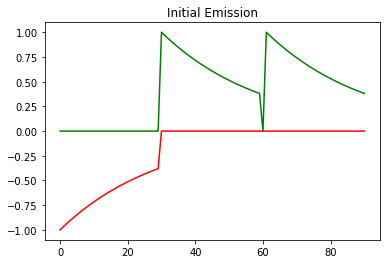

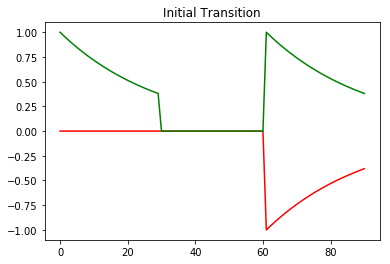

In [12]:
plt.figure()
plt.title("Initial Emission")
plt.plot(range(0, 91), estimator.emit_w_init_[0, 0, :], "-r")
plt.plot(range(0, 91), estimator.emit_w_init_[1, 0, :], "-g")
plt.show()

plt.figure()
plt.title("Initial Transition")
plt.plot(range(0, 91), estimator.trans_w_init_[0, 1, :], "-r")
plt.plot(range(0, 91), estimator.trans_w_init_[1, 0, :], "-g")
plt.show()

## The final emission and transtion matrices

The output is a dictionary which has many useful varaiables generated through consecutive iterations of the EM algorithm of the 'fit' method. Here, we plot the final emission and transition matrices which must be compared with the initial ones and also with filters plots:

In [13]:
emit_w_final = output[-1]['emit_w']
trans_w_final = output[-1]['trans_w']

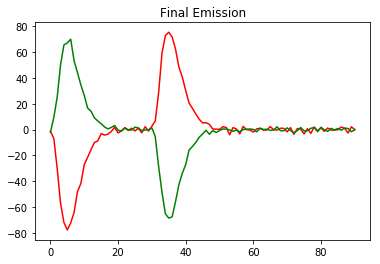

In [14]:
plt.figure()
plt.title("Final Emission")
plt.plot(range(0, 91), emit_w_final[0, 0, :], "-r")
plt.plot(range(0, 91), emit_w_final[1, 0, :], "-g")
plt.show()

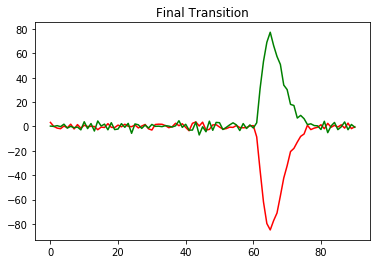

In [15]:
plt.figure()
plt.title("Final Transition")
plt.plot(range(0, 91), trans_w_final[0, 1, :], "-r")
plt.plot(range(0, 91), trans_w_final[1, 0, :], "-g")
plt.show()

## Another similar example with num_sample = 5

In [16]:
num_samples = 5
num_states = 2
num_emissions = 2
num_feedbacks = 3
num_filter_bins = 30
num_steps = 1
filter_offset = 1
    
tau = 4
total_time = 10000
noiseSD = 0.1
stim_scale = 1
num_real_states = 2
    
stim = []
states = []
output_stim = []
output_symb = []
    
for ns in range(0, num_samples):
    output = np.zeros((num_real_states, total_time))
    
    stim_temp = np.zeros((num_filter_bins, total_time + num_filter_bins - 1, num_feedbacks))
    stim_temp[0, :, :] = scipy.ndimage.filters.gaussian_filter(np.random.randn(total_time + num_filter_bins - 1, num_feedbacks), stim_scale)
    
    for i in range(1, num_filter_bins):
        stim_temp[i, 0:total_time, :] = stim_temp[0, i:(total_time + i), :]
        
    stim.append(stim_temp[:, 0:total_time, :] + np.random.randn(num_filter_bins, total_time, num_feedbacks) * noiseSD)
        
    final_stim = np.append(stim[ns][:, :, 0], stim[ns][:, :, 1], axis = 0)
    final_stim = np.append(final_stim, stim[ns][:, :, 2], axis = 0)
    final_stim = np.append(final_stim, np.ones((filter_offset, total_time)), axis = 0)
    output_stim.append(final_stim)
        
    filt = scipy.stats.gamma.pdf(np.linspace(0, num_filter_bins), a = tau)[0:num_filter_bins]
    
    p1 = np.exp(np.matmul(stim[ns][:, :, 0].T, filt.T) + np.matmul(stim[ns][:, :, 1].T, -filt.T))
    output[0, :] = p1 / (1 + p1) > 0.5
    p2 = np.exp(np.matmul(stim[ns][:, :, 0].T, -filt.T) + np.matmul(stim[ns][:, :, 1].T, filt.T))
    output[1, :] = p2 / (1 + p2) > 0.5
    
    p3 = np.exp(np.matmul(stim[ns][:, :, 2].T, filt.T))
    states.append(p3 / (1 + p3) > 0.5)
    
    output_symb.append(np.zeros(total_time))
    for ss in range(0, num_real_states):
        output_symb[ns][states[ns] == ss] = output[ss][states[ns] == ss]
    
estimator = GLMHMMEstimator(num_samples = num_samples, num_states = num_states, num_emissions = num_emissions, num_feedbacks = num_feedbacks, num_filter_bins = num_filter_bins, num_steps = num_steps, filter_offset = filter_offset)
output = estimator.fit(output_stim, output_symb, [])

Fitting iteration:   1
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  3.374e-01  |  3.910e-02  |  6.919e-02  |  2.000e+00  |  1.000e+01  
  2.000e+00  |  2.602e-01  |  3.072e-02  |  5.388e-01  |  2.000e+00  |  5.836e-01  
  3.000e+00  |  2.527e-01  |  1.817e-02  |  1.655e-01  |  2.000e+00  |  3.915e-01  
  4.000e+00  |  2.500e-01  |  6.139e-03  |  6.875e-02  |  1.000e+00  |  1.000e+00  
  5.000e+00  |  2.495e-01  |  4.146e-03  |  5.338e-02  |  1.000e+00  |  1.000e+00  
  6.000e+00  |  2.493e-01  |  2.800e-03  |  4.205e-02  |  1.000e+00  |  1.000e+00  
  7.000e+00  |  2.491e-01  |  1.714e-03  |  2.570e-02  |  1.000e+00  |  1.000e+00  
  8.000e+00  |  2.490e-01  |  1.817e-03  |  3.034e-02  |  1.000e+00  |  1.000e+00  
  9.000e+00  |  2.488e-01  |  2.137e-03  |  7.402e-02  |  1.000e+00

  1.600e+01  |  3.025e-01  |  3.623e-04  |  5.641e-03  |  1.000e+00  |  1.000e+00  
  1.700e+01  |  3.025e-01  |  3.390e-04  |  8.235e-03  |  1.000e+00  |  1.000e+00  
  1.800e+01  |  3.025e-01  |  3.871e-04  |  2.869e-03  |  2.000e+00  |  2.062e-01  
  1.900e+01  |  3.025e-01  |  1.441e-04  |  6.089e-03  |  1.000e+00  |  1.000e+00  
  2.000e+01  |  3.025e-01  |  8.348e-05  |  1.642e-03  |  1.000e+00  |  1.000e+00  
  2.100e+01  |  3.025e-01  |  9.466e-05  |  1.725e-03  |  1.000e+00  |  1.000e+00  
  2.200e+01  |  3.025e-01  |  7.879e-05  |  1.811e-03  |  1.000e+00  |  1.000e+00  
  2.300e+01  |  3.025e-01  |  9.551e-05  |  1.220e-03  |  2.000e+00  |  4.445e-01  
  2.400e+01  |  3.025e-01  |  3.856e-05  |  1.240e-03  |  1.000e+00  |  1.000e+00  
  2.500e+01  |  3.025e-01  |  3.490e-05  |  4.537e-04  |  1.000e+00  |  1.000e+00  
  2.600e+01  |  3.025e-01  |  3.797e-05  |  8.748e-04  |  1.000e+00  |  1.000e+00  
  2.700e+01  |  3.025e-01  |  3.843e-05  |  9.614e-04  |  1.000e+00  |  1.00

  1.000e+01  |  2.352e-01  |  2.864e-04  |  8.326e-03  |  1.000e+00  |  1.000e+00  
  1.100e+01  |  2.352e-01  |  5.247e-04  |  1.895e-02  |  1.000e+00  |  1.000e+00  
  1.200e+01  |  2.352e-01  |  1.428e-04  |  3.512e-03  |  1.000e+00  |  1.000e+00  
  1.300e+01  |  2.352e-01  |  1.273e-04  |  1.847e-03  |  1.000e+00  |  1.000e+00  
  1.400e+01  |  2.352e-01  |  1.419e-04  |  6.151e-03  |  1.000e+00  |  1.000e+00  
  1.500e+01  |  2.352e-01  |  4.092e-04  |  1.238e-02  |  1.000e+00  |  1.000e+00  
  1.600e+01  |  2.352e-01  |  1.362e-04  |  2.589e-03  |  1.000e+00  |  1.000e+00  
  1.700e+01  |  2.352e-01  |  9.185e-05  |  3.045e-03  |  1.000e+00  |  1.000e+00  
  1.800e+01  |  2.352e-01  |  1.050e-04  |  5.896e-03  |  1.000e+00  |  1.000e+00  
  1.900e+01  |  2.352e-01  |  8.129e-05  |  7.012e-03  |  1.000e+00  |  1.000e+00  
  2.000e+01  |  2.352e-01  |  1.647e-04  |  6.487e-03  |  1.000e+00  |  1.000e+00  
  2.100e+01  |  2.352e-01  |  4.495e-05  |  1.320e-03  |  1.000e+00  |  1.00

  8.000e+00  |  3.205e-01  |  1.039e-03  |  6.003e-02  |  1.000e+00  |  1.000e+00  
  9.000e+00  |  3.205e-01  |  6.566e-04  |  1.048e-02  |  2.000e+00  |  3.856e-01  
  1.000e+01  |  3.205e-01  |  1.781e-04  |  3.658e-03  |  1.000e+00  |  1.000e+00  
  1.100e+01  |  3.205e-01  |  1.121e-04  |  1.624e-03  |  1.000e+00  |  1.000e+00  
  1.200e+01  |  3.205e-01  |  1.207e-04  |  1.353e-03  |  1.000e+00  |  1.000e+00  
  1.300e+01  |  3.205e-01  |  1.433e-04  |  3.553e-03  |  1.000e+00  |  1.000e+00  
  1.400e+01  |  3.205e-01  |  2.346e-04  |  6.236e-03  |  1.000e+00  |  1.000e+00  
  1.500e+01  |  3.205e-01  |  1.142e-04  |  4.394e-03  |  1.000e+00  |  1.000e+00  
  1.600e+01  |  3.205e-01  |  8.359e-05  |  3.106e-03  |  1.000e+00  |  1.000e+00  
  1.700e+01  |  3.205e-01  |  8.900e-05  |  3.355e-03  |  1.000e+00  |  1.000e+00  
  1.800e+01  |  3.205e-01  |  1.407e-04  |  3.785e-03  |  1.000e+00  |  1.000e+00  
  1.900e+01  |  3.205e-01  |  4.294e-05  |  6.992e-04  |  1.000e+00  |  1.00

  1.000e+01  |  2.044e-01  |  6.775e-04  |  1.204e-02  |  1.000e+00  |  1.000e+00  
  1.100e+01  |  2.044e-01  |  1.575e-04  |  9.932e-03  |  1.000e+00  |  1.000e+00  
  1.200e+01  |  2.044e-01  |  9.221e-05  |  8.284e-04  |  1.000e+00  |  1.000e+00  
  1.300e+01  |  2.044e-01  |  1.029e-04  |  1.782e-03  |  1.000e+00  |  1.000e+00  
  1.400e+01  |  2.044e-01  |  1.202e-04  |  1.979e-03  |  1.000e+00  |  1.000e+00  
  1.500e+01  |  2.044e-01  |  2.121e-04  |  5.421e-03  |  1.000e+00  |  1.000e+00  
  1.600e+01  |  2.044e-01  |  9.501e-05  |  3.496e-03  |  1.000e+00  |  1.000e+00  
  1.700e+01  |  2.044e-01  |  5.706e-05  |  7.787e-04  |  1.000e+00  |  1.000e+00  
  1.800e+01  |  2.044e-01  |  6.017e-05  |  1.486e-03  |  1.000e+00  |  1.000e+00  
  1.900e+01  |  2.044e-01  |  7.017e-05  |  1.778e-03  |  1.000e+00  |  1.000e+00  
  2.000e+01  |  2.044e-01  |  7.009e-05  |  2.708e-03  |  1.000e+00  |  1.000e+00  
  2.100e+01  |  2.044e-01  |  2.164e-05  |  4.385e-04  |  1.000e+00  |  1.00

  1.100e+01  |  2.971e-01  |  1.658e-04  |  1.536e-03  |  1.000e+00  |  1.000e+00  
  1.200e+01  |  2.971e-01  |  1.952e-04  |  8.351e-04  |  1.000e+00  |  1.000e+00  
  1.300e+01  |  2.971e-01  |  2.151e-04  |  2.199e-03  |  1.000e+00  |  1.000e+00  
  1.400e+01  |  2.971e-01  |  1.680e-04  |  2.973e-03  |  1.000e+00  |  1.000e+00  
  1.500e+01  |  2.971e-01  |  1.552e-04  |  2.197e-03  |  2.000e+00  |  5.197e-01  
  1.600e+01  |  2.971e-01  |  9.538e-05  |  1.630e-03  |  1.000e+00  |  1.000e+00  
  1.700e+01  |  2.971e-01  |  1.153e-04  |  1.241e-03  |  1.000e+00  |  1.000e+00  
  1.800e+01  |  2.971e-01  |  1.170e-04  |  2.167e-03  |  1.000e+00  |  1.000e+00  
  1.900e+01  |  2.971e-01  |  1.116e-04  |  1.351e-03  |  2.000e+00  |  4.187e-01  
  2.000e+01  |  2.971e-01  |  4.051e-05  |  1.128e-03  |  1.000e+00  |  1.000e+00  
  2.100e+01  |  2.971e-01  |  3.018e-05  |  4.084e-04  |  1.000e+00  |  1.000e+00  
  2.200e+01  |  2.971e-01  |  3.353e-05  |  3.031e-04  |  1.000e+00  |  1.00

  1.100e+01  |  1.429e-01  |  1.530e-04  |  7.749e-03  |  1.000e+00  |  1.000e+00  
  1.200e+01  |  1.429e-01  |  1.480e-04  |  3.468e-03  |  1.000e+00  |  1.000e+00  
  1.300e+01  |  1.429e-01  |  1.358e-04  |  3.417e-03  |  1.000e+00  |  1.000e+00  
  1.400e+01  |  1.429e-01  |  2.175e-04  |  7.960e-03  |  1.000e+00  |  1.000e+00  
  1.500e+01  |  1.429e-01  |  2.296e-04  |  8.950e-03  |  1.000e+00  |  1.000e+00  
  1.600e+01  |  1.429e-01  |  1.018e-04  |  2.715e-03  |  1.000e+00  |  1.000e+00  
  1.700e+01  |  1.429e-01  |  9.526e-05  |  3.502e-03  |  1.000e+00  |  1.000e+00  
  1.800e+01  |  1.429e-01  |  1.005e-04  |  4.456e-03  |  1.000e+00  |  1.000e+00  
  1.900e+01  |  1.429e-01  |  1.010e-04  |  2.549e-03  |  2.000e+00  |  3.548e-01  
  2.000e+01  |  1.429e-01  |  4.014e-05  |  2.668e-03  |  1.000e+00  |  1.000e+00  
  2.100e+01  |  1.429e-01  |  3.200e-05  |  1.125e-03  |  1.000e+00  |  1.000e+00  
  2.200e+01  |  1.429e-01  |  3.668e-05  |  1.203e-03  |  1.000e+00  |  1.00

  6.000e+00  |  3.159e-01  |  1.157e-03  |  7.143e-02  |  1.000e+00  |  1.000e+00  
  7.000e+00  |  3.159e-01  |  1.183e-03  |  7.177e-02  |  1.000e+00  |  1.000e+00  
  8.000e+00  |  3.159e-01  |  1.163e-03  |  3.102e-02  |  2.000e+00  |  3.684e-01  
  9.000e+00  |  3.159e-01  |  6.041e-04  |  4.229e-02  |  1.000e+00  |  1.000e+00  
  1.000e+01  |  3.159e-01  |  1.434e-04  |  6.792e-03  |  1.000e+00  |  1.000e+00  
  1.100e+01  |  3.159e-01  |  9.721e-05  |  1.731e-03  |  1.000e+00  |  1.000e+00  
  1.200e+01  |  3.159e-01  |  1.098e-04  |  2.474e-03  |  1.000e+00  |  1.000e+00  
  1.300e+01  |  3.159e-01  |  1.467e-04  |  5.642e-03  |  1.000e+00  |  1.000e+00  
  1.400e+01  |  3.159e-01  |  1.780e-04  |  9.699e-03  |  1.000e+00  |  1.000e+00  
  1.500e+01  |  3.159e-01  |  1.096e-04  |  7.775e-03  |  1.000e+00  |  1.000e+00  
  1.600e+01  |  3.159e-01  |  8.555e-05  |  3.615e-03  |  1.000e+00  |  1.000e+00  
  1.700e+01  |  3.159e-01  |  7.828e-05  |  2.956e-03  |  1.000e+00  |  1.00

  7.000e+00  |  2.413e-01  |  7.104e-04  |  1.543e-02  |  1.000e+00  |  1.000e+00  
  8.000e+00  |  2.412e-01  |  8.209e-04  |  1.061e-02  |  2.000e+00  |  4.075e-01  
  9.000e+00  |  2.412e-01  |  3.248e-04  |  9.065e-03  |  1.000e+00  |  1.000e+00  
  1.000e+01  |  2.412e-01  |  2.071e-04  |  3.798e-03  |  1.000e+00  |  1.000e+00  
  1.100e+01  |  2.412e-01  |  2.196e-04  |  3.133e-03  |  1.000e+00  |  1.000e+00  
  1.200e+01  |  2.412e-01  |  3.065e-04  |  4.764e-03  |  1.000e+00  |  1.000e+00  
  1.300e+01  |  2.412e-01  |  1.202e-04  |  1.982e-03  |  1.000e+00  |  1.000e+00  
  1.400e+01  |  2.412e-01  |  9.583e-05  |  8.793e-04  |  1.000e+00  |  1.000e+00  
  1.500e+01  |  2.412e-01  |  1.041e-04  |  1.761e-03  |  1.000e+00  |  1.000e+00  
  1.600e+01  |  2.412e-01  |  1.565e-04  |  2.703e-03  |  1.000e+00  |  1.000e+00  
  1.700e+01  |  2.412e-01  |  6.946e-05  |  1.183e-03  |  1.000e+00  |  1.000e+00  
  1.800e+01  |  2.412e-01  |  5.956e-05  |  1.047e-03  |  1.000e+00  |  1.00

  4.000e+00  |  2.531e-01  |  1.063e-03  |  5.224e-03  |  1.000e+00  |  1.000e+00  
  5.000e+00  |  2.531e-01  |  7.382e-04  |  1.511e-03  |  1.000e+00  |  1.000e+00  
  6.000e+00  |  2.531e-01  |  6.627e-04  |  6.095e-03  |  1.000e+00  |  1.000e+00  
  7.000e+00  |  2.531e-01  |  1.114e-03  |  1.343e-02  |  1.000e+00  |  1.000e+00  
  8.000e+00  |  2.530e-01  |  1.126e-03  |  2.100e-02  |  1.000e+00  |  1.000e+00  
  9.000e+00  |  2.530e-01  |  1.249e-03  |  9.012e-03  |  2.000e+00  |  3.302e-01  
  1.000e+01  |  2.530e-01  |  4.520e-04  |  1.436e-02  |  1.000e+00  |  1.000e+00  
  1.100e+01  |  2.530e-01  |  1.706e-04  |  2.023e-03  |  1.000e+00  |  1.000e+00  
  1.200e+01  |  2.530e-01  |  1.096e-04  |  1.018e-03  |  1.000e+00  |  1.000e+00  
  1.300e+01  |  2.530e-01  |  1.284e-04  |  6.478e-04  |  1.000e+00  |  1.000e+00  
  1.400e+01  |  2.530e-01  |  1.540e-04  |  2.359e-03  |  1.000e+00  |  1.000e+00  
  1.500e+01  |  2.530e-01  |  1.513e-04  |  1.266e-03  |  2.000e+00  |  4.48

  5.000e+00  |  1.121e-01  |  7.458e-04  |  7.927e-03  |  1.000e+00  |  1.000e+00  
  6.000e+00  |  1.121e-01  |  1.073e-03  |  1.632e-02  |  1.000e+00  |  1.000e+00  
  7.000e+00  |  1.120e-01  |  1.720e-03  |  3.248e-02  |  1.000e+00  |  1.000e+00  
  8.000e+00  |  1.120e-01  |  9.416e-04  |  3.166e-02  |  1.000e+00  |  1.000e+00  
  9.000e+00  |  1.119e-01  |  4.093e-04  |  9.025e-03  |  1.000e+00  |  1.000e+00  
  1.000e+01  |  1.119e-01  |  3.152e-04  |  5.181e-03  |  1.000e+00  |  1.000e+00  
  1.100e+01  |  1.119e-01  |  2.216e-04  |  1.691e-03  |  1.000e+00  |  1.000e+00  
  1.200e+01  |  1.119e-01  |  1.424e-04  |  8.299e-04  |  1.000e+00  |  1.000e+00  
  1.300e+01  |  1.119e-01  |  9.201e-05  |  2.566e-03  |  1.000e+00  |  1.000e+00  
  1.400e+01  |  1.119e-01  |  8.096e-05  |  9.886e-04  |  1.000e+00  |  1.000e+00  
  1.500e+01  |  1.119e-01  |  4.972e-05  |  1.416e-03  |  1.000e+00  |  1.000e+00  
  1.600e+01  |  1.119e-01  |  4.946e-05  |  8.629e-04  |  1.000e+00  |  1.00

  4.000e+00  |  2.563e-01  |  2.987e-03  |  3.532e-02  |  1.000e+00  |  1.000e+00  
  5.000e+00  |  2.562e-01  |  3.971e-04  |  1.883e-02  |  1.000e+00  |  1.000e+00  
  6.000e+00  |  2.562e-01  |  3.310e-04  |  2.172e-03  |  1.000e+00  |  1.000e+00  
  7.000e+00  |  2.562e-01  |  3.302e-04  |  1.420e-02  |  1.000e+00  |  1.000e+00  
  8.000e+00  |  2.562e-01  |  4.555e-04  |  1.320e-02  |  1.000e+00  |  1.000e+00  
  9.000e+00  |  2.562e-01  |  3.650e-04  |  2.572e-02  |  1.000e+00  |  1.000e+00  
  1.000e+01  |  2.562e-01  |  5.988e-04  |  2.027e-02  |  1.000e+00  |  1.000e+00  
  1.100e+01  |  2.562e-01  |  1.597e-04  |  5.107e-03  |  1.000e+00  |  1.000e+00  
  1.200e+01  |  2.562e-01  |  1.202e-04  |  2.092e-03  |  1.000e+00  |  1.000e+00  
  1.300e+01  |  2.562e-01  |  1.272e-04  |  4.848e-03  |  1.000e+00  |  1.000e+00  
  1.400e+01  |  2.562e-01  |  2.770e-04  |  7.692e-03  |  1.000e+00  |  1.000e+00  
  1.500e+01  |  2.562e-01  |  8.099e-05  |  2.824e-03  |  1.000e+00  |  1.00

  5.000e+00  |  2.665e-01  |  7.312e-04  |  1.956e-03  |  1.000e+00  |  1.000e+00  
  6.000e+00  |  2.665e-01  |  7.014e-04  |  7.703e-03  |  1.000e+00  |  1.000e+00  
  7.000e+00  |  2.664e-01  |  1.082e-03  |  1.411e-02  |  1.000e+00  |  1.000e+00  
  8.000e+00  |  2.664e-01  |  1.030e-03  |  2.291e-02  |  1.000e+00  |  1.000e+00  
  9.000e+00  |  2.664e-01  |  9.970e-04  |  7.962e-03  |  2.000e+00  |  2.649e-01  
  1.000e+01  |  2.664e-01  |  3.410e-04  |  1.143e-02  |  1.000e+00  |  1.000e+00  
  1.100e+01  |  2.664e-01  |  1.664e-04  |  1.833e-03  |  1.000e+00  |  1.000e+00  
  1.200e+01  |  2.664e-01  |  1.764e-04  |  1.360e-03  |  1.000e+00  |  1.000e+00  
  1.300e+01  |  2.664e-01  |  1.822e-04  |  2.861e-03  |  1.000e+00  |  1.000e+00  
  1.400e+01  |  2.664e-01  |  2.265e-04  |  1.838e-03  |  2.000e+00  |  3.918e-01  
  1.500e+01  |  2.664e-01  |  1.057e-04  |  2.385e-03  |  1.000e+00  |  1.000e+00  
  1.600e+01  |  2.664e-01  |  7.520e-05  |  1.625e-03  |  1.000e+00  |  1.00

  4.000e+00  |  1.970e-01  |  1.871e-03  |  2.877e-02  |  1.000e+00  |  1.000e+00  
  5.000e+00  |  1.969e-01  |  1.658e-03  |  1.040e-02  |  1.000e+00  |  1.000e+00  
  6.000e+00  |  1.969e-01  |  8.804e-04  |  2.951e-03  |  1.000e+00  |  1.000e+00  
  7.000e+00  |  1.969e-01  |  8.912e-04  |  5.353e-03  |  1.000e+00  |  1.000e+00  
  8.000e+00  |  1.968e-01  |  1.606e-03  |  1.780e-02  |  1.000e+00  |  1.000e+00  
  9.000e+00  |  1.967e-01  |  1.804e-03  |  2.926e-02  |  1.000e+00  |  1.000e+00  
  1.000e+01  |  1.967e-01  |  1.797e-03  |  3.602e-02  |  1.000e+00  |  1.000e+00  
  1.100e+01  |  1.967e-01  |  1.076e-03  |  9.270e-03  |  1.000e+00  |  1.000e+00  
  1.200e+01  |  1.967e-01  |  3.293e-04  |  8.170e-03  |  1.000e+00  |  1.000e+00  
  1.300e+01  |  1.967e-01  |  1.337e-04  |  9.769e-04  |  1.000e+00  |  1.000e+00  
  1.400e+01  |  1.967e-01  |  9.036e-05  |  1.199e-03  |  1.000e+00  |  1.000e+00  
  1.500e+01  |  1.967e-01  |  1.075e-04  |  7.439e-04  |  1.000e+00  |  1.00

  2.000e+00  |  1.008e-01  |  5.982e-03  |  3.301e-02  |  1.000e+00  |  1.000e+00  
  3.000e+00  |  9.953e-02  |  4.722e-03  |  2.938e-02  |  1.000e+00  |  1.000e+00  
  4.000e+00  |  9.897e-02  |  9.645e-04  |  2.710e-02  |  1.000e+00  |  1.000e+00  
  5.000e+00  |  9.895e-02  |  3.602e-04  |  3.653e-03  |  1.000e+00  |  1.000e+00  
  6.000e+00  |  9.894e-02  |  2.468e-04  |  1.474e-03  |  1.000e+00  |  1.000e+00  
  7.000e+00  |  9.893e-02  |  1.903e-04  |  3.494e-03  |  1.000e+00  |  1.000e+00  
  8.000e+00  |  9.893e-02  |  2.772e-04  |  2.879e-03  |  1.000e+00  |  1.000e+00  
  9.000e+00  |  9.893e-02  |  2.083e-04  |  2.763e-03  |  1.000e+00  |  1.000e+00  
  1.000e+01  |  9.892e-02  |  2.085e-04  |  7.761e-03  |  1.000e+00  |  1.000e+00  
  1.100e+01  |  9.892e-02  |  3.176e-04  |  7.952e-03  |  1.000e+00  |  1.000e+00  
  1.200e+01  |  9.891e-02  |  1.331e-04  |  3.913e-03  |  1.000e+00  |  1.000e+00  
  1.300e+01  |  9.891e-02  |  7.133e-05  |  1.493e-03  |  1.000e+00  |  1.00

Log likelihood: 32876.470553637984
Fitting iteration:   12
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.344e-01  |  1.157e-02  |  2.971e-02  |  2.000e+00  |  1.000e+01  
  2.000e+00  |  1.270e-01  |  8.567e-03  |  1.905e-01  |  1.000e+00  |  1.000e+00  
  3.000e+00  |  1.210e-01  |  6.183e-03  |  2.172e-01  |  1.000e+00  |  1.000e+00  
  4.000e+00  |  1.199e-01  |  6.990e-03  |  7.715e-02  |  2.000e+00  |  2.511e-01  
  5.000e+00  |  1.180e-01  |  1.967e-03  |  1.238e-01  |  1.000e+00  |  1.000e+00  
  6.000e+00  |  1.178e-01  |  2.153e-03  |  5.147e-02  |  1.000e+00  |  1.000e+00  
  7.000e+00  |  1.178e-01  |  9.500e-04  |  2.125e-02  |  1.000e+00  |  1.000e+00  
  8.000e+00  |  1.178e-01  |  6.348e-04  |  5.495e-03  |  1.000e+00  |  1.000e+00  
  9.000e+00  |  1.177e-01  |  7

  2.000e+01  |  1.264e-01  |  8.038e-05  |  1.332e-03  |  1.000e+00  |  1.000e+00  
  2.100e+01  |  1.264e-01  |  6.686e-05  |  6.792e-04  |  1.000e+00  |  1.000e+00  
  2.200e+01  |  1.264e-01  |  8.393e-05  |  8.647e-04  |  1.000e+00  |  1.000e+00  
  2.300e+01  |  1.264e-01  |  7.995e-05  |  1.278e-03  |  1.000e+00  |  1.000e+00  
  2.400e+01  |  1.264e-01  |  7.337e-05  |  7.351e-04  |  2.000e+00  |  3.569e-01  
  2.500e+01  |  1.264e-01  |  2.887e-05  |  7.518e-04  |  1.000e+00  |  1.000e+00  
  2.600e+01  |  1.264e-01  |  2.675e-05  |  3.460e-04  |  1.000e+00  |  1.000e+00  
  2.700e+01  |  1.264e-01  |  3.075e-05  |  3.845e-04  |  1.000e+00  |  1.000e+00  
  2.800e+01  |  1.264e-01  |  2.290e-05  |  5.570e-04  |  1.000e+00  |  1.000e+00  
  2.900e+01  |  1.264e-01  |  4.227e-05  |  7.322e-04  |  1.000e+00  |  1.000e+00  
  3.000e+01  |  1.264e-01  |  1.048e-05  |  1.688e-04  |  1.000e+00  |  1.000e+00  
  3.100e+01  |  1.264e-01  |  9.152e-06  |  8.493e-05  |  1.000e+00  |  1.00

-----------------------------------------------------------------------------------
  1.000e+00  |  7.310e-02  |  1.081e-02  |  1.087e-02  |  2.000e+00  |  1.000e+01  
  2.000e+00  |  6.979e-02  |  6.283e-03  |  3.587e-02  |  1.000e+00  |  1.000e+00  
  3.000e+00  |  6.806e-02  |  6.953e-03  |  2.997e-02  |  1.000e+00  |  1.000e+00  
  4.000e+00  |  6.473e-02  |  5.423e-03  |  8.155e-02  |  1.000e+00  |  1.000e+00  
  5.000e+00  |  6.316e-02  |  3.495e-03  |  7.556e-02  |  1.000e+00  |  1.000e+00  
  6.000e+00  |  6.279e-02  |  2.090e-03  |  4.607e-02  |  1.000e+00  |  1.000e+00  
  7.000e+00  |  6.267e-02  |  4.850e-04  |  8.566e-03  |  1.000e+00  |  1.000e+00  
  8.000e+00  |  6.265e-02  |  3.894e-04  |  2.521e-03  |  1.000e+00  |  1.000e+00  
  9.000e+00  |  6.263e-02  |  4.063e-04  |  6.424e-03  |  1.000e+00  |  1.000e+00  
  1.000e+01  |  6.260e-02  |  4.847e-04  |  1.008e-02  |  1.000e+00  |  1.000e+00  
  1.100e+01  |  6.255e-02  |  7.150e-04  |  2.880e-02  |  1.000e+00  |  1.00

  2.200e+01  |  1.070e-01  |  1.635e-04  |  2.057e-03  |  1.000e+00  |  1.000e+00  
  2.300e+01  |  1.070e-01  |  1.246e-04  |  2.960e-03  |  1.000e+00  |  1.000e+00  
  2.400e+01  |  1.070e-01  |  1.243e-04  |  1.311e-03  |  2.000e+00  |  3.509e-01  
  2.500e+01  |  1.070e-01  |  6.125e-05  |  1.366e-03  |  1.000e+00  |  1.000e+00  
  2.600e+01  |  1.070e-01  |  6.428e-05  |  7.047e-04  |  1.000e+00  |  1.000e+00  
  2.700e+01  |  1.070e-01  |  6.591e-05  |  1.142e-03  |  1.000e+00  |  1.000e+00  
  2.800e+01  |  1.070e-01  |  9.498e-05  |  1.432e-03  |  1.000e+00  |  1.000e+00  
  2.900e+01  |  1.070e-01  |  2.978e-05  |  8.838e-04  |  1.000e+00  |  1.000e+00  
  3.000e+01  |  1.070e-01  |  2.386e-05  |  2.633e-04  |  1.000e+00  |  1.000e+00  
  3.100e+01  |  1.070e-01  |  2.360e-05  |  4.578e-04  |  1.000e+00  |  1.000e+00  
  3.200e+01  |  1.070e-01  |  2.307e-05  |  2.580e-04  |  2.000e+00  |  4.334e-01  
  3.300e+01  |  1.070e-01  |  1.162e-05  |  2.072e-04  |  1.000e+00  |  1.00

    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  6.155e-02  |  3.060e-03  |  1.677e-03  |  2.000e+00  |  1.000e+01  
  2.000e+00  |  6.110e-02  |  1.962e-03  |  1.126e-02  |  1.000e+00  |  1.000e+00  
  3.000e+00  |  6.087e-02  |  2.336e-03  |  8.647e-03  |  1.000e+00  |  1.000e+00  
  4.000e+00  |  6.008e-02  |  2.743e-03  |  3.731e-02  |  1.000e+00  |  1.000e+00  
  5.000e+00  |  5.948e-02  |  4.492e-03  |  5.095e-02  |  1.000e+00  |  1.000e+00  
  6.000e+00  |  5.868e-02  |  2.166e-03  |  4.919e-02  |  1.000e+00  |  1.000e+00  
  7.000e+00  |  5.807e-02  |  1.952e-03  |  3.881e-02  |  1.000e+00  |  1.000e+00  
  8.000e+00  |  5.692e-02  |  3.442e-03  |  8.789e-02  |  1.000e+00  |  1.000e+00  
  9.000e+00  |  5.572e-02  |  4.227e-03  |  1.091e-01  |  1.000e+00  |  1.000e+00  
  1.000e+01  |  5.486e-02  |  4.845e-03  |  1.712e-01  |  1.000e+00  |  1.00

  6.000e+00  |  2.634e-02  |  1.984e-03  |  1.991e-02  |  4.000e+00  |  5.505e+02  
  7.000e+00  |  2.631e-02  |  1.756e-03  |  7.723e-04  |  2.000e+00  |  1.000e+01  
  8.000e+00  |  2.612e-02  |  8.476e-04  |  7.329e-03  |  1.000e+00  |  1.000e+00  
  9.000e+00  |  2.605e-02  |  1.042e-03  |  4.296e-03  |  1.000e+00  |  1.000e+00  
  1.000e+01  |  2.554e-02  |  2.458e-03  |  3.959e-02  |  1.000e+00  |  1.000e+00  
  1.100e+01  |  2.489e-02  |  3.226e-03  |  6.122e-02  |  1.000e+00  |  1.000e+00  
  1.200e+01  |  2.402e-02  |  2.672e-03  |  9.484e-02  |  1.000e+00  |  1.000e+00  
  1.300e+01  |  2.366e-02  |  1.802e-03  |  7.862e-02  |  1.000e+00  |  1.000e+00  
  1.400e+01  |  2.337e-02  |  6.382e-04  |  1.848e-02  |  1.000e+00  |  1.000e+00  
  1.500e+01  |  2.327e-02  |  6.043e-04  |  9.059e-03  |  1.000e+00  |  1.000e+00  
  1.600e+01  |  2.318e-02  |  1.038e-03  |  1.420e-02  |  1.000e+00  |  1.000e+00  
  1.700e+01  |  2.301e-02  |  1.488e-03  |  3.000e-02  |  1.000e+00  |  1.00

  1.500e+01  |  2.788e-02  |  1.285e-03  |  3.061e-02  |  1.000e+00  |  1.000e+00  
  1.600e+01  |  2.745e-02  |  2.407e-03  |  7.443e-02  |  1.000e+00  |  1.000e+00  
  1.700e+01  |  2.688e-02  |  1.031e-03  |  4.938e-02  |  1.000e+00  |  1.000e+00  
  1.800e+01  |  2.663e-02  |  5.830e-04  |  3.837e-02  |  1.000e+00  |  1.000e+00  
  1.900e+01  |  2.648e-02  |  6.175e-04  |  3.948e-02  |  1.000e+00  |  1.000e+00  
  2.000e+01  |  2.638e-02  |  7.940e-04  |  3.401e-02  |  1.000e+00  |  1.000e+00  
  2.100e+01  |  2.629e-02  |  4.836e-04  |  9.889e-03  |  1.000e+00  |  1.000e+00  
  2.200e+01  |  2.618e-02  |  3.870e-04  |  1.025e-02  |  1.000e+00  |  1.000e+00  
  2.300e+01  |  2.614e-02  |  5.613e-04  |  5.800e-03  |  1.000e+00  |  1.000e+00  
  2.400e+01  |  2.610e-02  |  3.282e-04  |  3.315e-03  |  1.000e+00  |  1.000e+00  
  2.500e+01  |  2.606e-02  |  1.942e-04  |  3.847e-03  |  1.000e+00  |  1.000e+00  
  2.600e+01  |  2.605e-02  |  1.614e-04  |  4.760e-03  |  1.000e+00  |  1.00

  2.000e+01  |  1.250e-02  |  5.748e-04  |  4.795e-03  |  4.000e+00  |  5.474e+02  
  2.100e+01  |  1.248e-02  |  3.554e-04  |  1.308e-03  |  3.000e+00  |  1.000e+02  
  2.200e+01  |  1.245e-02  |  3.488e-04  |  1.965e-03  |  4.000e+00  |  2.431e+02  
  2.300e+01  |  1.242e-02  |  3.533e-04  |  2.401e-03  |  4.000e+00  |  3.030e+02  
  2.400e+01  |  1.240e-02  |  3.295e-04  |  1.265e-03  |  4.000e+00  |  1.577e+02  
  2.500e+01  |  1.209e-02  |  9.792e-04  |  2.886e-02  |  5.000e+00  |  3.863e+03  
  2.600e+01  |  1.203e-02  |  3.219e-04  |  2.184e-03  |  3.000e+00  |  1.000e+02  
  2.700e+01  |  1.202e-02  |  2.805e-04  |  3.498e-04  |  3.000e+00  |  4.873e+01  
  2.800e+01  |  1.200e-02  |  4.777e-04  |  3.444e-03  |  4.000e+00  |  5.506e+02  
  2.900e+01  |  1.199e-02  |  3.636e-04  |  4.658e-04  |  3.000e+00  |  4.383e+01  
  3.000e+01  |  1.198e-02  |  2.612e-04  |  6.790e-04  |  3.000e+00  |  8.397e+01  
  3.100e+01  |  1.195e-02  |  3.851e-04  |  3.197e-03  |  4.000e+00  |  5.50

  1.170e+02  |  1.051e-02  |  2.347e-04  |  2.582e-04  |  3.000e+00  |  4.464e+01  
  1.180e+02  |  1.051e-02  |  1.767e-04  |  2.412e-04  |  3.000e+00  |  5.505e+01  
  1.190e+02  |  1.051e-02  |  1.334e-04  |  6.917e-04  |  4.000e+00  |  2.096e+02  
  1.200e+02  |  1.050e-02  |  1.296e-04  |  6.675e-04  |  4.000e+00  |  2.680e+02  
  1.210e+02  |  1.050e-02  |  1.234e-04  |  4.032e-04  |  4.000e+00  |  1.668e+02  
  1.220e+02  |  1.002e-02  |  1.155e-03  |  1.007e-01  |  7.000e+00  |  4.375e+04  
  1.230e+02  |  9.927e-03  |  4.633e-04  |  1.957e-03  |  3.000e+00  |  1.000e+02  
  1.240e+02  |  9.912e-03  |  2.029e-04  |  7.847e-04  |  3.000e+00  |  1.000e+02  
  1.250e+02  |  9.910e-03  |  1.754e-04  |  1.014e-04  |  3.000e+00  |  2.951e+01  
  1.260e+02  |  9.909e-03  |  1.371e-04  |  1.636e-04  |  3.000e+00  |  5.505e+01  
  1.270e+02  |  9.908e-03  |  1.160e-04  |  1.278e-04  |  3.000e+00  |  5.505e+01  
  1.280e+02  |  9.906e-03  |  9.579e-05  |  3.215e-04  |  4.000e+00  |  1.63

  2.140e+02  |  8.995e-03  |  6.208e-05  |  3.427e-04  |  4.000e+00  |  3.030e+02  
  2.150e+02  |  8.994e-03  |  1.085e-04  |  7.429e-04  |  5.000e+00  |  8.555e+02  
  2.160e+02  |  8.993e-03  |  8.473e-05  |  9.411e-05  |  4.000e+00  |  6.202e+01  
  2.170e+02  |  8.992e-03  |  6.730e-05  |  9.371e-05  |  4.000e+00  |  7.912e+01  
  2.180e+02  |  8.992e-03  |  5.700e-05  |  1.125e-04  |  4.000e+00  |  1.196e+02  
  2.190e+02  |  8.991e-03  |  5.961e-05  |  4.002e-04  |  5.000e+00  |  5.023e+02  
  2.200e+02  |  8.989e-03  |  7.143e-05  |  4.907e-04  |  6.000e+00  |  5.891e+02  
  2.210e+02  |  8.988e-03  |  6.019e-05  |  8.989e-05  |  4.000e+00  |  9.009e+01  
  2.220e+02  |  8.987e-03  |  6.407e-05  |  3.918e-04  |  6.000e+00  |  4.662e+02  
  2.230e+02  |  8.986e-03  |  5.559e-05  |  2.373e-04  |  5.000e+00  |  2.653e+02  
  2.240e+02  |  8.981e-03  |  1.105e-04  |  1.528e-03  |  5.000e+00  |  1.969e+03  
  2.250e+02  |  8.980e-03  |  5.922e-05  |  2.325e-04  |  4.000e+00  |  1.51

  2.600e+01  |  1.123e-02  |  3.554e-04  |  3.748e-04  |  3.000e+00  |  4.361e+01  
  2.700e+01  |  1.122e-02  |  3.266e-04  |  5.937e-04  |  3.000e+00  |  7.613e+01  
  2.800e+01  |  1.119e-02  |  3.180e-04  |  2.075e-03  |  4.000e+00  |  2.897e+02  
  2.900e+01  |  1.115e-02  |  3.270e-04  |  2.597e-03  |  4.000e+00  |  3.728e+02  
  3.000e+01  |  1.112e-02  |  4.719e-04  |  3.576e-03  |  4.000e+00  |  4.999e+02  
  3.100e+01  |  1.110e-02  |  3.077e-04  |  9.311e-04  |  3.000e+00  |  9.040e+01  
  3.200e+01  |  1.108e-02  |  3.187e-04  |  2.034e-03  |  4.000e+00  |  3.030e+02  
  3.300e+01  |  1.105e-02  |  5.627e-04  |  3.823e-03  |  4.000e+00  |  5.505e+02  
  3.400e+01  |  1.102e-02  |  2.896e-04  |  1.223e-03  |  3.000e+00  |  1.000e+02  
  3.500e+01  |  1.099e-02  |  3.782e-04  |  2.982e-03  |  4.000e+00  |  4.739e+02  
  3.600e+01  |  1.099e-02  |  3.276e-04  |  2.904e-04  |  3.000e+00  |  3.539e+01  
  3.700e+01  |  1.097e-02  |  3.784e-04  |  2.153e-03  |  4.000e+00  |  3.03

  1.230e+02  |  8.992e-03  |  1.244e-04  |  1.387e-04  |  3.000e+00  |  5.505e+01  
  1.240e+02  |  8.990e-03  |  1.009e-04  |  2.668e-04  |  4.000e+00  |  1.273e+02  
  1.250e+02  |  8.976e-03  |  1.901e-04  |  2.891e-03  |  5.000e+00  |  1.702e+03  
  1.260e+02  |  8.975e-03  |  1.676e-04  |  9.000e-05  |  3.000e+00  |  2.820e+01  
  1.270e+02  |  8.974e-03  |  1.489e-04  |  8.529e-05  |  3.000e+00  |  3.030e+01  
  1.280e+02  |  8.972e-03  |  1.012e-04  |  3.470e-04  |  4.000e+00  |  1.388e+02  
  1.290e+02  |  8.961e-03  |  1.621e-04  |  2.123e-03  |  5.000e+00  |  1.250e+03  
  1.300e+02  |  8.959e-03  |  1.191e-04  |  2.391e-04  |  4.000e+00  |  8.806e+01  
  1.310e+02  |  8.957e-03  |  9.856e-05  |  3.831e-04  |  4.000e+00  |  1.921e+02  
  1.320e+02  |  8.931e-03  |  2.035e-04  |  5.000e-03  |  5.000e+00  |  3.030e+03  
  1.330e+02  |  8.930e-03  |  1.689e-04  |  1.487e-04  |  3.000e+00  |  4.386e+01  
  1.340e+02  |  8.926e-03  |  1.041e-04  |  4.267e-04  |  4.000e+00  |  1.51

  2.200e+02  |  8.113e-03  |  6.187e-05  |  1.312e-04  |  4.000e+00  |  1.385e+02  
  2.210e+02  |  8.099e-03  |  1.797e-04  |  3.922e-03  |  6.000e+00  |  4.472e+03  
  2.220e+02  |  8.098e-03  |  1.498e-04  |  9.505e-05  |  3.000e+00  |  3.746e+01  
  2.230e+02  |  8.097e-03  |  1.309e-04  |  6.411e-05  |  3.000e+00  |  3.030e+01  
  2.240e+02  |  8.097e-03  |  1.123e-04  |  6.759e-05  |  3.000e+00  |  3.657e+01  
  2.250e+02  |  8.096e-03  |  9.198e-05  |  8.395e-05  |  4.000e+00  |  5.295e+01  
  2.260e+02  |  8.095e-03  |  6.772e-05  |  1.446e-04  |  4.000e+00  |  1.113e+02  
  2.270e+02  |  8.095e-03  |  6.211e-05  |  1.038e-04  |  4.000e+00  |  1.086e+02  
  2.280e+02  |  8.088e-03  |  1.971e-04  |  2.575e-03  |  6.000e+00  |  2.936e+03  
  2.290e+02  |  8.087e-03  |  1.732e-04  |  7.431e-05  |  3.000e+00  |  2.677e+01  
  2.300e+02  |  8.086e-03  |  1.502e-04  |  7.390e-05  |  3.000e+00  |  3.030e+01  
  2.310e+02  |  8.085e-03  |  1.312e-04  |  6.408e-05  |  3.000e+00  |  3.03

  3.170e+02  |  7.667e-03  |  8.539e-05  |  1.099e-04  |  3.000e+00  |  7.365e+01  
  3.180e+02  |  7.667e-03  |  5.998e-05  |  1.042e-04  |  4.000e+00  |  9.667e+01  
  3.190e+02  |  7.666e-03  |  4.311e-05  |  1.488e-04  |  4.000e+00  |  1.965e+02  
  3.200e+02  |  7.659e-03  |  1.167e-04  |  2.627e-03  |  5.000e+00  |  4.829e+03  
  3.210e+02  |  7.658e-03  |  8.207e-05  |  1.335e-04  |  4.000e+00  |  9.086e+01  
  3.220e+02  |  7.657e-03  |  5.737e-05  |  1.356e-04  |  4.000e+00  |  1.313e+02  
  3.230e+02  |  7.657e-03  |  4.869e-05  |  1.050e-04  |  4.000e+00  |  1.454e+02  
  3.240e+02  |  7.655e-03  |  5.053e-05  |  5.516e-04  |  5.000e+00  |  9.002e+02  
  3.250e+02  |  7.655e-03  |  4.442e-05  |  7.967e-05  |  4.000e+00  |  1.253e+02  
  3.260e+02  |  7.654e-03  |  5.127e-05  |  4.557e-04  |  5.000e+00  |  8.155e+02  
  3.270e+02  |  7.653e-03  |  4.960e-05  |  2.749e-04  |  5.000e+00  |  4.265e+02  
  3.280e+02  |  7.653e-03  |  4.399e-05  |  6.718e-05  |  4.000e+00  |  1.07

  4.140e+02  |  7.421e-03  |  3.287e-05  |  1.614e-04  |  5.000e+00  |  4.015e+02  
  4.150e+02  |  7.420e-03  |  3.192e-05  |  1.426e-04  |  6.000e+00  |  3.727e+02  
  4.160e+02  |  7.417e-03  |  1.025e-04  |  1.833e-03  |  6.000e+00  |  4.936e+03  
  4.170e+02  |  7.416e-03  |  9.007e-05  |  3.868e-05  |  3.000e+00  |  3.250e+01  
  4.180e+02  |  7.416e-03  |  4.481e-05  |  1.570e-04  |  4.000e+00  |  1.501e+02  
  4.190e+02  |  7.415e-03  |  3.895e-05  |  3.488e-05  |  5.000e+00  |  6.699e+01  
  4.200e+02  |  7.415e-03  |  3.491e-05  |  3.632e-05  |  4.000e+00  |  8.029e+01  
  4.210e+02  |  7.415e-03  |  3.162e-05  |  6.870e-05  |  5.000e+00  |  1.694e+02  
  4.220e+02  |  7.412e-03  |  7.983e-05  |  1.496e-03  |  6.000e+00  |  4.072e+03  
  4.230e+02  |  7.411e-03  |  4.997e-05  |  1.051e-04  |  4.000e+00  |  1.135e+02  
  4.240e+02  |  7.411e-03  |  4.471e-05  |  2.508e-05  |  3.000e+00  |  4.329e+01  
  4.250e+02  |  7.411e-03  |  3.869e-05  |  3.562e-05  |  4.000e+00  |  6.87

  6.800e+01  |  1.303e-02  |  2.324e-04  |  4.293e-03  |  5.000e+00  |  3.202e+03  
  6.900e+01  |  1.303e-02  |  1.980e-04  |  2.554e-04  |  3.000e+00  |  1.000e+02  
  7.000e+01  |  1.302e-02  |  1.347e-04  |  6.592e-04  |  4.000e+00  |  3.030e+02  
  7.100e+01  |  1.300e-02  |  2.118e-04  |  2.319e-03  |  5.000e+00  |  1.567e+03  
  7.200e+01  |  1.300e-02  |  1.833e-04  |  1.039e-04  |  3.000e+00  |  4.476e+01  
  7.300e+01  |  1.300e-02  |  1.605e-04  |  6.090e-04  |  4.000e+00  |  3.030e+02  
  7.400e+01  |  1.299e-02  |  1.299e-04  |  3.722e-04  |  4.000e+00  |  2.117e+02  
  7.500e+01  |  1.299e-02  |  1.185e-04  |  1.038e-04  |  4.000e+00  |  7.294e+01  
  7.600e+01  |  1.298e-02  |  3.679e-04  |  2.476e-03  |  5.000e+00  |  1.908e+03  
  7.700e+01  |  1.297e-02  |  1.536e-04  |  4.021e-04  |  3.000e+00  |  1.000e+02  
  7.800e+01  |  1.296e-02  |  1.510e-04  |  4.755e-04  |  4.000e+00  |  2.832e+02  
  7.900e+01  |  1.296e-02  |  1.166e-04  |  1.619e-04  |  4.000e+00  |  9.81

  1.650e+02  |  1.176e-02  |  1.572e-04  |  5.497e-05  |  3.000e+00  |  3.213e+01  
  1.660e+02  |  1.176e-02  |  9.996e-05  |  2.181e-04  |  4.000e+00  |  1.444e+02  
  1.670e+02  |  1.175e-02  |  1.238e-04  |  8.125e-04  |  5.000e+00  |  8.457e+02  
  1.680e+02  |  1.175e-02  |  9.180e-05  |  1.970e-04  |  4.000e+00  |  1.656e+02  
  1.690e+02  |  1.175e-02  |  1.482e-04  |  1.174e-03  |  5.000e+00  |  1.332e+03  
  1.700e+02  |  1.174e-02  |  8.783e-05  |  3.908e-04  |  4.000e+00  |  2.749e+02  
  1.710e+02  |  1.174e-02  |  8.289e-05  |  2.036e-04  |  4.000e+00  |  2.418e+02  
  1.720e+02  |  1.172e-02  |  1.610e-04  |  2.637e-03  |  6.000e+00  |  3.319e+03  
  1.730e+02  |  1.172e-02  |  1.292e-04  |  7.700e-05  |  3.000e+00  |  5.001e+01  
  1.740e+02  |  1.172e-02  |  1.106e-04  |  5.996e-05  |  3.000e+00  |  4.854e+01  
  1.750e+02  |  1.172e-02  |  8.512e-05  |  1.916e-04  |  4.000e+00  |  1.812e+02  
  1.760e+02  |  1.171e-02  |  8.919e-05  |  5.320e-04  |  5.000e+00  |  6.53

  2.620e+02  |  1.108e-02  |  1.111e-04  |  3.849e-05  |  3.000e+00  |  3.368e+01  
  2.630e+02  |  1.108e-02  |  9.014e-05  |  5.347e-05  |  3.000e+00  |  5.446e+01  
  2.640e+02  |  1.108e-02  |  6.792e-05  |  1.421e-04  |  5.000e+00  |  1.784e+02  
  2.650e+02  |  1.097e-02  |  9.327e-04  |  2.482e-02  |  7.000e+00  |  4.135e+04  
  2.660e+02  |  1.090e-02  |  3.926e-04  |  8.044e-04  |  3.000e+00  |  1.000e+02  
  2.670e+02  |  1.090e-02  |  3.252e-04  |  1.026e-04  |  3.000e+00  |  3.030e+01  
  2.680e+02  |  1.090e-02  |  2.703e-04  |  8.478e-05  |  3.000e+00  |  3.023e+01  
  2.690e+02  |  1.090e-02  |  2.255e-04  |  7.064e-05  |  3.000e+00  |  3.030e+01  
  2.700e+02  |  1.089e-02  |  1.951e-04  |  4.921e-05  |  3.000e+00  |  2.531e+01  
  2.710e+02  |  1.089e-02  |  1.621e-04  |  5.546e-05  |  3.000e+00  |  3.296e+01  
  2.720e+02  |  1.089e-02  |  7.688e-05  |  1.712e-04  |  4.000e+00  |  1.225e+02  
  2.730e+02  |  1.089e-02  |  6.556e-05  |  1.533e-04  |  5.000e+00  |  2.31

  3.590e+02  |  1.026e-02  |  5.858e-05  |  1.659e-04  |  4.000e+00  |  3.030e+02  
  3.600e+02  |  1.026e-02  |  5.248e-05  |  4.766e-05  |  4.000e+00  |  1.033e+02  
  3.610e+02  |  1.026e-02  |  1.050e-04  |  6.227e-04  |  6.000e+00  |  1.507e+03  
  3.620e+02  |  1.026e-02  |  8.913e-05  |  3.151e-05  |  3.000e+00  |  3.813e+01  
  3.630e+02  |  1.026e-02  |  5.351e-05  |  1.011e-04  |  5.000e+00  |  1.442e+02  
  3.640e+02  |  1.026e-02  |  5.318e-05  |  1.535e-04  |  5.000e+00  |  3.645e+02  
  3.650e+02  |  1.025e-02  |  7.442e-05  |  3.465e-04  |  5.000e+00  |  8.282e+02  
  3.660e+02  |  1.025e-02  |  5.978e-05  |  4.594e-05  |  4.000e+00  |  7.851e+01  
  3.670e+02  |  1.025e-02  |  5.140e-05  |  6.424e-05  |  5.000e+00  |  1.366e+02  
  3.680e+02  |  1.024e-02  |  2.840e-04  |  2.534e-03  |  6.000e+00  |  6.271e+03  
  3.690e+02  |  1.024e-02  |  2.042e-04  |  1.226e-04  |  3.000e+00  |  5.505e+01  
  3.700e+02  |  1.024e-02  |  1.758e-04  |  4.494e-05  |  3.000e+00  |  2.80

  2.100e+01  |  1.697e-02  |  2.450e-04  |  1.081e-03  |  4.000e+00  |  3.030e+02  
  2.200e+01  |  1.696e-02  |  2.548e-04  |  1.100e-03  |  4.000e+00  |  3.030e+02  
  2.300e+01  |  1.696e-02  |  2.300e-04  |  2.076e-04  |  3.000e+00  |  5.505e+01  
  2.400e+01  |  1.693e-02  |  5.534e-04  |  3.413e-03  |  5.000e+00  |  1.003e+03  
  2.500e+01  |  1.691e-02  |  2.503e-04  |  8.166e-04  |  3.000e+00  |  1.000e+02  
  2.600e+01  |  1.690e-02  |  2.162e-04  |  6.984e-04  |  4.000e+00  |  1.892e+02  
  2.700e+01  |  1.688e-02  |  2.191e-04  |  9.655e-04  |  4.000e+00  |  3.030e+02  
  2.800e+01  |  1.685e-02  |  6.905e-04  |  4.716e-03  |  5.000e+00  |  1.461e+03  
  2.900e+01  |  1.683e-02  |  4.251e-04  |  5.574e-04  |  3.000e+00  |  5.505e+01  
  3.000e+01  |  1.682e-02  |  2.433e-04  |  5.177e-04  |  3.000e+00  |  8.305e+01  
  3.100e+01  |  1.681e-02  |  2.061e-04  |  5.303e-04  |  4.000e+00  |  1.486e+02  
  3.200e+01  |  1.668e-02  |  6.833e-04  |  1.108e-02  |  5.000e+00  |  3.67

  1.180e+02  |  1.428e-02  |  1.641e-04  |  1.355e-04  |  3.000e+00  |  5.505e+01  
  1.190e+02  |  1.427e-02  |  1.976e-04  |  7.077e-04  |  4.000e+00  |  3.633e+02  
  1.200e+02  |  1.427e-02  |  1.531e-04  |  1.342e-04  |  3.000e+00  |  5.724e+01  
  1.210e+02  |  1.427e-02  |  1.247e-04  |  2.741e-04  |  4.000e+00  |  1.510e+02  
  1.220e+02  |  1.424e-02  |  1.898e-04  |  2.891e-03  |  6.000e+00  |  1.954e+03  
  1.230e+02  |  1.424e-02  |  1.538e-04  |  1.117e-04  |  3.000e+00  |  4.977e+01  
  1.240e+02  |  1.423e-02  |  1.622e-04  |  5.294e-04  |  4.000e+00  |  2.911e+02  
  1.250e+02  |  1.423e-02  |  1.231e-04  |  2.472e-04  |  4.000e+00  |  1.289e+02  
  1.260e+02  |  1.406e-02  |  5.356e-04  |  2.000e-02  |  6.000e+00  |  1.374e+04  
  1.270e+02  |  1.405e-02  |  3.744e-04  |  3.417e-04  |  3.000e+00  |  5.505e+01  
  1.280e+02  |  1.404e-02  |  3.238e-04  |  1.315e-04  |  3.000e+00  |  3.030e+01  
  1.290e+02  |  1.404e-02  |  2.582e-04  |  2.056e-04  |  3.000e+00  |  5.48

  2.150e+02  |  1.253e-02  |  1.318e-04  |  9.649e-04  |  5.000e+00  |  1.161e+03  
  2.160e+02  |  1.253e-02  |  1.055e-04  |  1.054e-04  |  4.000e+00  |  8.151e+01  
  2.170e+02  |  1.252e-02  |  8.039e-05  |  2.123e-04  |  4.000e+00  |  2.051e+02  
  2.180e+02  |  1.252e-02  |  9.650e-05  |  7.559e-04  |  5.000e+00  |  9.588e+02  
  2.190e+02  |  1.252e-02  |  8.599e-05  |  2.865e-04  |  4.000e+00  |  3.030e+02  
  2.200e+02  |  1.251e-02  |  8.069e-05  |  2.078e-04  |  4.000e+00  |  2.466e+02  
  2.210e+02  |  1.251e-02  |  9.664e-05  |  4.351e-04  |  4.000e+00  |  5.505e+02  
  2.220e+02  |  1.251e-02  |  7.807e-05  |  1.709e-04  |  4.000e+00  |  1.806e+02  
  2.230e+02  |  1.250e-02  |  9.332e-05  |  7.221e-04  |  5.000e+00  |  9.448e+02  
  2.240e+02  |  1.250e-02  |  9.487e-05  |  2.880e-04  |  4.000e+00  |  3.155e+02  
  2.250e+02  |  1.250e-02  |  8.090e-05  |  8.005e-05  |  4.000e+00  |  8.627e+01  
  2.260e+02  |  1.250e-02  |  7.732e-05  |  1.449e-04  |  4.000e+00  |  1.83

  3.120e+02  |  1.172e-02  |  7.565e-05  |  8.304e-05  |  4.000e+00  |  9.479e+01  
  3.130e+02  |  1.172e-02  |  6.519e-05  |  6.336e-05  |  4.000e+00  |  9.542e+01  
  3.140e+02  |  1.172e-02  |  5.962e-05  |  1.983e-04  |  5.000e+00  |  3.466e+02  
  3.150e+02  |  1.171e-02  |  1.949e-04  |  1.649e-03  |  6.000e+00  |  3.152e+03  
  3.160e+02  |  1.171e-02  |  1.721e-04  |  4.848e-05  |  3.000e+00  |  2.840e+01  
  3.170e+02  |  1.171e-02  |  1.521e-04  |  4.379e-05  |  3.000e+00  |  2.905e+01  
  3.180e+02  |  1.171e-02  |  1.331e-04  |  4.353e-05  |  3.000e+00  |  3.266e+01  
  3.190e+02  |  1.171e-02  |  9.388e-05  |  9.897e-05  |  3.000e+00  |  8.486e+01  
  3.200e+02  |  1.171e-02  |  8.461e-05  |  3.025e-05  |  4.000e+00  |  3.677e+01  
  3.210e+02  |  1.171e-02  |  6.835e-05  |  6.806e-05  |  4.000e+00  |  9.181e+01  
  3.220e+02  |  1.171e-02  |  6.201e-05  |  5.204e-05  |  4.000e+00  |  8.691e+01  
  3.230e+02  |  1.170e-02  |  5.856e-05  |  1.788e-04  |  5.000e+00  |  3.29

  4.090e+02  |  1.134e-02  |  4.886e-04  |  1.281e-02  |  7.000e+00  |  3.060e+04  
  4.100e+02  |  1.133e-02  |  3.619e-04  |  2.214e-04  |  3.000e+00  |  5.505e+01  
  4.110e+02  |  1.133e-02  |  2.689e-04  |  1.640e-04  |  3.000e+00  |  5.505e+01  
  4.120e+02  |  1.132e-02  |  2.320e-04  |  6.618e-05  |  3.000e+00  |  2.990e+01  
  4.130e+02  |  1.132e-02  |  1.990e-04  |  5.976e-05  |  3.000e+00  |  3.130e+01  
  4.140e+02  |  1.132e-02  |  1.792e-04  |  3.660e-05  |  3.000e+00  |  2.234e+01  
  4.150e+02  |  1.132e-02  |  1.589e-04  |  3.810e-05  |  3.000e+00  |  2.583e+01  
  4.160e+02  |  1.132e-02  |  1.382e-04  |  3.962e-05  |  3.000e+00  |  3.030e+01  
  4.170e+02  |  1.132e-02  |  8.666e-05  |  1.063e-04  |  4.000e+00  |  9.345e+01  
  4.180e+02  |  1.132e-02  |  7.439e-05  |  3.204e-05  |  3.000e+00  |  4.492e+01  
  4.190e+02  |  1.132e-02  |  4.828e-05  |  1.316e-04  |  4.000e+00  |  2.149e+02  
  4.200e+02  |  1.121e-02  |  5.211e-04  |  2.468e-02  |  8.000e+00  |  6.21

  5.900e+01  |  5.919e-03  |  1.774e-04  |  7.309e-05  |  3.000e+00  |  3.030e+01  
  6.000e+01  |  5.918e-03  |  1.413e-04  |  1.172e-04  |  3.000e+00  |  5.505e+01  
  6.100e+01  |  5.917e-03  |  1.249e-04  |  5.826e-05  |  3.000e+00  |  3.436e+01  
  6.200e+01  |  5.917e-03  |  1.118e-04  |  5.035e-05  |  3.000e+00  |  3.361e+01  
  6.300e+01  |  5.916e-03  |  9.641e-05  |  6.638e-05  |  3.000e+00  |  4.949e+01  
  6.400e+01  |  5.916e-03  |  8.698e-05  |  4.931e-05  |  3.000e+00  |  4.263e+01  
  6.500e+01  |  5.915e-03  |  6.554e-05  |  1.861e-04  |  4.000e+00  |  1.783e+02  
  6.600e+01  |  5.906e-03  |  1.697e-04  |  2.382e-03  |  5.000e+00  |  3.030e+03  
  6.700e+01  |  5.905e-03  |  1.474e-04  |  7.330e-05  |  3.000e+00  |  3.609e+01  
  6.800e+01  |  5.904e-03  |  1.262e-04  |  7.480e-05  |  3.000e+00  |  4.239e+01  
  6.900e+01  |  5.903e-03  |  1.128e-04  |  5.210e-05  |  3.000e+00  |  3.449e+01  
  7.000e+01  |  5.903e-03  |  9.622e-05  |  7.223e-05  |  3.000e+00  |  5.35

  1.560e+02  |  5.327e-03  |  6.220e-05  |  3.688e-04  |  5.000e+00  |  6.160e+02  
  1.570e+02  |  5.327e-03  |  5.493e-05  |  5.927e-05  |  4.000e+00  |  8.956e+01  
  1.580e+02  |  5.326e-03  |  4.967e-05  |  9.748e-05  |  4.000e+00  |  1.668e+02  
  1.590e+02  |  5.323e-03  |  6.442e-05  |  7.868e-04  |  5.000e+00  |  1.489e+03  
  1.600e+02  |  5.322e-03  |  5.341e-05  |  8.509e-05  |  4.000e+00  |  1.243e+02  
  1.610e+02  |  5.321e-03  |  5.038e-05  |  2.305e-04  |  5.000e+00  |  4.059e+02  
  1.620e+02  |  5.320e-03  |  5.240e-05  |  3.476e-04  |  5.000e+00  |  6.492e+02  
  1.630e+02  |  5.318e-03  |  7.877e-05  |  6.042e-04  |  5.000e+00  |  1.085e+03  
  1.640e+02  |  5.317e-03  |  5.806e-05  |  1.052e-04  |  4.000e+00  |  1.257e+02  
  1.650e+02  |  5.317e-03  |  5.243e-05  |  6.094e-05  |  4.000e+00  |  9.886e+01  
  1.660e+02  |  5.316e-03  |  4.914e-05  |  1.935e-04  |  5.000e+00  |  3.477e+02  
  1.670e+02  |  5.310e-03  |  8.256e-05  |  1.442e-03  |  6.000e+00  |  2.76

  2.530e+02  |  5.124e-03  |  4.774e-05  |  3.327e-04  |  5.000e+00  |  7.147e+02  
  2.540e+02  |  5.122e-03  |  6.461e-05  |  4.854e-04  |  5.000e+00  |  9.999e+02  
  2.550e+02  |  5.121e-03  |  4.888e-05  |  1.000e-04  |  4.000e+00  |  1.523e+02  
  2.560e+02  |  5.121e-03  |  4.457e-05  |  1.157e-04  |  4.000e+00  |  2.329e+02  
  2.570e+02  |  5.065e-03  |  3.722e-04  |  1.737e-02  |  7.000e+00  |  3.835e+04  
  2.580e+02  |  5.058e-03  |  2.981e-04  |  2.047e-04  |  3.000e+00  |  5.505e+01  
  2.590e+02  |  5.056e-03  |  2.656e-04  |  9.022e-05  |  3.000e+00  |  3.030e+01  
  2.600e+02  |  5.052e-03  |  2.135e-04  |  1.461e-04  |  3.000e+00  |  5.505e+01  
  2.610e+02  |  5.049e-03  |  1.517e-04  |  1.768e-04  |  3.000e+00  |  8.289e+01  
  2.620e+02  |  5.048e-03  |  1.347e-04  |  5.052e-05  |  3.000e+00  |  3.334e+01  
  2.630e+02  |  5.047e-03  |  1.118e-04  |  7.014e-05  |  3.000e+00  |  5.212e+01  
  2.640e+02  |  5.045e-03  |  4.364e-05  |  2.812e-04  |  4.000e+00  |  2.51

  3.500e+02  |  4.597e-03  |  4.069e-05  |  5.174e-05  |  4.000e+00  |  1.166e+02  
  3.510e+02  |  4.596e-03  |  3.506e-05  |  1.508e-04  |  5.000e+00  |  4.146e+02  
  3.520e+02  |  4.596e-03  |  3.611e-05  |  2.337e-04  |  6.000e+00  |  7.456e+02  
  3.530e+02  |  4.595e-03  |  3.633e-05  |  2.015e-04  |  5.000e+00  |  6.243e+02  
  3.540e+02  |  4.594e-03  |  3.407e-05  |  9.396e-05  |  5.000e+00  |  2.894e+02  
  3.550e+02  |  4.416e-03  |  3.210e-04  |  5.389e-02  |  8.000e+00  |  1.770e+05  
  3.560e+02  |  4.408e-03  |  2.214e-04  |  2.721e-04  |  3.000e+00  |  1.000e+02  
  3.570e+02  |  4.405e-03  |  1.840e-04  |  1.034e-04  |  3.000e+00  |  5.505e+01  
  3.580e+02  |  4.404e-03  |  1.654e-04  |  5.173e-05  |  3.000e+00  |  3.316e+01  
  3.590e+02  |  4.400e-03  |  4.451e-05  |  3.582e-04  |  4.000e+00  |  2.554e+02  
  3.600e+02  |  4.399e-03  |  3.193e-05  |  1.556e-04  |  5.000e+00  |  4.123e+02  
  3.610e+02  |  4.399e-03  |  3.129e-05  |  1.508e-04  |  5.000e+00  |  5.57

  7.300e+01  |  4.201e-03  |  4.405e-05  |  6.445e-05  |  4.000e+00  |  1.362e+02  
  7.400e+01  |  4.200e-03  |  4.704e-05  |  3.420e-04  |  5.000e+00  |  7.876e+02  
  7.500e+01  |  4.198e-03  |  6.784e-05  |  4.846e-04  |  5.000e+00  |  1.046e+03  
  7.600e+01  |  4.198e-03  |  5.433e-05  |  6.952e-05  |  4.000e+00  |  1.040e+02  
  7.700e+01  |  4.197e-03  |  4.236e-05  |  1.653e-04  |  5.000e+00  |  3.089e+02  
  7.800e+01  |  4.175e-03  |  9.977e-05  |  5.384e-03  |  7.000e+00  |  1.291e+04  
  7.900e+01  |  4.174e-03  |  5.893e-05  |  1.550e-04  |  4.000e+00  |  1.586e+02  
  8.000e+01  |  4.174e-03  |  4.583e-05  |  9.268e-05  |  4.000e+00  |  1.606e+02  
  8.100e+01  |  4.172e-03  |  9.098e-05  |  6.984e-04  |  6.000e+00  |  1.556e+03  
  8.200e+01  |  4.171e-03  |  4.824e-05  |  1.829e-04  |  4.000e+00  |  2.054e+02  
  8.300e+01  |  4.170e-03  |  4.410e-05  |  2.198e-04  |  5.000e+00  |  4.657e+02  
  8.400e+01  |  4.168e-03  |  5.890e-05  |  4.963e-04  |  5.000e+00  |  1.15

  1.700e+02  |  3.738e-03  |  4.718e-05  |  4.274e-05  |  4.000e+00  |  8.643e+01  
  1.710e+02  |  3.737e-03  |  3.344e-05  |  1.229e-04  |  5.000e+00  |  2.963e+02  
  1.720e+02  |  3.720e-03  |  2.512e-04  |  7.297e-03  |  7.000e+00  |  2.483e+04  
  1.730e+02  |  3.717e-03  |  2.104e-04  |  1.206e-04  |  3.000e+00  |  5.505e+01  
  1.740e+02  |  3.714e-03  |  1.490e-04  |  1.836e-04  |  3.000e+00  |  1.000e+02  
  1.750e+02  |  3.712e-03  |  1.257e-04  |  7.157e-05  |  3.000e+00  |  5.505e+01  
  1.760e+02  |  3.712e-03  |  1.122e-04  |  4.204e-05  |  3.000e+00  |  3.835e+01  
  1.770e+02  |  3.711e-03  |  9.908e-05  |  4.199e-05  |  3.000e+00  |  4.289e+01  
  1.780e+02  |  3.709e-03  |  3.293e-05  |  2.797e-04  |  4.000e+00  |  3.236e+02  
  1.790e+02  |  3.693e-03  |  1.784e-04  |  6.159e-03  |  7.000e+00  |  2.145e+04  
  1.800e+02  |  3.687e-03  |  5.118e-05  |  4.686e-04  |  4.000e+00  |  3.030e+02  
  1.810e+02  |  3.686e-03  |  4.002e-05  |  1.044e-04  |  4.000e+00  |  2.35

  2.670e+02  |  3.428e-03  |  3.175e-05  |  2.060e-04  |  5.000e+00  |  8.320e+02  
  2.680e+02  |  3.428e-03  |  2.889e-05  |  1.425e-04  |  5.000e+00  |  5.564e+02  
  2.690e+02  |  3.427e-03  |  2.881e-05  |  1.668e-04  |  5.000e+00  |  7.162e+02  
  2.700e+02  |  3.426e-03  |  3.828e-05  |  3.628e-04  |  6.000e+00  |  1.562e+03  
  2.710e+02  |  3.426e-03  |  3.136e-05  |  4.941e-05  |  4.000e+00  |  1.601e+02  
  2.720e+02  |  3.425e-03  |  2.765e-05  |  9.099e-05  |  4.000e+00  |  3.600e+02  
  2.730e+02  |  3.265e-03  |  7.627e-05  |  4.957e-02  |  8.000e+00  |  2.225e+05  
  2.740e+02  |  3.264e-03  |  5.225e-05  |  8.235e-05  |  4.000e+00  |  1.406e+02  
  2.750e+02  |  3.264e-03  |  4.105e-05  |  4.540e-05  |  4.000e+00  |  1.132e+02  
  2.760e+02  |  3.264e-03  |  2.910e-05  |  1.765e-04  |  5.000e+00  |  5.597e+02  
  2.770e+02  |  3.263e-03  |  2.500e-05  |  8.630e-05  |  5.000e+00  |  3.862e+02  
  2.780e+02  |  3.255e-03  |  3.469e-05  |  2.702e-03  |  7.000e+00  |  1.40

  3.640e+02  |  3.061e-03  |  2.225e-05  |  1.338e-04  |  5.000e+00  |  4.815e+02  
  3.650e+02  |  3.060e-03  |  3.461e-05  |  4.024e-04  |  6.000e+00  |  2.513e+03  
  3.660e+02  |  3.060e-03  |  2.694e-05  |  4.151e-05  |  4.000e+00  |  1.668e+02  
  3.670e+02  |  3.060e-03  |  2.199e-05  |  5.871e-05  |  4.000e+00  |  3.030e+02  
  3.680e+02  |  3.059e-03  |  2.520e-05  |  2.638e-04  |  5.000e+00  |  1.668e+03  
  3.690e+02  |  3.059e-03  |  2.351e-05  |  1.287e-04  |  5.000e+00  |  7.106e+02  
  3.700e+02  |  3.058e-03  |  2.181e-05  |  4.445e-05  |  5.000e+00  |  2.630e+02  
  3.710e+02  |  3.056e-03  |  6.183e-05  |  1.167e-03  |  6.000e+00  |  7.441e+03  
  3.720e+02  |  3.055e-03  |  3.196e-05  |  1.088e-04  |  4.000e+00  |  2.450e+02  
  3.730e+02  |  3.055e-03  |  2.223e-05  |  1.179e-04  |  5.000e+00  |  5.138e+02  
  3.740e+02  |  3.054e-03  |  2.174e-05  |  1.051e-04  |  5.000e+00  |  6.585e+02  
  3.750e+02  |  3.050e-03  |  1.117e-04  |  2.168e-03  |  6.000e+00  |  1.38

C:\Users\Aslan\Desktop\Jan\pyGLMHMM_v4\src\pyGLMHMM\emitLearningStats.py:35: RuntimeWarning: overflow encountered in multiply
  hess_t = (np.exp(2 * filtpower) - np.exp(filtpower) * norm) / np.power(norm, 2)
C:\Users\Aslan\Desktop\Jan\pyGLMHMM_v4\src\pyGLMHMM\emitLearningStats.py:35: RuntimeWarning: invalid value encountered in subtract
  hess_t = (np.exp(2 * filtpower) - np.exp(filtpower) * norm) / np.power(norm, 2)
C:\Users\Aslan\Desktop\Jan\pyGLMHMM_v4\src\pyGLMHMM\emitLearningStats.py:35: RuntimeWarning: overflow encountered in power
  hess_t = (np.exp(2 * filtpower) - np.exp(filtpower) * norm) / np.power(norm, 2)


Fitting state transition filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  8.090e-03  |  1.337e-04  |  2.917e-04  |  4.000e+00  |  1.785e+02  
  2.000e+00  |  8.086e-03  |  1.151e-04  |  2.349e-04  |  4.000e+00  |  2.339e+02  
  3.000e+00  |  8.082e-03  |  1.047e-04  |  2.621e-04  |  4.000e+00  |  3.030e+02  
  4.000e+00  |  8.072e-03  |  8.766e-05  |  8.121e-04  |  5.000e+00  |  1.033e+03  
  5.000e+00  |  8.060e-03  |  8.347e-05  |  1.098e-03  |  5.000e+00  |  1.668e+03  
  6.000e+00  |  8.055e-03  |  1.864e-04  |  9.353e-04  |  5.000e+00  |  1.493e+03  
  7.000e+00  |  8.051e-03  |  7.831e-05  |  2.491e-04  |  4.000e+00  |  1.782e+02  
  8.000e+00  |  8.049e-03  |  7.353e-05  |  1.857e-04  |  5.000e+00  |  3.162e+02  
  9.000e+00  |  8.031e-03  |  2.523e-04  |  2.700e-03  |  6.000e+00  |  4.898e+03  
  1.000e+0

  9.300e+01  |  7.454e-03  |  5.732e-05  |  1.818e-04  |  4.000e+00  |  3.602e+02  
  9.400e+01  |  7.454e-03  |  5.276e-05  |  4.844e-05  |  4.000e+00  |  1.217e+02  
  9.500e+01  |  7.451e-03  |  6.109e-05  |  3.464e-04  |  5.000e+00  |  9.457e+02  
  9.600e+01  |  7.451e-03  |  5.078e-05  |  1.032e-04  |  4.000e+00  |  2.434e+02  
  9.700e+01  |  7.441e-03  |  1.003e-04  |  1.449e-03  |  5.000e+00  |  4.112e+03  
  9.800e+01  |  7.440e-03  |  5.756e-05  |  1.085e-04  |  4.000e+00  |  1.561e+02  
  9.900e+01  |  7.439e-03  |  5.160e-05  |  1.179e-04  |  4.000e+00  |  2.955e+02  
  1.000e+02  |  7.432e-03  |  1.858e-04  |  1.588e-03  |  6.000e+00  |  4.442e+03  
  1.010e+02  |  7.430e-03  |  1.445e-04  |  7.078e-05  |  3.000e+00  |  5.505e+01  
  1.020e+02  |  7.429e-03  |  1.218e-04  |  4.222e-05  |  3.000e+00  |  4.222e+01  
  1.030e+02  |  7.429e-03  |  1.091e-04  |  2.533e-05  |  3.000e+00  |  3.007e+01  
  1.040e+02  |  7.427e-03  |  5.794e-05  |  1.447e-04  |  4.000e+00  |  1.91

  1.900e+02  |  6.604e-03  |  4.573e-05  |  3.724e-05  |  4.000e+00  |  1.158e+02  
  1.910e+02  |  6.603e-03  |  4.252e-05  |  5.143e-05  |  5.000e+00  |  1.835e+02  
  1.920e+02  |  6.597e-03  |  9.490e-05  |  1.277e-03  |  7.000e+00  |  4.901e+03  
  1.930e+02  |  6.595e-03  |  5.224e-05  |  9.690e-05  |  4.000e+00  |  1.668e+02  
  1.940e+02  |  6.595e-03  |  4.128e-05  |  6.734e-05  |  5.000e+00  |  2.105e+02  
  1.950e+02  |  6.592e-03  |  7.466e-05  |  6.386e-04  |  6.000e+00  |  2.527e+03  
  1.960e+02  |  6.591e-03  |  4.475e-05  |  1.042e-04  |  4.000e+00  |  2.280e+02  
  1.970e+02  |  6.589e-03  |  7.686e-05  |  4.673e-04  |  5.000e+00  |  1.707e+03  
  1.980e+02  |  6.588e-03  |  6.245e-05  |  4.486e-05  |  4.000e+00  |  9.544e+01  
  1.990e+02  |  6.588e-03  |  5.193e-05  |  4.339e-05  |  4.000e+00  |  1.136e+02  
  2.000e+02  |  6.588e-03  |  4.437e-05  |  5.033e-05  |  5.000e+00  |  1.585e+02  
  2.010e+02  |  6.587e-03  |  3.987e-05  |  8.014e-05  |  4.000e+00  |  2.95

==================================== Summary ======================================
Iterations: 286
Function Evaluations: 1260
F: 0.006012632045894861
||g||: 3.259429649915546e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  8.546e-03  |  3.685e-04  |  2.056e-04  |  3.000e+00  |  5.505e+01  
  2.000e+00  |  8.541e-03  |  3.146e-04  |  1.271e-04  |  3.000e+00  |  4.304e+01  
  3.000e+00  |  8.536e-03  |  2.625e-04  |  1.387e-04  |  3.000e+00  |  5.505e+01  
  4.000e+00  |  8.533e-03  |  2.262e-04  |  1.158e-04  |  3.000e+00  |  5.505e+01  
  5.000e+00  |  8.528e-03  |  1.827e-04  |  1.812e-04  |  3.000e+00  |  1.000e+02  
  6.000e+00  |  8.517e-03  |  1.543e-04  |  7.671e-04  |  4.000e+00  |  5.241e+02  
  7.000e+00  |  8.513e-03  |  1.152e-04  |  2.336e-04  |  4.000e+00  |  1.891e+02  
  8.000e+00  |  8.496e-03  |  1

  9.100e+01  |  7.897e-03  |  9.436e-05  |  3.720e-04  |  6.000e+00  |  7.706e+02  
  9.200e+01  |  7.896e-03  |  6.504e-05  |  9.088e-05  |  4.000e+00  |  1.292e+02  
  9.300e+01  |  7.895e-03  |  6.384e-05  |  2.067e-04  |  5.000e+00  |  4.264e+02  
  9.400e+01  |  7.894e-03  |  6.656e-05  |  2.309e-04  |  5.000e+00  |  4.852e+02  
  9.500e+01  |  7.892e-03  |  8.289e-05  |  3.001e-04  |  5.000e+00  |  6.051e+02  
  9.600e+01  |  7.892e-03  |  7.263e-05  |  3.399e-05  |  3.000e+00  |  5.505e+01  
  9.700e+01  |  7.891e-03  |  6.092e-05  |  6.138e-05  |  4.000e+00  |  1.134e+02  
  9.800e+01  |  7.890e-03  |  5.705e-05  |  7.799e-05  |  4.000e+00  |  1.719e+02  
  9.900e+01  |  7.879e-03  |  9.761e-05  |  1.641e-03  |  6.000e+00  |  3.862e+03  
  1.000e+02  |  7.877e-03  |  5.771e-05  |  1.389e-04  |  4.000e+00  |  1.914e+02  
  1.010e+02  |  7.875e-03  |  6.088e-05  |  2.901e-04  |  6.000e+00  |  6.761e+02  
  1.020e+02  |  7.874e-03  |  6.311e-05  |  2.276e-04  |  4.000e+00  |  5.03

  1.880e+02  |  7.410e-03  |  5.721e-05  |  3.381e-04  |  5.000e+00  |  9.607e+02  
  1.890e+02  |  7.410e-03  |  4.985e-05  |  7.437e-05  |  4.000e+00  |  1.863e+02  
  1.900e+02  |  7.381e-03  |  3.328e-04  |  5.801e-03  |  6.000e+00  |  1.668e+04  
  1.910e+02  |  7.378e-03  |  2.886e-04  |  6.996e-05  |  3.000e+00  |  3.030e+01  
  1.920e+02  |  7.375e-03  |  2.367e-04  |  8.290e-05  |  3.000e+00  |  4.141e+01  
  1.930e+02  |  7.372e-03  |  1.815e-04  |  9.042e-05  |  3.000e+00  |  5.505e+01  
  1.940e+02  |  7.371e-03  |  1.583e-04  |  3.929e-05  |  3.000e+00  |  3.121e+01  
  1.950e+02  |  7.370e-03  |  1.383e-04  |  3.489e-05  |  3.000e+00  |  3.177e+01  
  1.960e+02  |  7.369e-03  |  8.738e-05  |  9.593e-05  |  3.000e+00  |  1.000e+02  
  1.970e+02  |  7.368e-03  |  6.191e-05  |  6.683e-05  |  4.000e+00  |  1.102e+02  
  1.980e+02  |  7.367e-03  |  4.953e-05  |  8.698e-05  |  4.000e+00  |  2.025e+02  
  1.990e+02  |  7.353e-03  |  1.736e-04  |  2.601e-03  |  6.000e+00  |  7.57

  2.850e+02  |  7.059e-03  |  4.817e-05  |  1.946e-04  |  5.000e+00  |  5.657e+02  
  2.860e+02  |  7.056e-03  |  8.013e-05  |  4.983e-04  |  5.000e+00  |  1.560e+03  
  2.870e+02  |  7.055e-03  |  5.636e-05  |  8.460e-05  |  4.000e+00  |  1.592e+02  
  2.880e+02  |  7.054e-03  |  4.469e-05  |  1.280e-04  |  5.000e+00  |  3.427e+02  
  2.890e+02  |  6.987e-03  |  4.027e-04  |  1.320e-02  |  7.000e+00  |  4.455e+04  
  2.900e+02  |  6.979e-03  |  3.138e-04  |  1.450e-04  |  3.000e+00  |  5.505e+01  
  2.910e+02  |  6.974e-03  |  2.459e-04  |  1.130e-04  |  3.000e+00  |  5.505e+01  
  2.920e+02  |  6.971e-03  |  1.941e-04  |  8.858e-05  |  3.000e+00  |  5.505e+01  
  2.930e+02  |  6.970e-03  |  1.650e-04  |  5.118e-05  |  3.000e+00  |  4.031e+01  
  2.940e+02  |  6.969e-03  |  1.470e-04  |  3.271e-05  |  3.000e+00  |  3.030e+01  
  2.950e+02  |  6.967e-03  |  8.893e-05  |  1.123e-04  |  4.000e+00  |  1.168e+02  
  2.960e+02  |  6.967e-03  |  7.417e-05  |  3.566e-05  |  3.000e+00  |  6.12

  3.820e+02  |  6.741e-03  |  5.503e-05  |  5.631e-05  |  4.000e+00  |  1.114e+02  
  3.830e+02  |  6.740e-03  |  4.061e-05  |  7.499e-05  |  4.000e+00  |  2.156e+02  
  3.840e+02  |  6.723e-03  |  2.662e-04  |  4.018e-03  |  8.000e+00  |  1.566e+04  
  3.850e+02  |  6.720e-03  |  2.072e-04  |  9.222e-05  |  3.000e+00  |  5.505e+01  
  3.860e+02  |  6.718e-03  |  1.621e-04  |  7.178e-05  |  3.000e+00  |  5.505e+01  
  3.870e+02  |  6.717e-03  |  1.432e-04  |  3.092e-05  |  3.000e+00  |  3.030e+01  
  3.880e+02  |  6.716e-03  |  1.136e-04  |  4.962e-05  |  3.000e+00  |  5.505e+01  
  3.890e+02  |  6.715e-03  |  6.399e-05  |  9.229e-05  |  4.000e+00  |  1.290e+02  
  3.900e+02  |  6.714e-03  |  5.031e-05  |  3.828e-05  |  4.000e+00  |  9.501e+01  
  3.910e+02  |  6.714e-03  |  4.378e-05  |  3.233e-05  |  4.000e+00  |  1.021e+02  
  3.920e+02  |  6.714e-03  |  4.007e-05  |  7.234e-05  |  4.000e+00  |  2.625e+02  
  3.930e+02  |  6.612e-03  |  4.575e-04  |  2.040e-02  |  7.000e+00  |  8.08

  4.790e+02  |  6.035e-03  |  3.161e-04  |  7.098e-03  |  7.000e+00  |  3.943e+04  
  4.800e+02  |  6.030e-03  |  2.524e-04  |  9.751e-05  |  3.000e+00  |  5.505e+01  
  4.810e+02  |  6.027e-03  |  2.136e-04  |  5.982e-05  |  3.000e+00  |  4.229e+01  
  4.820e+02  |  6.025e-03  |  1.715e-04  |  6.554e-05  |  3.000e+00  |  5.474e+01  
  4.830e+02  |  6.022e-03  |  1.016e-04  |  1.115e-04  |  4.000e+00  |  1.160e+02  
  4.840e+02  |  6.021e-03  |  7.571e-05  |  4.472e-05  |  4.000e+00  |  7.858e+01  
  4.850e+02  |  6.021e-03  |  6.522e-05  |  2.000e-05  |  3.000e+00  |  4.713e+01  
  4.860e+02  |  6.021e-03  |  4.116e-05  |  5.500e-05  |  4.000e+00  |  1.505e+02  
  4.870e+02  |  6.020e-03  |  3.219e-05  |  7.263e-05  |  5.000e+00  |  3.149e+02  
  4.880e+02  |  6.019e-03  |  3.304e-05  |  1.655e-04  |  5.000e+00  |  9.179e+02  
  4.890e+02  |  6.019e-03  |  3.293e-05  |  9.844e-05  |  6.000e+00  |  5.318e+02  
  4.900e+02  |  6.018e-03  |  4.525e-05  |  2.086e-04  |  5.000e+00  |  1.13

  1.800e+01  |  2.799e-03  |  6.749e-05  |  7.878e-03  |  8.000e+00  |  4.295e+04  
  1.900e+01  |  2.798e-03  |  4.415e-05  |  8.452e-05  |  4.000e+00  |  1.768e+02  
  2.000e+01  |  2.798e-03  |  3.695e-05  |  3.332e-05  |  4.000e+00  |  1.066e+02  
  2.100e+01  |  2.798e-03  |  2.761e-05  |  6.221e-05  |  5.000e+00  |  2.377e+02  
  2.200e+01  |  2.797e-03  |  2.784e-05  |  1.819e-04  |  5.000e+00  |  9.302e+02  
  2.300e+01  |  2.797e-03  |  2.760e-05  |  1.668e-04  |  5.000e+00  |  8.458e+02  
  2.400e+01  |  2.797e-03  |  2.437e-05  |  4.410e-05  |  5.000e+00  |  2.256e+02  
  2.500e+01  |  2.796e-03  |  2.347e-05  |  1.055e-04  |  6.000e+00  |  6.115e+02  
  2.600e+01  |  2.793e-03  |  5.574e-05  |  1.217e-03  |  6.000e+00  |  7.324e+03  
  2.700e+01  |  2.793e-03  |  4.793e-05  |  2.847e-05  |  4.000e+00  |  7.222e+01  
  2.800e+01  |  2.792e-03  |  3.090e-05  |  7.269e-05  |  4.000e+00  |  2.145e+02  
  2.900e+01  |  2.792e-03  |  2.449e-05  |  5.473e-05  |  5.000e+00  |  2.50

  3.400e+01  |  5.791e-03  |  7.458e-05  |  4.523e-04  |  6.000e+00  |  2.401e+03  
  3.500e+01  |  5.790e-03  |  4.211e-05  |  7.178e-05  |  4.000e+00  |  1.743e+02  
  3.600e+01  |  5.790e-03  |  5.124e-05  |  1.671e-04  |  5.000e+00  |  7.187e+02  
  3.700e+01  |  5.789e-03  |  3.587e-05  |  5.117e-05  |  4.000e+00  |  1.808e+02  
  3.800e+01  |  5.789e-03  |  3.793e-05  |  1.317e-04  |  5.000e+00  |  6.649e+02  
  3.900e+01  |  5.788e-03  |  3.444e-05  |  2.663e-05  |  4.000e+00  |  1.271e+02  
  4.000e+01  |  5.788e-03  |  3.464e-05  |  1.125e-04  |  6.000e+00  |  5.917e+02  
  4.100e+01  |  5.786e-03  |  6.369e-05  |  3.194e-04  |  6.000e+00  |  1.670e+03  
  4.200e+01  |  5.786e-03  |  5.245e-05  |  2.511e-05  |  4.000e+00  |  7.143e+01  
  4.300e+01  |  5.786e-03  |  3.620e-05  |  1.140e-04  |  5.000e+00  |  3.938e+02  
  4.400e+01  |  5.785e-03  |  3.328e-05  |  3.431e-05  |  5.000e+00  |  1.717e+02  
  4.500e+01  |  5.784e-03  |  3.831e-05  |  2.223e-04  |  6.000e+00  |  1.21

    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  4.007e-03  |  3.385e-05  |  1.491e-04  |  5.000e+00  |  4.610e+02  
  2.000e+00  |  4.006e-03  |  3.388e-05  |  2.060e-04  |  6.000e+00  |  7.332e+02  
  3.000e+00  |  4.005e-03  |  6.462e-05  |  6.051e-04  |  6.000e+00  |  2.152e+03  
  4.000e+00  |  4.004e-03  |  3.906e-05  |  1.045e-04  |  4.000e+00  |  1.950e+02  
  5.000e+00  |  4.004e-03  |  3.259e-05  |  7.660e-05  |  5.000e+00  |  2.365e+02  
  6.000e+00  |  4.004e-03  |  3.258e-05  |  3.796e-07  |  7.000e+00  |  1.382e+00  
==================================== Summary ======================================
Iterations: 6
Function Evaluations: 34
F: 0.004003638867288828
||g||: 3.258037395426072e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------

  2.800e+01  |  5.596e-03  |  6.357e-05  |  3.493e-04  |  6.000e+00  |  1.888e+03  
  2.900e+01  |  5.596e-03  |  5.234e-05  |  2.794e-05  |  4.000e+00  |  8.010e+01  
  3.000e+01  |  5.596e-03  |  4.698e-05  |  1.576e-05  |  4.000e+00  |  5.488e+01  
  3.100e+01  |  5.596e-03  |  4.184e-05  |  1.792e-05  |  4.000e+00  |  6.953e+01  
  3.200e+01  |  5.596e-03  |  3.725e-05  |  2.123e-05  |  4.000e+00  |  9.249e+01  
  3.300e+01  |  5.596e-03  |  3.395e-05  |  2.497e-05  |  4.000e+00  |  1.222e+02  
  3.400e+01  |  5.595e-03  |  3.162e-05  |  5.459e-05  |  4.000e+00  |  2.931e+02  
  3.500e+01  |  5.576e-03  |  9.997e-05  |  3.708e-03  |  7.000e+00  |  2.139e+04  
  3.600e+01  |  5.575e-03  |  8.191e-05  |  3.781e-05  |  4.000e+00  |  6.923e+01  
  3.700e+01  |  5.574e-03  |  6.648e-05  |  3.446e-05  |  4.000e+00  |  7.699e+01  
  3.800e+01  |  5.574e-03  |  5.046e-05  |  4.042e-05  |  4.000e+00  |  1.113e+02  
  3.900e+01  |  5.574e-03  |  4.101e-05  |  3.122e-05  |  5.000e+00  |  1.13

Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  5.569e-03  |  3.157e-05  |  4.700e-05  |  5.000e+00  |  2.525e+02  
  2.000e+00  |  5.556e-03  |  2.203e-04  |  3.854e-03  |  7.000e+00  |  2.235e+04  
  3.000e+00  |  5.554e-03  |  1.937e-04  |  5.172e-05  |  3.000e+00  |  4.314e+01  
  4.000e+00  |  5.549e-03  |  1.067e-04  |  1.727e-04  |  4.000e+00  |  1.639e+02  
  5.000e+00  |  5.548e-03  |  7.415e-05  |  7.091e-05  |  4.000e+00  |  1.221e+02  
  6.000e+00  |  5.547e-03  |  4.779e-05  |  6.913e-05  |  4.000e+00  |  1.713e+02  
  7.000e+00  |  5.547e-03  |  3.861e-05  |  3.924e-05  |  5.000e+00  |  1.508e+02  
  8.000e+00  |  5.546e-03  |  3.310e-05  |  1.068e-04  |  5.000e+00  |  5.084e+02  
  9.000e+00  |  5.544e-03  |  9.480e-05  |  7.033e-04  |  6.000e+00  |  3.905e+03  
  1.000e+01  |  5.543e-03  |  6.776e-05  | 

  1.300e+01  |  3.966e-03  |  3.339e-05  |  2.466e-04  |  5.000e+00  |  9.378e+02  
  1.400e+01  |  3.965e-03  |  3.184e-05  |  1.339e-04  |  5.000e+00  |  4.875e+02  
  1.500e+01  |  3.960e-03  |  1.570e-04  |  2.412e-03  |  6.000e+00  |  9.212e+03  
  1.600e+01  |  3.958e-03  |  1.189e-04  |  1.071e-04  |  3.000e+00  |  8.317e+01  
  1.700e+01  |  3.958e-03  |  1.070e-04  |  3.443e-05  |  3.000e+00  |  3.529e+01  
  1.800e+01  |  3.957e-03  |  7.488e-05  |  9.633e-05  |  4.000e+00  |  1.097e+02  
  1.900e+01  |  3.956e-03  |  4.008e-05  |  1.267e-04  |  4.000e+00  |  2.062e+02  
  2.000e+01  |  3.955e-03  |  4.453e-05  |  2.436e-04  |  5.000e+00  |  7.408e+02  
  2.100e+01  |  3.955e-03  |  3.616e-05  |  5.058e-05  |  5.000e+00  |  1.385e+02  
  2.200e+01  |  3.955e-03  |  3.122e-05  |  8.510e-05  |  5.000e+00  |  2.870e+02  
  2.300e+01  |  3.931e-03  |  2.300e-04  |  8.584e-03  |  7.000e+00  |  3.352e+04  
  2.400e+01  |  3.928e-03  |  1.878e-04  |  1.155e-04  |  3.000e+00  |  6.17

  1.100e+02  |  3.644e-03  |  5.732e-05  |  4.681e-04  |  6.000e+00  |  2.187e+03  
  1.110e+02  |  3.643e-03  |  4.487e-05  |  4.462e-05  |  4.000e+00  |  1.034e+02  
  1.120e+02  |  3.643e-03  |  3.660e-05  |  3.674e-05  |  5.000e+00  |  1.088e+02  
  1.130e+02  |  3.643e-03  |  2.641e-05  |  1.003e-04  |  5.000e+00  |  3.639e+02  
  1.140e+02  |  3.619e-03  |  1.949e-04  |  9.617e-03  |  6.000e+00  |  4.837e+04  
  1.150e+02  |  3.611e-03  |  7.607e-05  |  4.405e-04  |  4.000e+00  |  3.030e+02  
  1.160e+02  |  3.610e-03  |  3.982e-05  |  1.706e-04  |  4.000e+00  |  3.007e+02  
  1.170e+02  |  3.609e-03  |  2.730e-05  |  1.499e-04  |  5.000e+00  |  5.047e+02  
  1.180e+02  |  3.607e-03  |  2.724e-05  |  4.943e-04  |  6.000e+00  |  2.429e+03  
  1.190e+02  |  3.607e-03  |  2.798e-05  |  2.336e-04  |  5.000e+00  |  1.151e+03  
  1.200e+02  |  3.606e-03  |  2.745e-05  |  1.427e-04  |  6.000e+00  |  6.846e+02  
  1.210e+02  |  3.605e-03  |  3.867e-05  |  3.006e-04  |  6.000e+00  |  1.47

  2.070e+02  |  3.320e-03  |  3.248e-05  |  4.029e-04  |  5.000e+00  |  2.641e+03  
  2.080e+02  |  3.319e-03  |  2.615e-05  |  3.548e-05  |  4.000e+00  |  1.599e+02  
  2.090e+02  |  3.319e-03  |  2.322e-05  |  1.098e-04  |  5.000e+00  |  6.145e+02  
  2.100e+02  |  3.319e-03  |  2.182e-05  |  5.318e-05  |  5.000e+00  |  3.352e+02  
  2.110e+02  |  3.301e-03  |  1.387e-04  |  6.940e-03  |  7.000e+00  |  4.653e+04  
  2.120e+02  |  3.297e-03  |  4.408e-05  |  2.852e-04  |  4.000e+00  |  3.030e+02  
  2.130e+02  |  3.297e-03  |  2.781e-05  |  9.015e-05  |  5.000e+00  |  3.014e+02  
  2.140e+02  |  3.297e-03  |  2.409e-05  |  5.996e-05  |  5.000e+00  |  3.178e+02  
  2.150e+02  |  3.296e-03  |  2.229e-05  |  2.272e-04  |  5.000e+00  |  1.390e+03  
  2.160e+02  |  3.294e-03  |  4.689e-05  |  6.977e-04  |  6.000e+00  |  4.615e+03  
  2.170e+02  |  3.294e-03  |  3.734e-05  |  3.836e-05  |  4.000e+00  |  1.207e+02  
  2.180e+02  |  3.294e-03  |  2.602e-05  |  6.578e-05  |  4.000e+00  |  2.59

  1.500e+01  |  5.379e-03  |  1.739e-04  |  9.750e-03  |  8.000e+00  |  6.459e+04  
  1.600e+01  |  5.378e-03  |  1.483e-04  |  3.871e-05  |  3.000e+00  |  4.326e+01  
  1.700e+01  |  5.375e-03  |  5.308e-05  |  1.513e-04  |  4.000e+00  |  1.982e+02  
  1.800e+01  |  5.375e-03  |  3.411e-05  |  4.557e-05  |  4.000e+00  |  1.668e+02  
  1.900e+01  |  5.375e-03  |  2.852e-05  |  4.685e-05  |  5.000e+00  |  2.669e+02  
  2.000e+01  |  5.366e-03  |  5.875e-05  |  1.566e-03  |  7.000e+00  |  1.067e+04  
  2.100e+01  |  5.366e-03  |  4.987e-05  |  1.846e-05  |  4.000e+00  |  6.114e+01  
  2.200e+01  |  5.366e-03  |  3.454e-05  |  4.045e-05  |  4.000e+00  |  1.579e+02  
  2.300e+01  |  5.366e-03  |  3.084e-05  |  2.121e-05  |  5.000e+00  |  1.195e+02  
  2.400e+01  |  5.365e-03  |  2.979e-05  |  8.527e-05  |  5.000e+00  |  5.380e+02  
  2.500e+01  |  5.364e-03  |  4.156e-05  |  1.987e-04  |  7.000e+00  |  1.298e+03  
  2.600e+01  |  5.364e-03  |  3.144e-05  |  3.489e-05  |  5.000e+00  |  1.63

Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  3.254e-03  |  2.193e-05  |  5.363e-05  |  5.000e+00  |  3.282e+02  
  2.000e+00  |  3.251e-03  |  3.517e-05  |  8.878e-04  |  6.000e+00  |  5.984e+03  
  3.000e+00  |  3.251e-03  |  2.928e-05  |  3.176e-05  |  4.000e+00  |  1.336e+02  
  4.000e+00  |  3.251e-03  |  2.398e-05  |  4.743e-05  |  5.000e+00  |  2.397e+02  
  5.000e+00  |  3.251e-03  |  2.249e-05  |  1.240e-04  |  6.000e+00  |  7.651e+02  
  6.000e+00  |  3.250e-03  |  2.257e-05  |  1.309e-04  |  5.000e+00  |  8.616e+02  
  7.000e+00  |  3.250e-03  |  2.173e-05  |  8.477e-05  |  5.000e+00  |  5.558e+02  
  8.000e+00  |  3.244e-03  |  1.296e-04  |  2.848e-03  |  7.000e+00  |  1.941e+04  
  9.000e+00  |  3.244e-03  |  1.157e-04  |  3.817e-05  |  3.000e+00  |  4.372e+01  
  1.000e+01  |  3.241e-03  |  3.502e-05  | 

  4.000e+00  |  3.229e-03  |  2.668e-05  |  2.365e-05  |  4.000e+00  |  1.148e+02  
  5.000e+00  |  3.229e-03  |  2.368e-05  |  2.778e-05  |  4.000e+00  |  1.550e+02  
  6.000e+00  |  3.229e-03  |  2.156e-05  |  5.787e-05  |  5.000e+00  |  3.640e+02  
  7.000e+00  |  3.220e-03  |  9.526e-05  |  4.177e-03  |  6.000e+00  |  2.885e+04  
  8.000e+00  |  3.217e-03  |  4.762e-05  |  3.302e-04  |  4.000e+00  |  5.182e+02  
  9.000e+00  |  3.216e-03  |  3.259e-05  |  2.862e-04  |  5.000e+00  |  8.987e+02  
  1.000e+01  |  3.215e-03  |  2.501e-05  |  1.293e-04  |  5.000e+00  |  5.935e+02  
  1.100e+01  |  3.215e-03  |  2.583e-05  |  1.625e-04  |  6.000e+00  |  9.719e+02  
  1.200e+01  |  3.215e-03  |  2.137e-05  |  7.009e-05  |  5.000e+00  |  4.060e+02  
  1.300e+01  |  3.197e-03  |  1.292e-04  |  1.064e-02  |  8.000e+00  |  7.451e+04  
  1.400e+01  |  3.191e-03  |  9.793e-05  |  3.219e-04  |  4.000e+00  |  3.767e+02  
  1.500e+01  |  3.189e-03  |  8.366e-05  |  1.963e-04  |  4.000e+00  |  3.03

  1.200e+01  |  5.292e-03  |  3.037e-05  |  2.960e-05  |  5.000e+00  |  1.582e+02  
  1.300e+01  |  5.291e-03  |  4.720e-05  |  2.238e-04  |  5.000e+00  |  1.413e+03  
  1.400e+01  |  5.290e-03  |  3.350e-05  |  3.844e-05  |  5.000e+00  |  1.562e+02  
  1.500e+01  |  5.290e-03  |  2.959e-05  |  2.867e-05  |  5.000e+00  |  1.641e+02  
  1.600e+01  |  5.289e-03  |  5.195e-05  |  3.012e-04  |  6.000e+00  |  1.952e+03  
  1.700e+01  |  5.289e-03  |  4.004e-05  |  2.804e-05  |  5.000e+00  |  1.036e+02  
  1.800e+01  |  5.288e-03  |  3.010e-05  |  4.049e-05  |  4.000e+00  |  1.940e+02  
  1.900e+01  |  5.288e-03  |  2.859e-05  |  5.355e-05  |  5.000e+00  |  3.413e+02  
  2.000e+01  |  5.288e-03  |  2.859e-05  |  2.608e-07  |  9.000e+00  |  1.703e+00  
==================================== Summary ======================================
Iterations: 20
Function Evaluations: 101
F: 0.005288158543407917
||g||: 2.8591655791387893e-05
Log likelihood: 812.3180292402906
Fitting iteration:   25
Fitting

  4.300e+01  |  5.201e-03  |  3.088e-05  |  9.650e-05  |  5.000e+00  |  3.658e+02  
  4.400e+01  |  5.201e-03  |  2.774e-05  |  9.796e-05  |  5.000e+00  |  6.184e+02  
  4.500e+01  |  5.190e-03  |  6.578e-05  |  2.199e-03  |  7.000e+00  |  1.546e+04  
  4.600e+01  |  5.189e-03  |  5.452e-05  |  3.803e-05  |  4.000e+00  |  1.129e+02  
  4.700e+01  |  5.189e-03  |  4.669e-05  |  2.953e-05  |  4.000e+00  |  1.058e+02  
  4.800e+01  |  5.188e-03  |  3.369e-05  |  6.191e-05  |  5.000e+00  |  2.590e+02  
  4.900e+01  |  5.188e-03  |  2.903e-05  |  1.359e-04  |  5.000e+00  |  7.879e+02  
  5.000e+01  |  5.186e-03  |  4.934e-05  |  4.271e-04  |  6.000e+00  |  2.874e+03  
  5.100e+01  |  5.186e-03  |  4.403e-05  |  2.131e-05  |  4.000e+00  |  8.443e+01  
  5.200e+01  |  5.186e-03  |  3.931e-05  |  2.176e-05  |  4.000e+00  |  9.654e+01  
  5.300e+01  |  5.185e-03  |  3.262e-05  |  3.990e-05  |  4.000e+00  |  1.984e+02  
  5.400e+01  |  5.184e-03  |  4.671e-05  |  2.783e-04  |  5.000e+00  |  1.66

  1.600e+01  |  5.158e-03  |  4.812e-05  |  1.315e-05  |  4.000e+00  |  4.927e+01  
  1.700e+01  |  5.157e-03  |  3.154e-05  |  5.091e-05  |  4.000e+00  |  2.135e+02  
  1.800e+01  |  5.157e-03  |  2.776e-05  |  5.629e-05  |  5.000e+00  |  3.602e+02  
  1.900e+01  |  5.157e-03  |  2.775e-05  |  2.003e-07  |  9.000e+00  |  1.524e+00  
==================================== Summary ======================================
Iterations: 19
Function Evaluations: 93
F: 0.005156826693564653
||g||: 2.7752475943998434e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  5.168e-03  |  2.774e-05  |  2.197e-07  |  9.000e+00  |  1.521e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 10
F: 0.005168362054973841
||g||: 2.773979758785572e-05
Log likelihood: 798.80473

  3.000e+00  |  3.082e-03  |  4.212e-05  |  3.208e-05  |  4.000e+00  |  9.558e+01  
  4.000e+00  |  3.082e-03  |  3.581e-05  |  2.203e-05  |  4.000e+00  |  8.140e+01  
  5.000e+00  |  3.082e-03  |  2.970e-05  |  2.439e-05  |  4.000e+00  |  1.060e+02  
  6.000e+00  |  3.082e-03  |  2.088e-05  |  1.050e-04  |  4.000e+00  |  5.505e+02  
  7.000e+00  |  3.082e-03  |  1.959e-05  |  4.785e-05  |  5.000e+00  |  3.569e+02  
  8.000e+00  |  3.064e-03  |  1.454e-04  |  7.411e-03  |  8.000e+00  |  5.891e+04  
  9.000e+00  |  3.059e-03  |  2.685e-05  |  3.576e-04  |  4.000e+00  |  3.858e+02  
  1.000e+01  |  3.059e-03  |  2.848e-05  |  2.027e-04  |  6.000e+00  |  1.184e+03  
  1.100e+01  |  3.059e-03  |  2.569e-05  |  1.523e-05  |  4.000e+00  |  8.399e+01  
  1.200e+01  |  3.059e-03  |  2.098e-05  |  3.895e-05  |  5.000e+00  |  2.379e+02  
  1.300e+01  |  3.059e-03  |  1.960e-05  |  5.452e-05  |  5.000e+00  |  4.078e+02  
  1.400e+01  |  3.059e-03  |  1.960e-05  |  2.338e-07  |  9.000e+00  |  1.82

-----------------------------------------------------------------------------------
  1.000e+00  |  3.052e-03  |  3.391e-05  |  2.204e-03  |  7.000e+00  |  1.763e+04  
  2.000e+00  |  3.051e-03  |  3.038e-05  |  4.888e-05  |  4.000e+00  |  2.267e+02  
  3.000e+00  |  3.051e-03  |  2.308e-05  |  1.900e-04  |  6.000e+00  |  9.838e+02  
  4.000e+00  |  3.051e-03  |  2.307e-05  |  2.084e-07  |  9.000e+00  |  1.386e+00  
==================================== Summary ======================================
Iterations: 4
Function Evaluations: 27
F: 0.00305058341473341
||g||: 2.307340946572367e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.507e-03  |  1.963e-05  |  2.195e-07  |  9.000e+00  |  1.524e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 

  6.000e+00  |  3.038e-03  |  1.930e-05  |  8.000e-05  |  6.000e+00  |  6.313e+02  
  7.000e+00  |  3.038e-03  |  1.930e-05  |  1.930e-07  |  9.000e+00  |  1.457e+00  
==================================== Summary ======================================
Iterations: 7
Function Evaluations: 40
F: 0.003037820104509592
||g||: 1.9298302504466847e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.507e-03  |  1.961e-05  |  2.194e-07  |  9.000e+00  |  1.520e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 10
F: 0.0025068738032132387
||g||: 1.9609111404861324e-05
Fitting state transition filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
------------------------------------------

    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.506e-03  |  1.914e-05  |  1.737e-07  |  8.000e+00  |  1.429e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 9
F: 0.002505531767383218
||g||: 1.913572668854613e-05
Fitting state transition filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  5.153e-03  |  2.754e-05  |  1.966e-07  |  9.000e+00  |  1.491e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 10
F: 0.0051530939526855946
||g||: 2.7538735594134778e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |

    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.819e-03  |  1.789e-04  |  8.095e-02  |  9.000e+00  |  6.764e+05  
  2.000e+00  |  2.810e-03  |  9.595e-05  |  3.851e-04  |  4.000e+00  |  3.683e+02  
  3.000e+00  |  2.808e-03  |  7.622e-05  |  1.257e-04  |  4.000e+00  |  2.242e+02  
  4.000e+00  |  2.805e-03  |  4.119e-05  |  3.971e-04  |  4.000e+00  |  8.917e+02  
  5.000e+00  |  2.803e-03  |  3.663e-05  |  4.024e-04  |  5.000e+00  |  1.672e+03  
  6.000e+00  |  2.803e-03  |  2.225e-05  |  7.602e-05  |  5.000e+00  |  3.552e+02  
  7.000e+00  |  2.803e-03  |  1.860e-05  |  4.945e-05  |  5.000e+00  |  3.804e+02  
  8.000e+00  |  2.803e-03  |  1.860e-05  |  1.390e-07  |  6.000e+00  |  1.356e+00  
==================================== Summary ======================================
Iterations: 8
Function Evaluations: 43
F: 0.0028025538194924593
||g||: 1.860

==================================== Summary ======================================
Iterations: 2
Function Evaluations: 13
F: 0.005060116294771433
||g||: 2.733261680987198e-05
Log likelihood: 774.2891668195241
Fitting iteration:   39
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.793e-03  |  1.731e-05  |  6.407e-05  |  6.000e+00  |  5.924e+02  
  2.000e+00  |  2.792e-03  |  1.681e-05  |  4.086e-04  |  6.000e+00  |  4.042e+03  
  3.000e+00  |  2.792e-03  |  1.681e-05  |  1.139e-07  |  6.000e+00  |  1.212e+00  
==================================== Summary ======================================
Iterations: 3
Function Evaluations: 19
F: 0.0027915588580071926
||g||: 1.6813506590551697e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Eval

Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  5.056e-03  |  2.638e-05  |  4.268e-05  |  5.000e+00  |  2.960e+02  
  2.000e+00  |  5.032e-03  |  2.447e-04  |  6.752e-03  |  8.000e+00  |  5.116e+04  
  3.000e+00  |  5.021e-03  |  3.298e-05  |  4.296e-04  |  4.000e+00  |  3.533e+02  
  4.000e+00  |  5.020e-03  |  2.675e-05  |  5.909e-05  |  5.000e+00  |  3.606e+02  
  5.000e+00  |  5.020e-03  |  2.675e-05  |  1.913e-07  |  8.000e+00  |  1.396e+00  
==================================== Summary ======================================
Iterations: 5
Function Evaluations: 31
F: 0.005020458251237869
||g||: 2.6750281904242e-05
Log likelihood: 768.3306691158284
Fitting iteration:   41
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alp

==================================== Summary ======================================
Iterations: 1
Function Evaluations: 10
F: 0.005122732371091843
||g||: 2.7151196263730526e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  5.014e-03  |  2.639e-05  |  1.820e-07  |  6.000e+00  |  1.363e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.005013967398554087
||g||: 2.6390394850750454e-05
Log likelihood: 766.7895265313539
Fitting iteration:   43
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.787e-03  |  1.726e-05  |  8.565e-05  |  5.000e+0

    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.410e-03  |  2.588e-05  |  6.375e-04  |  6.000e+00  |  5.644e+03  
  2.000e+00  |  2.410e-03  |  1.804e-05  |  7.571e-05  |  5.000e+00  |  4.665e+02  
  3.000e+00  |  2.410e-03  |  1.803e-05  |  1.280e-07  |  6.000e+00  |  1.298e+00  
==================================== Summary ======================================
Iterations: 3
Function Evaluations: 18
F: 0.002409793669357896
||g||: 1.803480881790165e-05
Fitting state transition filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  5.121e-03  |  2.658e-05  |  1.794e-07  |  6.000e+00  |  1.380e+00  
==================================== Summary ======================================
It

  1.000e+01  |  5.115e-03  |  4.522e-05  |  1.633e-04  |  6.000e+00  |  1.134e+03  
  1.100e+01  |  5.115e-03  |  4.018e-05  |  1.145e-05  |  4.000e+00  |  5.146e+01  
  1.200e+01  |  5.115e-03  |  2.614e-05  |  6.015e-05  |  5.000e+00  |  3.041e+02  
  1.300e+01  |  5.115e-03  |  2.614e-05  |  1.754e-07  |  6.000e+00  |  1.342e+00  
==================================== Summary ======================================
Iterations: 13
Function Evaluations: 63
F: 0.005114737898111343
||g||: 2.6144292860408314e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  5.010e-03  |  2.734e-05  |  1.949e-07  |  7.000e+00  |  1.464e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 8
F: 0.00501012708991766
||g||: 2.7341631721355952e-05
Log likelihood: 764.929122

Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  5.010e-03  |  2.734e-05  |  1.948e-07  |  7.000e+00  |  1.464e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 8
F: 0.005010166671127081
||g||: 2.7335579943610355e-05
Log likelihood: 755.6710136696762
Fitting iteration:   49
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.765e-03  |  1.646e-05  |  1.126e-07  |  6.000e+00  |  1.194e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.0027653672732412815
||g||: 1.646

-----------------------------------------------------------------------------------
  1.000e+00  |  2.404e-03  |  1.854e-05  |  1.351e-07  |  6.000e+00  |  1.348e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.0024044474121183157
||g||: 1.8536316929385066e-05
Fitting state transition filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  4.931e-03  |  3.099e-05  |  3.038e-04  |  6.000e+00  |  2.557e+03  
  2.000e+00  |  4.931e-03  |  2.712e-05  |  2.459e-05  |  4.000e+00  |  1.668e+02  
  3.000e+00  |  4.930e-03  |  3.180e-05  |  1.534e-04  |  5.000e+00  |  1.190e+03  
  4.000e+00  |  4.930e-03  |  2.693e-05  |  8.953e-05  |  5.000e+00  |  5.922e+02  
  5.000e+00  |  4.930e-03  |  2.487e-05  |  6.436e-05  |  5.000e+00  |  5.029e+02  
 

F: 0.0024037633556872606
||g||: 1.800173231458757e-05
Fitting state transition filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  4.928e-03  |  2.706e-05  |  1.867e-07  |  7.000e+00  |  1.430e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 8
F: 0.004928250797092915
||g||: 2.705734732444398e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  5.009e-03  |  4.716e-05  |  2.783e-04  |  6.000e+00  |  2.054e+03  
  2.000e+00  |  5.009e-03  |  3.987e-05  |  1.715e-05  |  4.000e+00  |  7.334e+01  
  3.000e+00  |  5.008e-03  |  2.743e-05  |  4.560e-05  |  4.000e+00  |  2.307e+02  


    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  5.008e-03  |  2.679e-05  |  1.850e-07  |  7.000e+00  |  1.400e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 8
F: 0.005007535684853792
||g||: 2.6785355657921173e-05
Log likelihood: 754.5215343712082
Fitting iteration:   56
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.718e-03  |  2.376e-04  |  2.233e-02  |  8.000e+00  |  2.428e+05  
  2.000e+00  |  2.698e-03  |  7.971e-05  |  7.380e-04  |  4.000e+00  |  5.505e+02  
  3.000e+00  |  2.695e-03  |  2.341e-05  |  3.757e-04  |  5.000e+00  |  8.355e+02  
  4.000e+00  |  2.694e-0

Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.685e-03  |  1.532e-05  |  4.958e-05  |  5.000e+00  |  5.193e+02  
  2.000e+00  |  2.680e-03  |  7.463e-05  |  2.612e-03  |  6.000e+00  |  3.030e+04  
  3.000e+00  |  2.679e-03  |  4.996e-05  |  1.044e-04  |  4.000e+00  |  2.492e+02  
  4.000e+00  |  2.679e-03  |  3.963e-05  |  4.958e-05  |  4.000e+00  |  1.768e+02  
  5.000e+00  |  2.679e-03  |  3.383e-05  |  3.062e-05  |  4.000e+00  |  1.376e+02  
  6.000e+00  |  2.678e-03  |  2.693e-05  |  4.080e-05  |  4.000e+00  |  2.149e+02  
  7.000e+00  |  2.678e-03  |  1.945e-05  |  5.834e-05  |  5.000e+00  |  3.859e+02  
  8.000e+00  |  2.678e-03  |  1.943e-05  |  1.775e-07  |  9.000e+00  |  1.485e+00  
==================================== Summary ======================================
Iterations: 8
Function Evaluations: 42
F: 0

-----------------------------------------------------------------------------------
  1.000e+00  |  2.336e-03  |  2.851e-05  |  5.094e-04  |  6.000e+00  |  4.765e+03  
  2.000e+00  |  2.336e-03  |  2.206e-05  |  3.689e-05  |  5.000e+00  |  2.115e+02  
  3.000e+00  |  2.336e-03  |  1.979e-05  |  2.250e-05  |  4.000e+00  |  1.668e+02  
  4.000e+00  |  2.336e-03  |  1.763e-05  |  4.581e-05  |  6.000e+00  |  3.787e+02  
  5.000e+00  |  2.336e-03  |  1.763e-05  |  1.241e-07  |  6.000e+00  |  1.264e+00  
==================================== Summary ======================================
Iterations: 5
Function Evaluations: 28
F: 0.0023357225582003593
||g||: 1.7627260604058392e-05
Fitting state transition filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  4.900e-03  |  2.420e-05  |  1.345e-07  |  6.000e+00  |  1.230e+00  


Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  4.889e-03  |  2.741e-05  |  1.877e-07  |  7.000e+00  |  1.475e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 8
F: 0.0048887962475419044
||g||: 2.7410877009970136e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  4.970e-03  |  6.509e-05  |  5.176e-04  |  7.000e+00  |  4.029e+03  
  2.000e+00  |  4.969e-03  |  2.675e-05  |  9.161e-05  |  4.000e+00  |  2.859e+02  
  3.000e+00  |  4.968e-03  |  4.502e-05  |  2.753e-04  |  6.000e+00  |  2.090e+03  
  4.000e+00  |  4.968e-03  |  3.909e-05  |  1.570e-05  |  4.000e+00  |  7.086e+01  
 

  1.000e+00  |  4.886e-03  |  2.507e-05  |  8.186e-05  |  6.000e+00  |  6.034e+02  
  2.000e+00  |  4.886e-03  |  2.507e-05  |  1.428e-07  |  6.000e+00  |  1.272e+00  
==================================== Summary ======================================
Iterations: 2
Function Evaluations: 13
F: 0.004885767586529255
||g||: 2.5066572561627254e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  4.958e-03  |  2.747e-05  |  2.127e-07  |  9.000e+00  |  1.481e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 10
F: 0.004958298057317734
||g||: 2.7468007829156704e-05
Log likelihood: 742.5583370633175
Fitting iteration:   64
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Eval

  2.300e+01  |  4.934e-03  |  3.772e-05  |  2.412e-05  |  5.000e+00  |  1.053e+02  
  2.400e+01  |  4.934e-03  |  2.550e-05  |  6.082e-05  |  5.000e+00  |  3.298e+02  
  2.500e+01  |  4.934e-03  |  2.550e-05  |  1.611e-07  |  6.000e+00  |  1.297e+00  
==================================== Summary ======================================
Iterations: 25
Function Evaluations: 126
F: 0.004933742806315422
||g||: 2.5498218747088686e-05
Log likelihood: 740.3672850689516
Fitting iteration:   65
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.673e-03  |  1.566e-05  |  6.946e-05  |  5.000e+00  |  7.065e+02  
  2.000e+00  |  2.673e-03  |  1.961e-05  |  1.687e-04  |  6.000e+00  |  1.922e+03  
  3.000e+00  |  2.673e-03  |  1.959e-05  |  1.553e-07  |  6.000e+00  |  1.519e+00  
=====================

Log likelihood: 738.8403567061862
Fitting iteration:   67
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.673e-03  |  1.954e-05  |  1.543e-07  |  6.000e+00  |  1.508e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.0026727039366960526
||g||: 1.953561877598986e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.292e-03  |  4.201e-05  |  1.076e-03  |  7.000e+00  |  1.059e+04  
  2.000e+00  |  2.292e-03  |  3.158e-05  |  5.080e-05  |  4.000e+00  |  2.009e+02  
  3.000e+00  |  2.291e-03  |  1.995e-05  |  9.397e-05  |  5.000e+00  |  4.9

    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.673e-03  |  1.951e-05  |  1.537e-07  |  6.000e+00  |  1.501e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.0026725786738097668
||g||: 1.9506540411384776e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.281e-03  |  1.923e-05  |  1.572e-07  |  6.000e+00  |  1.446e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.0022807137575000525
||g||: 1.923017407534644e-05
Fitting state transition filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |

  4.000e+00  |  4.878e-03  |  4.434e-05  |  1.294e-05  |  3.000e+00  |  5.505e+01  
  5.000e+00  |  4.877e-03  |  3.234e-05  |  3.230e-05  |  4.000e+00  |  1.548e+02  
  6.000e+00  |  4.877e-03  |  3.228e-05  |  2.090e-07  |  7.000e+00  |  1.363e+00  
==================================== Summary ======================================
Iterations: 6
Function Evaluations: 30
F: 0.004877348430454731
||g||: 3.2282365282299e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  4.903e-03  |  3.878e-05  |  3.898e-04  |  6.000e+00  |  3.117e+03  
  2.000e+00  |  4.903e-03  |  2.615e-05  |  7.732e-05  |  5.000e+00  |  4.102e+02  
  3.000e+00  |  4.903e-03  |  2.615e-05  |  1.721e-07  |  6.000e+00  |  1.343e+00  
==================================== Summary ======================================
Iterations: 3
Function Evaluations: 1

Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  4.865e-03  |  2.783e-05  |  2.682e-07  |  1.000e+01  |  1.972e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 11
F: 0.004865394439548254
||g||: 2.7828975362353958e-05
Log likelihood: 734.5545638919305
Fitting iteration:   74
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.672e-03  |  1.940e-05  |  1.518e-07  |  9.000e+00  |  1.480e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 10
F: 0.002672221977263689
||g||: 1.94

  6.000e+00  |  2.665e-03  |  1.892e-05  |  1.385e-07  |  6.000e+00  |  1.398e+00  
==================================== Summary ======================================
Iterations: 6
Function Evaluations: 31
F: 0.002665071515366435
||g||: 1.8919003196060658e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.280e-03  |  2.920e-05  |  5.607e-04  |  6.000e+00  |  4.856e+03  
  2.000e+00  |  2.279e-03  |  2.522e-05  |  3.580e-05  |  5.000e+00  |  2.045e+02  
  3.000e+00  |  2.279e-03  |  2.168e-05  |  4.295e-05  |  5.000e+00  |  2.841e+02  
  4.000e+00  |  2.279e-03  |  1.723e-05  |  1.135e-04  |  5.000e+00  |  8.735e+02  
  5.000e+00  |  2.279e-03  |  1.723e-05  |  1.162e-07  |  6.000e+00  |  1.237e+00  
==================================== Summary ======================================
Iterations: 5
Function Evaluations

  5.000e+00  |  2.274e-03  |  2.222e-05  |  3.171e-05  |  5.000e+00  |  2.008e+02  
  6.000e+00  |  2.274e-03  |  1.861e-05  |  4.792e-05  |  5.000e+00  |  3.603e+02  
  7.000e+00  |  2.274e-03  |  1.756e-05  |  1.767e-04  |  6.000e+00  |  1.587e+03  
  8.000e+00  |  2.273e-03  |  3.733e-05  |  3.712e-04  |  6.000e+00  |  3.534e+03  
  9.000e+00  |  2.273e-03  |  2.309e-05  |  6.131e-05  |  4.000e+00  |  2.747e+02  
  1.000e+01  |  2.273e-03  |  2.305e-05  |  2.475e-07  |  9.000e+00  |  1.668e+00  
==================================== Summary ======================================
Iterations: 10
Function Evaluations: 58
F: 0.0022727209143340588
||g||: 2.3052049073157832e-05
Fitting state transition filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  4.872e-03  |  2.418e-05  |  6.316e-05  |  5.000e+00  |  4.921e+02  

  4.000e+00  |  2.658e-03  |  3.508e-05  |  3.817e-05  |  4.000e+00  |  1.611e+02  
  5.000e+00  |  2.658e-03  |  3.144e-05  |  2.214e-05  |  4.000e+00  |  1.132e+02  
  6.000e+00  |  2.658e-03  |  2.657e-05  |  3.452e-05  |  4.000e+00  |  1.970e+02  
  7.000e+00  |  2.658e-03  |  2.378e-05  |  2.470e-05  |  4.000e+00  |  1.668e+02  
  8.000e+00  |  2.657e-03  |  1.662e-05  |  1.008e-04  |  5.000e+00  |  7.604e+02  
  9.000e+00  |  2.657e-03  |  3.095e-05  |  3.926e-04  |  6.000e+00  |  4.239e+03  
  1.000e+01  |  2.657e-03  |  2.383e-05  |  3.437e-05  |  5.000e+00  |  1.993e+02  
  1.100e+01  |  2.656e-03  |  1.855e-05  |  4.159e-05  |  4.000e+00  |  3.132e+02  
  1.200e+01  |  2.656e-03  |  1.854e-05  |  1.355e-07  |  6.000e+00  |  1.349e+00  
==================================== Summary ======================================
Iterations: 12
Function Evaluations: 59
F: 0.002656362485140562
||g||: 1.8542154066381045e-05
Solving the Minimization Problem
    Iter:    |     F       |    |

  5.000e+00  |  2.638e-03  |  8.154e-05  |  8.360e-05  |  4.000e+00  |  1.606e+02  
  6.000e+00  |  2.637e-03  |  7.129e-05  |  6.928e-05  |  4.000e+00  |  1.538e+02  
  7.000e+00  |  2.636e-03  |  6.137e-05  |  6.852e-05  |  4.000e+00  |  1.739e+02  
  8.000e+00  |  2.636e-03  |  5.315e-05  |  5.817e-05  |  4.000e+00  |  1.715e+02  
  9.000e+00  |  2.635e-03  |  4.390e-05  |  6.753e-05  |  4.000e+00  |  2.299e+02  
  1.000e+01  |  2.634e-03  |  2.897e-05  |  1.175e-04  |  5.000e+00  |  4.842e+02  
  1.100e+01  |  2.634e-03  |  1.495e-05  |  1.914e-04  |  6.000e+00  |  1.195e+03  
  1.200e+01  |  2.628e-03  |  7.634e-05  |  3.671e-03  |  8.000e+00  |  4.445e+04  
  1.300e+01  |  2.627e-03  |  5.923e-05  |  1.140e-04  |  4.000e+00  |  2.712e+02  
  1.400e+01  |  2.626e-03  |  5.167e-05  |  5.621e-05  |  4.000e+00  |  1.724e+02  
  1.500e+01  |  2.625e-03  |  4.068e-05  |  9.089e-05  |  5.000e+00  |  3.195e+02  
  1.600e+01  |  2.625e-03  |  3.391e-05  |  6.787e-05  |  4.000e+00  |  3.03

  3.000e+00  |  2.621e-03  |  1.890e-05  |  1.378e-07  |  6.000e+00  |  1.395e+00  
==================================== Summary ======================================
Iterations: 3
Function Evaluations: 18
F: 0.0026207524351775646
||g||: 1.890292151074391e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.264e-03  |  1.978e-05  |  4.218e-04  |  6.000e+00  |  4.326e+03  
  2.000e+00  |  2.264e-03  |  1.770e-05  |  3.402e-05  |  5.000e+00  |  2.884e+02  
  3.000e+00  |  2.263e-03  |  2.284e-05  |  2.704e-04  |  6.000e+00  |  2.564e+03  
  4.000e+00  |  2.263e-03  |  1.966e-05  |  3.219e-05  |  4.000e+00  |  2.365e+02  
  5.000e+00  |  2.263e-03  |  1.965e-05  |  2.290e-07  |  9.000e+00  |  1.914e+00  
==================================== Summary ======================================
Iterations: 5
Function Evaluations

  4.000e+00  |  2.616e-03  |  3.017e-05  |  8.660e-05  |  4.000e+00  |  2.843e+02  
  5.000e+00  |  2.615e-03  |  2.519e-05  |  2.533e-05  |  5.000e+00  |  1.530e+02  
  6.000e+00  |  2.615e-03  |  2.215e-05  |  2.089e-05  |  5.000e+00  |  1.511e+02  
  7.000e+00  |  2.615e-03  |  1.750e-05  |  9.276e-05  |  5.000e+00  |  7.630e+02  
  8.000e+00  |  2.614e-03  |  3.027e-05  |  2.717e-04  |  6.000e+00  |  2.829e+03  
  9.000e+00  |  2.614e-03  |  1.938e-05  |  4.194e-05  |  5.000e+00  |  2.525e+02  
  1.000e+01  |  2.614e-03  |  1.935e-05  |  1.508e-07  |  6.000e+00  |  1.470e+00  
==================================== Summary ======================================
Iterations: 10
Function Evaluations: 56
F: 0.0026143037248402834
||g||: 1.9351811715750955e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.262e-03  |  1.

||g||: 2.7371965188649483e-05
Log likelihood: 725.9931299026467
Fitting iteration:   88
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.614e-03  |  1.552e-05  |  3.028e-05  |  5.000e+00  |  2.846e+02  
  2.000e+00  |  2.614e-03  |  1.453e-05  |  4.338e-05  |  5.000e+00  |  5.092e+02  
  3.000e+00  |  2.614e-03  |  1.453e-05  |  1.563e-07  |  7.000e+00  |  1.870e+00  
==================================== Summary ======================================
Iterations: 3
Function Evaluations: 18
F: 0.0026135805528610945
||g||: 1.4532575733028352e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.261e-03  |  1.614e-05  | 

-----------------------------------------------------------------------------------
  1.000e+00  |  4.769e-03  |  2.747e-05  |  1.923e-07  |  7.000e+00  |  1.484e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 8
F: 0.004769176244735718
||g||: 2.7472440706333145e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  4.825e-03  |  2.837e-05  |  2.919e-04  |  6.000e+00  |  2.407e+03  
  2.000e+00  |  4.824e-03  |  2.648e-05  |  1.842e-04  |  6.000e+00  |  1.355e+03  
  3.000e+00  |  4.824e-03  |  2.646e-05  |  1.666e-04  |  6.000e+00  |  1.314e+03  
  4.000e+00  |  4.823e-03  |  2.463e-05  |  7.103e-05  |  6.000e+00  |  5.607e+02  
  5.000e+00  |  4.823e-03  |  2.463e-05  |  1.392e-07  |  6.000e+00  |  1.249e+00  
===================================

Iterations: 2
Function Evaluations: 12
F: 0.004818824119865894
||g||: 2.496016531949863e-05
Log likelihood: 722.3783965461762
Fitting iteration:   92
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.613e-03  |  1.453e-05  |  1.563e-07  |  9.000e+00  |  1.872e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 10
F: 0.002613233169540763
||g||: 1.4534524780174252e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.246e-03  |  1.616e-05  |  1.137e-07  |  6.000e+00  |  1.180e+00  
==================================== Summary =====================

F: 0.0048179407604038715
||g||: 2.5662297048256733e-05
Log likelihood: 721.6366649196908
Fitting iteration:   94
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.613e-03  |  1.454e-05  |  1.581e-07  |  9.000e+00  |  1.873e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 10
F: 0.0026132147759199142
||g||: 1.453535514883697e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.242e-03  |  2.165e-05  |  1.899e-04  |  7.000e+00  |  1.914e+03  
  2.000e+00  |  2.242e-03  |  1.873e-05  |  2.135e-05  |  4.000e+00  |  1.668e+02  
  3.000e+00  |  2.2

==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.004817801993340254
||g||: 2.5606381313991733e-05
Log likelihood: 718.1338918126257
Fitting iteration:   96
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.613e-03  |  1.454e-05  |  1.582e-07  |  9.000e+00  |  1.881e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 10
F: 0.0026131225749850273
||g||: 1.454462471883744e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.199e-03  |  1.655e-05  |  1.206e-07  |  6.000e+0

Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.613e-03  |  1.455e-05  |  1.582e-07  |  9.000e+00  |  1.888e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 10
F: 0.0026129374746233225
||g||: 1.4552133507095277e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.199e-03  |  1.595e-05  |  9.580e-05  |  5.000e+00  |  9.966e+02  
  2.000e+00  |  2.198e-03  |  1.941e-05  |  1.878e-04  |  6.000e+00  |  2.021e+03  
  3.000e+00  |  2.198e-03  |  1.629e-05  |  3.247e-05  |  5.000e+00  |  2.873e+02  
  4.000e+00  |  2.198e-03  |  2.531e-05  |  2.371e-04  |  6.000e+00  |  2.500e+03  


    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  4.413e-03  |  2.047e-05  |  2.054e-07  |  8.000e+00  |  2.115e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 9
F: 0.004413051065057516
||g||: 2.0471346942940727e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  4.776e-03  |  2.728e-05  |  1.916e-07  |  9.000e+00  |  1.458e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 10
F: 0.00477592321112752
||g||: 2.7275431421003304e-05
Log likelihood: 699.7326721458146
Fitting iteration:   100
Fitting categorical emission filters
Solving the Min

F: 0.004408293403685093
||g||: 2.778435191430617e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  4.772e-03  |  2.570e-05  |  1.763e-05  |  5.000e+00  |  1.296e+02  
  2.000e+00  |  4.771e-03  |  2.428e-05  |  5.857e-05  |  6.000e+00  |  4.803e+02  
  3.000e+00  |  4.770e-03  |  4.168e-05  |  3.039e-04  |  6.000e+00  |  2.639e+03  
  4.000e+00  |  4.770e-03  |  3.630e-05  |  1.249e-05  |  4.000e+00  |  6.323e+01  
  5.000e+00  |  4.770e-03  |  3.214e-05  |  1.160e-05  |  4.000e+00  |  6.744e+01  
  6.000e+00  |  4.770e-03  |  2.679e-05  |  2.075e-05  |  4.000e+00  |  1.362e+02  
  7.000e+00  |  4.770e-03  |  2.376e-05  |  3.690e-05  |  5.000e+00  |  2.905e+02  
  8.000e+00  |  4.741e-03  |  3.431e-04  |  1.077e-02  |  7.000e+00  |  9.555e+04  
  9.000e+00  |  4.736e-03  |  2.963e-04  |  7.773e-05  |  3.000e+00  |  4.

||g||: 2.21047448576428e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  4.714e-03  |  2.516e-05  |  1.309e-04  |  6.000e+00  |  8.076e+02  
  2.000e+00  |  4.712e-03  |  2.941e-05  |  4.721e-04  |  6.000e+00  |  4.001e+03  
  3.000e+00  |  4.712e-03  |  2.584e-05  |  5.739e-05  |  6.000e+00  |  4.162e+02  
  4.000e+00  |  4.710e-03  |  4.249e-05  |  5.712e-04  |  6.000e+00  |  4.716e+03  
  5.000e+00  |  4.710e-03  |  3.640e-05  |  3.877e-05  |  5.000e+00  |  1.947e+02  
  6.000e+00  |  4.710e-03  |  3.290e-05  |  3.077e-05  |  5.000e+00  |  1.805e+02  
  7.000e+00  |  4.709e-03  |  2.827e-05  |  5.423e-05  |  5.000e+00  |  3.517e+02  
  8.000e+00  |  4.709e-03  |  2.386e-05  |  1.022e-04  |  6.000e+00  |  7.717e+02  
  9.000e+00  |  4.703e-03  |  8.657e-05  |  2.123e-03  |  7.000e+00  |  1.899e+04  
  1.000e+01  | 

==================================== Summary ======================================
Iterations: 1
Function Evaluations: 8
F: 0.004405282903462648
||g||: 1.99353617063025e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  4.695e-03  |  2.475e-05  |  6.980e-05  |  5.000e+00  |  5.830e+02  
  2.000e+00  |  4.695e-03  |  2.301e-05  |  4.100e-05  |  5.000e+00  |  3.544e+02  
  3.000e+00  |  4.650e-03  |  3.777e-04  |  1.415e-02  |  8.000e+00  |  1.316e+05  
  4.000e+00  |  4.643e-03  |  3.145e-04  |  9.581e-05  |  3.000e+00  |  5.505e+01  
  5.000e+00  |  4.638e-03  |  2.619e-04  |  7.977e-05  |  3.000e+00  |  5.505e+01  
  6.000e+00  |  4.635e-03  |  2.212e-04  |  6.198e-05  |  3.000e+00  |  5.135e+01  
  7.000e+00  |  4.632e-03  |  1.845e-04  |  5.611e-05  |  3.000e+00  |  5.505e+01  
  8.000e+00  |  4.626e-03  |  3.091e-

==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.0017165442695841193
||g||: 1.2890353900729679e-05
Fitting state transition filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  4.405e-03  |  1.994e-05  |  9.521e-08  |  4.000e+00  |  1.010e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 5
F: 0.00440540025010705
||g||: 1.9940574929933064e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  4.592e-03  |  2.541e-05  |  1.173e-05  |  5.000e+00  |  9.112e+01  
  2.000e+00  |  4.592e-03  |  2.247e-05  |  2

Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  4.405e-03  |  1.995e-05  |  1.223e-07  |  7.000e+00  |  1.608e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 8
F: 0.004405463580042124
||g||: 1.9946994143538177e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  4.576e-03  |  2.541e-05  |  8.025e-05  |  5.000e+00  |  7.070e+02  
  2.000e+00  |  4.576e-03  |  2.258e-05  |  2.192e-05  |  4.000e+00  |  1.890e+02  
  3.000e+00  |  4.575e-03  |  2.225e-05  |  5.824e-05  |  5.000e+00  |  5.655e+02  
  4.000e+00  |  4.575e-03  |  2.516e-05  |  1.387e-04  |  6.000e+00  |  1.367e+03  
  

  1.000e+00  |  4.405e-03  |  1.995e-05  |  1.223e-07  |  7.000e+00  |  1.608e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 8
F: 0.004405461251735687
||g||: 1.9946424799854867e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  4.556e-03  |  2.267e-05  |  6.035e-05  |  5.000e+00  |  5.611e+02  
  2.000e+00  |  4.556e-03  |  2.415e-05  |  8.959e-05  |  5.000e+00  |  8.698e+02  
  3.000e+00  |  4.556e-03  |  2.198e-05  |  2.468e-05  |  5.000e+00  |  2.250e+02  
  4.000e+00  |  4.555e-03  |  3.096e-05  |  2.494e-04  |  6.000e+00  |  2.498e+03  
  5.000e+00  |  4.554e-03  |  2.562e-05  |  1.783e-05  |  4.000e+00  |  1.268e+02  
  6.000e+00  |  4.554e-03  |  2.559e-05  |  1.525e-07  |  6.000e+00  |  1.305e+00  
===================================

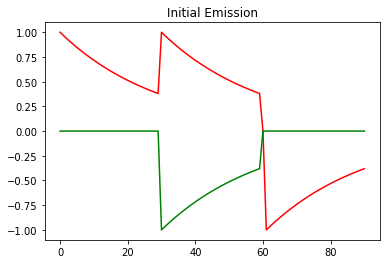

In [17]:
plt.figure()
plt.title("Initial Emission")
plt.plot(range(0, 91), estimator.emit_w_init_[0, 0, :], "-r")
plt.plot(range(0, 91), estimator.emit_w_init_[1, 0, :], "-g")
plt.show()

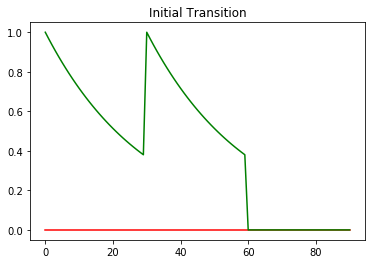

In [18]:
plt.figure()
plt.title("Initial Transition")
plt.plot(range(0, 91), estimator.trans_w_init_[0, 1, :], "-r")
plt.plot(range(0, 91), estimator.trans_w_init_[1, 0, :], "-g")
plt.show()

In [19]:
emit_w_final = output[-1]['emit_w']
trans_w_final = output[-1]['trans_w']

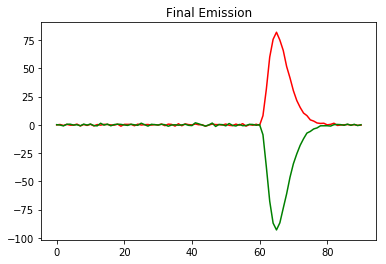

In [20]:
plt.figure()
plt.title("Final Emission")
plt.plot(range(0, 91), emit_w_final[0, 0, :], "-r")
plt.plot(range(0, 91), emit_w_final[1, 0, :], "-g")
plt.show()

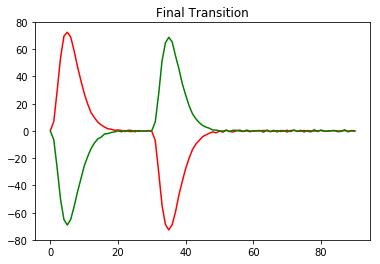

In [21]:
plt.figure()
plt.title("Final Transition")
plt.plot(range(0, 91), trans_w_final[0, 1, :], "-r")
plt.plot(range(0, 91), trans_w_final[1, 0, :], "-g")
plt.show()